In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_op
# from WindPy import *
from functools import reduce
import datetime

In [2]:
np.set_printoptions(precision=2)

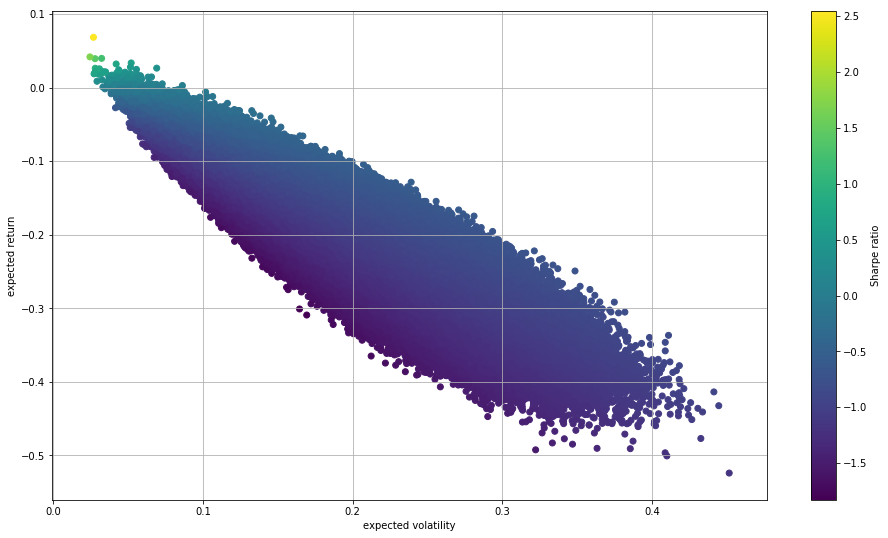

In [20]:
tmp_return = []
tmp_volatility = []

for p in range(900000):
    
    weights = np.random.random(8)
    weights /= np.sum(weights)
    expected_return = np.dot(weights.T, rets.mean())*252
    covariance_matrix = rets.cov()
    expected_volatility =np.sqrt(np.dot(np.dot(weights.T, covariance_matrix), weights)*252)
    
    tmp_return.append(expected_return)
    tmp_volatility.append(expected_volatility)

    
tmp_return = np.array(tmp_return)
tmp_volatility = np.array(tmp_volatility)

plt.figure(figsize=(16,9))
plt.scatter(tmp_volatility, tmp_return, c=tmp_return/tmp_volatility, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [21]:
tmp_volatility.min()

0.02456153403641352

In [23]:
tmp_volatility.max()

0.4514185261057201

In [2]:
data=pd.read_excel('./data/value.xlsx')
data.set_index('Date',inplace=True)

In [3]:
tmp=data.loc[(data.index>'2015-05-20')&(data.index<'2015-12-31'),:]
rets=np.log(tmp/tmp.shift(1))
rets.dropna(inplace=True)

In [4]:
anual_rets=[-0.48,0.04,-0.34,-0.67,-0.12,-0.33,0.13,0.08]

### reference_weights

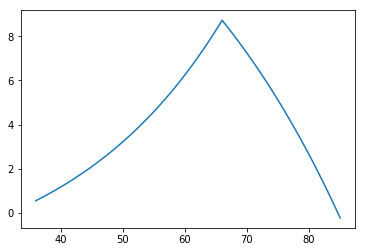

In [5]:
wage=10
l_wage=10*(1.03**30)
save=3
incre1=1+0.04
incre2=1+0.03
infla=1+0.03
use=15
dic_returns={}
years=[]
rates=[]
refer_rates={}
dic_returns[35]=10
for year in range(36,86):
    if year<67:
        dic_returns[year]=dic_returns[year-1]*incre1+save
        rate=dic_returns[year]/l_wage
    else:
        dic_returns[year]=dic_returns[year-1]*incre2-use
        rate=dic_returns[year]/l_wage
    refer_rates[year]=rate
#     print(year,dic_returns[year])
    years.append(year)
    rates.append(rate)
plt.plot(years,rates)

In [90]:
refer_rates[85]

-0.22688700038522386

### find_weights

In [6]:
def fun_volatility_min(weights):
    covariance_matrix = rets.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

In [12]:
def get_weights_volatility():
    weights_volatility=[]
    for i in range(1000000):
        if i%10000==0:
            print(i)
        weights=np.random.random(8)
        weights/=np.sum(weights)
        std=fun_volatility_min(weights)
        tmp=[item for item in weights]
        tmp.append(std)
        weights_volatility.append(tmp)
    return weights_volatility

In [8]:
def fun_expected_returns(weights1,weights2,weights3):

    expected_returns=[]
    x1=weights1
    x2=weights2
    x3=weights3
#     print(x3)
    for year in range(35,50):
        expected_returns.append(np.dot(x1.T, anual_rets))
    for year in range(50,75):
        expected_returns.append(np.dot(x2.T, anual_rets))
    for year in range(75,86):
        expected_returns.append(np.dot(x3.T, anual_rets))
    return expected_returns

In [9]:
def fun_utility_accumulation(weights1,weights2,weights3):
    expected_returns=fun_expected_returns(weights1,weights2,weights3)
#     print(expected_returns)
    dic_returns1={}
    utility_list=[]
    dic_returns1[35]=10
    for year in range(35,85):
        if year<66:
            ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])+save
        else:
            ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])-use
        ex_rate=ex_wealth/l_wage
        if ex_rate>refer_rates[year+1]:
            utility=ex_rate-refer_rates[year+1]
        else:
            utility=2*(ex_rate-refer_rates[year+1])
        utility_list.append(utility)
        dic_returns1[year+1]=ex_wealth

#     print(weights,np.sum(utility_list))
    return np.sum(utility_list)

In [23]:
# def get_weights_accumulation():
#     target=[0.25,0.08]
#     constraints = ({'type':'eq', 'fun':lambda x: 0.25-fun_volatility_min(x[0:8])},
#                    {'type':'eq', 'fun':lambda x: 0.08-fun_volatility_min(x[8:16])},
#                   {'type':'eq', 'fun':lambda x: fun_volatility_min(x[8:16])-0.25},
#                    {'type':'eq', 'fun':lambda x: fun_volatility_min(x[16:24])-0.08},
#         {'type':'eq', 'fun':lambda x: np.sum(x[0:8])-1.},
#                 {'type':'eq', 'fun':lambda x: np.sum(x[8:16])-1.},
#                   {'type':'eq', 'fun':lambda x: np.sum(x[16:24])-1.},
#                   )
#     weights=np.random.random(24)
#     weights[0:8] /= np.sum(weights[0:8])
#     weights[8:16] /= np.sum(weights[8:16])
#     weights[16:24] /= np.sum(weights[16:24])

#     bounds = tuple((0,1) for x in range(24))

#     initial_guess = weights

#     opts = sci_op.minimize(fun=fun_utility_accumulation,
#                            x0=initial_guess,
#                            method='SLSQP',bounds=bounds,
#                            constraints=constraints)
        
#     return opts['x']

In [10]:
x=['w1','w2','w3']
title=[]
for i in range(3):
    for j in range(8):
        tmp=x[i]+str(j)
        title.append(tmp)
title.extend(['std1','std2','std3','utility'])

In [11]:
def get_weights_list(name,target):
    with open('./results/'+name+'.csv','w') as f:
        f.write(','.join(title)+'\n')
        weights1=[]
        weights2=[]
        weights3=[]
        for item in weights_volatility:
            if item[-1]>=target[0]:
                weights1.append(item)
            if item[-1]>=target[1] and item[-1]<target[0]:
                weights2.append(item)
            if item[-1]<target[1]:
                weights3.append(item)

        print(len(weights1),len(weights2),len(weights3))

        for i in range(100000):
            if i%1000==0:
                print(i)
                try:
                    print(results)
                except:
                    pass
            x1=np.random.randint(len(weights1))
            x2=np.random.randint(len(weights2))
            x3=np.random.randint(len(weights3))
            w_x1=np.array(weights1[x1][:-1])
            w_x2=np.array(weights2[x2][:-1])
            w_x3=np.array(weights3[x3][:-1])
            results=[str(item) for item in w_x1]
            results.extend([str(item) for item in w_x2])
            results.extend([str(item) for item in w_x3])
            results.append(str(weights1[x1][-1]))
            results.append(str(weights2[x2][-1]))
            results.append(str(weights3[x3][-1]))
            results.append(str(fun_utility_accumulation(w_x1,w_x2,w_x3)))
            f.write(','.join(results)+'\n')

In [ ]:
weights_volatility=get_weights_volatility()

In [15]:
target_list=[]
a=[0.12,0.14,0.16,0.18,0.2,0.25,0.3,0.35]
b=[0.03,0.04,0.05,0.06,0.07,0.08]
for i in a:
    for j in b:
        target_list.append([i,j])
for item in target_list:
    name=str(item[0])+'_'+str(item[1])+'_'+'result'
    get_weights_list(name,item)

966175 33820 5
0
1000
['0.08257232770657655', '0.09109167126588205', '0.13061683348653294', '0.1606302450072853', '0.15879452192141447', '0.17547391292127235', '0.12367290690785417', '0.07714758078318218', '0.04944167958930856', '0.25103834379939516', '0.19542134307994322', '0.004429300649888474', '0.16079428504176982', '0.011122080517943564', '0.18515392582908283', '0.1425990414926683', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.23547296717410052', '0.11218471331512342', '0.025729363617612848', '-565.8448791134579']
2000
['0.12876079899108553', '0.06614030042428704', '0.010859264323716679', '0.08901255853307388', '0.20745048305708164', '0.20962972458723406', '0.2199957833671661', '0.0681510867163552', '0.18242230490072714', '0.27902647953903814', '0.009221704445890823', '0.03051767732310793', '0.08410173915297392', '0.05692632863929264', 

14000
['0.1201077724939391', '0.21015458316525543', '0.1641972671072306', '0.1595605930699133', '0.02713134428609318', '0.1062315248132584', '0.04872770963590957', '0.16388920542840038', '0.09151876493385872', '0.2507817681223989', '0.062490604718453115', '0.08999485281763048', '0.07489501761994548', '0.023325398554108378', '0.25680843466367154', '0.15018515856993336', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.23029571986163272', '0.10626716115797222', '0.028568682149147647', '-554.652038966066']
15000
['0.18142535714666494', '0.17861842832526587', '0.20279180349558765', '0.1381133770704488', '0.053720730085905916', '0.007253083377404595', '0.05818226786092764', '0.17989495263779462', '0.12846090886084544', '0.003794448345451391', '0.09030607297501739', '0.058459292510471446', '0.1495035933600655', '0.021529109027033328', '0.23390745261431678

27000
['0.17097802701447495', '0.15257936161060975', '0.08706568181112305', '0.10585465138621829', '0.19797971016588142', '0.1566706800614062', '0.07935204699791397', '0.049519840952372406', '0.07885480551880038', '0.2721202080582927', '0.0770722638729232', '0.02660779689034575', '0.17120520583113416', '0.06658113199404303', '0.04316430702507847', '0.2643942808093824', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.199045126722272', '0.09700654106275788', '0.024073819089160054', '-562.581598633068']
28000
['0.1761872086445411', '0.028021531479780554', '0.18199588162141717', '0.19083595553917623', '0.10249837087535378', '0.024656858521085893', '0.14098681337131388', '0.1548173799473314', '0.1543618790550255', '0.2860819380988719', '0.06358588524694715', '0.03673674403765019', '0.11417883405153732', '0.014847347880375877', '0.21502574213391287', 

40000
['0.18093803741415287', '0.2600301077880956', '0.005882750033963155', '0.05079910898881877', '0.197303796156435', '0.24216306936411516', '0.010382351857946727', '0.05250077839647275', '0.023982177279085866', '0.026696134704957082', '0.12986724810602734', '0.0029084987663679143', '0.3570580131303614', '0.02281984622831256', '0.35847650528822506', '0.07819157649666272', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.17603860953396894', '0.08885592931970264', '0.024073819089160054', '-552.8682422720366']
41000
['0.07557219521818348', '0.05785700094276884', '0.17879415968506412', '0.014001209075392746', '0.19477462453926456', '0.15343157922987558', '0.055321413024572504', '0.2702478182848781', '0.14177698591605734', '0.28696934562147364', '0.024288983731180658', '0.01807916302014259', '0.3096843360304629', '0.09636383968675195', '0.0402527067

53000
['0.10744752248205072', '0.19136173738700604', '0.10075897333538941', '0.035177635498592826', '0.29212724407975255', '0.19364360071261388', '0.023788931948304098', '0.055694354556290425', '0.2072835143806047', '0.10960452155093145', '0.015052686217550973', '0.006554732383435875', '0.11462496149051907', '0.06479626288689226', '0.23138308959717807', '0.25070023149288756', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.17338233175001766', '0.0927252181680987', '0.025729363617612848', '-562.5884543163926']
54000
['0.09752538255881524', '0.08802414331840315', '0.25622187423075016', '0.0503777710077172', '0.017159128393220088', '0.06839022055838986', '0.21768262961153995', '0.20461885032116436', '0.1974995585437651', '0.19927140674459973', '0.07522107293418358', '0.03285962918834356', '0.12329825161684829', '0.013322980340062377', '0.245283386

66000
['0.07504711806879501', '0.19770372154942734', '0.11749185561459928', '0.18383043204898947', '0.21741141731984026', '0.021043908298092488', '0.04424845696135752', '0.14322309013889864', '0.10205557526368249', '0.02521213358488421', '0.02671542406271504', '0.056515937898570144', '0.2678980508041329', '0.005167789512289899', '0.28669202412391676', '0.22974306474980852', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.17898910401261667', '0.07591157418559695', '0.024073819089160054', '-557.5595579559233']
67000
['0.18134627106362794', '0.14567685111575446', '0.1300854179934236', '0.11243187891431179', '0.11852781201025692', '0.03221684188222733', '0.07177308681948727', '0.20794184020091072', '0.04321885283311961', '0.11502258009696943', '0.10460774990231202', '0.05149604230027945', '0.2591688390264882', '0.04892215611409292', '0.1613453403855

79000
['0.13986846795415625', '0.08304246499711246', '0.09400372592254602', '0.2556070398775339', '0.07825271728366977', '0.035274896221883185', '0.06594633769007358', '0.24800435005302476', '0.027529521000153868', '0.27181270885373787', '0.050750707247797004', '0.02311124532274176', '0.25978704598362434', '0.0789724810149126', '0.21943197905011655', '0.068604311526916', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.2240126322956805', '0.08089421339723955', '0.025729363617612848', '-564.8074587828551']
80000
['0.07661546063755292', '0.11322813517705124', '0.030144022631973993', '0.17452024987562395', '0.21714672041746885', '0.14264264667961127', '0.018748529802813593', '0.22695423477790425', '0.052043288814135065', '0.20157684329184436', '0.03805756037462327', '0.07912933382233711', '0.12071226788758355', '0.10280442998842267', '0.21402556378

92000
['0.24267545040873442', '0.23565649797298696', '0.1329274200590928', '0.11898451636857688', '0.05621488253961165', '0.1123784926883285', '0.06779576002553553', '0.03336697993713335', '0.05338524578237321', '0.1408782166933452', '0.05905140699993537', '0.00624380506491871', '0.18524469573435262', '0.17366352127577955', '0.17395208237274717', '0.2075810260765481', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.22397413546805547', '0.11906250560755921', '0.024073819089160054', '-564.7457776428521']
93000
['0.24577153205004226', '0.1588784099200517', '0.028169762935647227', '0.1158582522441124', '0.1953116854814099', '0.07113413824827676', '0.08955729146824662', '0.09531892765221306', '0.0010759867925834927', '0.17328560783509803', '0.012903363606865757', '0.11072011408680588', '0.21774603376110394', '0.06322243123564145', '0.2282214118889551

6000
['0.05130304642151833', '0.09074670014243708', '0.0965153218149836', '0.04105479548532161', '0.1775065140603743', '0.22629701104964006', '0.2554780456105977', '0.061098565415127294', '0.216650191790368', '0.21879600665618812', '0.016267180008407326', '0.014646448551931228', '0.1213290294401884', '0.0470754056203786', '0.19927552263644233', '0.1659602152960959', '0.015068461237185853', '0.40197289453831764', '0.02885649473267835', '0.0033055549345523787', '0.15560253549787703', '0.026295084174832', '0.2978577216644357', '0.07104125322012103', '0.17424791956007668', '0.09245255518089791', '0.035385626513339576', '-527.0640598349111']
7000
['0.021640963187963855', '0.19926468346491533', '0.17699461492154003', '0.22263816274805487', '0.052021804754967496', '0.09395975161733493', '0.10719667778277268', '0.12628334152245083', '0.19874973980971758', '0.35147499204163113', '0.06003745107179588', '0.048188184989153025', '0.2049416429946886', '0.035670309017076074', '0.0801575771037962', '0

19000
['0.14904380676756457', '0.010421711210563083', '0.024138656360487804', '0.15558992992225737', '0.13021738020737805', '0.04273201850609268', '0.2605554821142838', '0.22730101491137258', '0.0398054462039735', '0.05718858584224281', '0.0053771633839428245', '0.05697371429769796', '0.2703702157337179', '0.09857480790430903', '0.30033550439599094', '0.17137456223812503', '0.020944062758086798', '0.15082052018472594', '0.011693466160590608', '0.009285798892043782', '0.13612721019197244', '0.04411666213243945', '0.35874318370675595', '0.26826909597338505', '0.14383647777103717', '0.08848594113767942', '0.03828252846712441', '-531.1513078486034']
20000
['0.011218676466899063', '0.021615894043345494', '0.08152499521358132', '0.10804539160828128', '0.20441422517592844', '0.16456241141395686', '0.2353100402067809', '0.17330836587122667', '0.030832286065059902', '0.1497705017029509', '0.033493152030352455', '0.040297586811068195', '0.24520588596101484', '0.13365497709164934', '0.21194723772

32000
['0.16927160132733715', '0.04471926464509947', '0.15370995384522437', '0.11713350680883337', '0.16975907377979801', '0.16011259532853483', '0.031218591141857734', '0.15407541312331507', '0.15354056772648444', '0.13667495282635733', '0.013698305372487505', '0.082491820178788', '0.17175099223846899', '0.03804265993021537', '0.16388055976225294', '0.2399201419649455', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.23610306367212286', '0.10292520249936307', '0.028568682149147647', '-557.5028284859135']
33000
['0.1578384454584749', '0.07073208237825909', '0.07474122336085684', '0.13541837706466975', '0.07196679672506291', '0.19896406461668562', '0.1274649803981565', '0.1628740299978344', '0.05056254646338156', '0.26363554359672614', '0.022891822268882103', '0.07301687242455673', '0.027799133319828615', '0.10234979979784095', '0.24293369060867456'

45000
['0.09436086783827165', '0.0002756942341297116', '0.16683742087330417', '0.19415696997316992', '0.021338562743504774', '0.15854689830392105', '0.24853978428846538', '0.11594380174523343', '0.24555015122988977', '0.10867741302349981', '0.004629573956090338', '0.052942581508634935', '0.14893102658103924', '0.06240112129733976', '0.12593854497186543', '0.2509295874316407', '0.0661410399185812', '0.33798307658986637', '0.018300579771559772', '0.003729007262819952', '0.04442451397519328', '0.02174587630120896', '0.3158156362937448', '0.19186026988702565', '0.26574542145963465', '0.11859550523174495', '0.03648897096907148', '-539.3533918747048']
46000
['0.10851420460805494', '0.003485340531021176', '0.0513816014571186', '0.22156413049384974', '0.00830873586050346', '0.22054114219713475', '0.22385080850157316', '0.16235403635074427', '0.09509084639188192', '0.19936528470247286', '0.02680941928256879', '0.030309898045279435', '0.17553473964791655', '0.046735342265591416', '0.030833294447

58000
['0.19440810244629295', '0.24165586965781874', '0.03308681930147236', '0.08906278524361254', '0.11045116023714308', '0.13517896988128383', '0.17533511649773734', '0.020821176734639193', '0.03614653736784829', '0.14004736443525903', '0.06206256422477743', '0.0597735121465991', '0.2128618221731293', '0.0739992383202038', '0.2661790793879697', '0.14892988194421347', '0.01940272312368046', '0.41989142961224285', '0.0007260764322387958', '0.022452318775757475', '0.008982295295239256', '0.03765962720869403', '0.14625948830081487', '0.3446260412513323', '0.16236366039403513', '0.1014247820661092', '0.03298789827530703', '-538.6226352576325']
59000
['0.1360557108842953', '0.16908367082625483', '0.09058961740237728', '0.16836046256479864', '0.10468270076063652', '0.09450863062142116', '0.08020123141948456', '0.15651797552073168', '0.09721410467864766', '0.07936421931836238', '0.119183055951031', '0.02341099784280414', '0.13463980604768322', '0.0007300670623425606', '0.2994429904816971', '

71000
['0.11343087953796126', '0.18810467314718401', '0.0917699738767922', '0.0018057716513962044', '0.17367227633915447', '0.1872663423735539', '0.23982086439169173', '0.004129218682266142', '0.18369965311717212', '0.17703711374672976', '0.08016731157969023', '0.0005332373189842147', '0.02157795412116303', '0.007326021922648633', '0.34735796135551417', '0.18230074683809797', '0.014467486122379985', '0.32648235299483963', '0.004182191091485021', '0.03134659775059854', '0.1776059445446883', '0.00640643869230969', '0.30657779917096734', '0.13293118963273157', '0.14978690146149226', '0.08579277578631106', '0.03305317664859906', '-510.8948694316623']
72000
['0.21965428834314152', '0.22028055293083065', '0.17599503671992314', '0.11913147931889045', '0.07058797285265649', '0.13532863924229097', '0.001717743714701648', '0.057304286877565065', '0.21504612617300617', '0.026614086352748572', '0.03856365953925127', '0.0037445643707711153', '0.21304321734402376', '0.039155298780206745', '0.2973558

84000
['0.058043648186599316', '0.07840074798533325', '0.20187395068363925', '0.12272746438626786', '0.21515865987149843', '0.10365667434544744', '0.04094192253122282', '0.17919693200999165', '0.026733763390828624', '0.2798168668674323', '0.048453886367353344', '0.019152646207537587', '0.04985629945626717', '0.0721710547812161', '0.24031111706209474', '0.2635043658672702', '0.0661410399185812', '0.33798307658986637', '0.018300579771559772', '0.003729007262819952', '0.04442451397519328', '0.02174587630120896', '0.3158156362937448', '0.19186026988702565', '0.21570249537465777', '0.06923949885026971', '0.03648897096907148', '-499.14925034807675']
85000
['0.09023917700662264', '0.07152172119054973', '0.20753346477636922', '0.18816969125780986', '0.014119735066185087', '0.10142868511765614', '0.21166427794846482', '0.1153232476363424', '0.05349613939411536', '0.07264915194595584', '0.14207684628909653', '0.06688685885781721', '0.18698126429746562', '0.006084558280200328', '0.267944670711127

97000
['0.2392007348023041', '0.17112100629530788', '0.03831080355449862', '0.043313148678703256', '0.189070458856361', '0.10920158410444956', '0.03460031832608859', '0.17518194538228687', '0.2069303249188637', '0.2913629042358266', '0.05207807631696043', '0.06380072615213676', '0.26423444926436057', '0.015144880240581577', '0.08042592197261773', '0.026022716898652636', '0.03575407238062236', '0.21275882134052554', '0.019589449124921273', '0.016666670264468265', '0.20876474990003355', '0.005977858270984382', '0.19891918800659736', '0.3015691907118472', '0.1451394843703386', '0.11785614256451998', '0.039475218114095004', '-522.0486573965993']
98000
['0.23984066853735347', '0.14485451267255808', '0.10238794708892028', '0.20686745272063942', '0.053366747011653455', '0.019604282397475952', '0.13515377717390428', '0.09792461239749498', '0.04785070871472502', '0.2989150042520069', '0.08680911876774484', '0.0951215405347009', '0.24332170476858744', '0.026511729600447162', '0.070705823572263',

11000
['0.20580076405412936', '0.016901289211525852', '0.22970713866847342', '0.0734213944887752', '0.1201405274481681', '0.053492687494180034', '0.03996083939453428', '0.2605753592402137', '0.11627449844964183', '0.2673457416711246', '0.03928444517516805', '0.00676908329040119', '0.08184545311249496', '0.13784302313426605', '0.12585041943184344', '0.22478733573505985', '0.08055566867168742', '0.143431711803316', '0.016536367619503452', '0.012670737934388544', '0.08988329051941288', '0.01200556963059376', '0.33419346427061714', '0.3107231895504807', '0.21382124214999604', '0.10810999887778744', '0.04138224268293535', '-532.9367571966555']
12000
['0.2426836074969534', '0.041102651332606', '0.002789244604582762', '0.07455597638434268', '0.3054583177347127', '0.29190820344281815', '0.030330824964304264', '0.011171174039680152', '0.07907030499834826', '0.2000262475489817', '0.13979658613786147', '0.017557783565980815', '0.15810640109155144', '0.011965312898888684', '0.18570359568884848', '

24000
['0.028683501833802343', '0.12062039054052766', '0.20477836150834225', '0.141613930111764', '0.19518481035495477', '0.012700238216209673', '0.17581823170347202', '0.12060053573092741', '0.0009785999261056528', '0.2284327738481324', '0.06507699545666494', '0.10715255618530468', '0.24577333272103874', '0.04633180254303403', '0.23060008805111615', '0.07565385126860343', '0.06060988139047647', '0.308390974067585', '0.004130250161103262', '0.001423674615784564', '0.22892151912032643', '0.0013035582433085166', '0.07534482100903128', '0.3198753213923845', '0.18585760764876397', '0.11005285107616802', '0.037412810755361826', '-516.2406751131947']
25000
['0.025077440297192007', '0.1243281853642754', '0.17378351754288515', '0.09962274120109457', '0.23059857190848027', '0.04981765595260027', '0.16740453139356404', '0.12936735633990834', '0.12017602581734489', '0.18825871075914388', '0.1247005090392235', '0.0007846210668972329', '0.15380522719026812', '0.021887785720587805', '0.1745275867808

37000
['0.1902319136528389', '0.04742500938147496', '0.14418152771012233', '0.022654517433917307', '0.10488953756702862', '0.19715184315981257', '0.15381324213902353', '0.13965240895578174', '0.024807838539580795', '0.2061013552537954', '0.024339926653981776', '0.027164456918801635', '0.3579708411133367', '0.022057848107305295', '0.08822521185227225', '0.2493325215609261', '0.03804928458380468', '0.3111531026825863', '0.022284100589827136', '0.025944541075879776', '0.1979298590917158', '0.017104518742992552', '0.36700725243229626', '0.020527340800897523', '0.20428788080851498', '0.060726133840600764', '0.046500908377975526', '-509.84767065447517']
38000
['0.14224089341180945', '0.07582593295627721', '0.19131695826329245', '0.17770756343540559', '0.13424385726396754', '0.044228772366763966', '0.15201829627204816', '0.08241772603043579', '0.13484727143764313', '0.2011732961020707', '0.08365551907767242', '0.024962973776220445', '0.2030704968562433', '0.04128388268261999', '0.115708137126

50000
['0.17721657086197964', '0.030649521236997684', '0.07885118604365818', '0.19881044672987513', '0.17990192965753357', '0.07010814094081123', '0.17354402589592383', '0.09091817863322077', '0.06933450766757725', '0.13930854618886793', '0.00607143490767042', '0.03497212828025998', '0.3479534172861147', '0.060891813820630185', '0.01803116506462456', '0.323436986784255', '0.0666715042127838', '0.3937259029261086', '0.040514439675450355', '0.002584453107032001', '0.07893400768216044', '0.016969466882134486', '0.07222638751011132', '0.32837383800421904', '0.2088222608534813', '0.07691123635876136', '0.04450267854636225', '-525.4895949925975']
51000
['0.004832339730283449', '0.16461434283975288', '0.17480475277016264', '0.16788632433734896', '0.0750719498339198', '0.03027963637900498', '0.15424502025683087', '0.22826563385269638', '0.013453948417141074', '0.24150539712112257', '0.18280865277684463', '0.0013173220476893912', '0.17839308593648612', '0.06611427140373599', '0.0463745395116856

63000
['0.10159591988652923', '0.005376133433723244', '0.058455843621168124', '0.09470826363831755', '0.08235649166618275', '0.27939022193148233', '0.28250540902649607', '0.09561171679610055', '0.013056627064522321', '0.21425759911658226', '0.03543882654714806', '0.10318045773705337', '0.1902275039771396', '0.08519463785495184', '0.18057239959394208', '0.1780719481086604', '0.019628222053629064', '0.23644757205413677', '0.02980647585397413', '0.007855719615190363', '0.07182760983753238', '0.040312089607604955', '0.3008394679986458', '0.29328284297928653', '0.21685876598833687', '0.11064132322614337', '0.04068628911191471', '-540.9916779189537']
64000
['0.005297244886489654', '0.18665884451748196', '0.19802917891014984', '0.0655667968811533', '0.16787509671471637', '0.0839835059157815', '0.13761855600757195', '0.15497077616665544', '0.08354898610453862', '0.2605797477664922', '0.07342684981447453', '0.061491700230566125', '0.10744332605239798', '0.004373806704517301', '0.134795214974136

76000
['0.20409549586415543', '0.21020651633303966', '0.07055348134202256', '0.02293893732943075', '0.13087028281993934', '0.1720592364077435', '0.1270292923799673', '0.06224675752370135', '0.05271113964954584', '0.14725433099035617', '0.13375127985969884', '0.0020783102637923425', '0.15095719441727803', '0.06119548342229896', '0.306207862595639', '0.1458443988013908', '0.022094038322302775', '0.13381337487983208', '0.029982394574374998', '0.025075690176503795', '0.07092610276122802', '0.024143627933835787', '0.3336270910409703', '0.36033768031095226', '0.16507781729760104', '0.10210045405384395', '0.04333780656550249', '-529.2891891521145']
77000
['0.03732377956456355', '0.1422788582796974', '0.13899187767945523', '0.1328660560365396', '0.15495645227500224', '0.1559757132546001', '0.1077487016648708', '0.129858561245271', '0.022692729904555158', '0.2391504752072677', '0.004160011924097328', '0.022345479698088137', '0.18734694373930164', '0.21498293143402947', '0.1739752909497468', '0.

89000
['0.11983779227395618', '0.09887500833641986', '0.11450919044706726', '0.17117280198117796', '0.14219294797322868', '0.09035942019797034', '0.15206617492180283', '0.11098666386837688', '0.0017797123962595884', '0.22830019902141885', '0.029563333797307825', '0.024468479908021333', '0.010793608460134173', '0.11860037672760135', '0.3164265455606829', '0.2700677441285739', '0.07710846253803043', '0.20776011603360287', '0.0011606928337543419', '0.0015798511619672772', '0.18124337434386323', '0.0274936654216074', '0.2529663682833725', '0.250687469383802', '0.20637087641702678', '0.07854934599466606', '0.041815750225242976', '-471.4177088489802']
90000
['0.05880629178665944', '0.05975150671067223', '0.22535603240080218', '0.12896687975842122', '0.12889397950663872', '0.030809429907843435', '0.21317694014963753', '0.15423893977932526', '0.16344351648761116', '0.18746816378112083', '0.07602624109983862', '0.04125298067420044', '0.22659575746696023', '0.0296157407215318', '0.15956937674700

3000
['0.031473141366595556', '0.024833031834012916', '0.10377197705934367', '0.15471501784845265', '0.20265141007546716', '0.16695019846233503', '0.08444836370702916', '0.23115685964676386', '0.004671703318876295', '0.18002427377833957', '0.00517219084539036', '0.011743349310909798', '0.10988646241695185', '0.15643107077642673', '0.28857977805261986', '0.2434911715004855', '0.04552334658999511', '0.23670406250526518', '0.0109587061866349', '0.025945311693849935', '0.24866356049673247', '0.041995331024813606', '0.22642098046246456', '0.16378870104024437', '0.2065039528484867', '0.07997766242993935', '0.056152683445384086', '-473.1366495608474']
4000
['0.18560673481217968', '0.01977154539530275', '0.11110445543989998', '0.062415057266462314', '0.13688040696492218', '0.15380029327962152', '0.14675624147170843', '0.18366526536990319', '0.1880247575263694', '0.12784674534875223', '0.061523715312949596', '0.006826982756007066', '0.19778789522494908', '0.05017638178028091', '0.12432778945221

16000
['0.08634840503985046', '0.18637778725008414', '0.23023839724678516', '0.010721206466466439', '0.1288105882477265', '0.03784820566289479', '0.1517103769236763', '0.16794503316251622', '0.07722200409354187', '0.08930594071881608', '0.11095393565933667', '0.03988106838310197', '0.19951548470399402', '0.06404847050797417', '0.23669380942828894', '0.18237928650494642', '0.01212565788646693', '0.1837396506933715', '0.018031997252508113', '0.06477694266502965', '0.07220807949629553', '0.001190981640995561', '0.2599911188570835', '0.38793557150824937', '0.14947013347898921', '0.11804241421589864', '0.04760454309395647', '-518.0780735748631']
17000
['0.08697908626486762', '0.0788935073627816', '0.15524366629001496', '0.21011831194818434', '0.16153490931912967', '0.17880575189079095', '0.07176166243518431', '0.0566631044890466', '0.10392232982430895', '0.2315873113549149', '0.030038210421488642', '0.04575516344583902', '0.05718928478521476', '0.09875824562632121', '0.15083504804891285', '

29000
['0.20863974435566465', '0.09656019402561428', '0.0386055231084323', '0.18729159312505014', '0.020356755250996155', '0.057414371950256', '0.1580278132868815', '0.23310400489710506', '0.15274420111108356', '0.29918767128765406', '0.0275415898758629', '0.08152025308845084', '0.18665243126436484', '0.06376489729580898', '0.16967315334247374', '0.018915802734301004', '0.05182505524868607', '0.21552095889064582', '0.0033810302840468365', '0.006229551584143578', '0.2561920596700687', '0.06392749149095689', '0.3332947336590226', '0.0696291191724295', '0.1859835579376133', '0.11827926053728066', '0.05572833916050991', '-516.0314128094416']
30000
['0.10115801128839204', '0.12612533991600164', '0.1434137783315657', '0.060217167756408375', '0.012854881335137978', '0.13301445451007507', '0.21236689188128544', '0.2108494749811337', '0.05485343311205274', '0.14678790919689674', '0.025656862116115328', '0.12143609832682177', '0.1897744675379858', '0.04419126104577985', '0.2006384194828462', '0.

42000
['0.3108738672569176', '0.032204467776510703', '0.10955512017484376', '0.13206269288200184', '0.2868041959856545', '0.021553515092981552', '0.06512343613766079', '0.041822704693429316', '0.08811707484598465', '0.3232352506031733', '0.055922846237087875', '0.032842978407140656', '0.09307412336423444', '0.0001767539973924801', '0.2266618202439824', '0.17996915230100408', '0.05793680172341654', '0.25820625151735677', '0.0217436332617103', '0.023387920017479275', '0.20817497675705052', '0.014858630073473319', '0.18718727113821257', '0.22850451551130083', '0.2033998083863179', '0.06462166205786973', '0.04973862722320209', '-507.601217518921']
43000
['0.22070087137773303', '0.049056730820368516', '0.13158652492578532', '0.2582459847194778', '0.05701284596326577', '0.2581949476003257', '0.017068599849469256', '0.008133494743574712', '0.1659107814370089', '0.2850310838640103', '0.0076249610628391475', '0.037873491936964265', '0.2216830010865263', '0.08340226243452303', '0.139795267019763

55000
['0.22087326546807876', '0.00425253028461333', '0.14719923048827463', '0.15472784560157543', '0.12098072685267078', '0.0331069634462309', '0.16279735200202927', '0.15606208585652695', '0.16472364289757915', '0.10305728956142281', '0.02966416317233959', '0.003983917728909676', '0.21918977548916369', '0.13616215979868576', '0.1363154732754139', '0.20690357807648535', '0.020286793907619692', '0.30819645253410793', '0.06209384493178121', '0.01651284925511572', '0.245307659582544', '0.022568104914119876', '0.30402710206733224', '0.02100719280737928', '0.2125729541609572', '0.11712066040076416', '0.05947865332651864', '-518.9744481369884']
56000
['0.12531810264975968', '0.1433096641447096', '0.1673557296884346', '0.014350441354052654', '0.1663501242883716', '0.1306765279362185', '0.12280159712200164', '0.12983781281645185', '0.14223303737000034', '0.1702854811268243', '0.09604634974705971', '0.0193688839784595', '0.16673054061317497', '0.0057303198382949545', '0.20878391279161915', '0.

68000
['0.1878798041542586', '0.22732000798375512', '0.08987844127949042', '0.09025908656565461', '0.019704716216509384', '0.050907185154057295', '0.22417752532981156', '0.10987323331646294', '0.13386521342530788', '0.17580454881645546', '0.046630315647547826', '0.026616489903062028', '0.10362797066270206', '0.09404050682095698', '0.20767471061533535', '0.21174024410863246', '0.1285882215323381', '0.24425884269077675', '0.003683190703716541', '0.0005235604077960489', '0.21224512864014544', '0.03724823260230279', '0.19903265317395175', '0.17442017024897255', '0.15200466772487042', '0.10649142183616787', '0.05987624393324971', '-493.897330891588']
69000
['0.17218614791429454', '0.11106844743920284', '0.19452838016929336', '0.05650553201145427', '0.12674650615433594', '0.01712366716233859', '0.16586467007484645', '0.15597664907423406', '0.11204603743683998', '0.2496220398702817', '0.013820303159415457', '0.02292769657860857', '0.29332616926619665', '0.03359875069703924', '0.06600319298113

81000
['0.08888141599857692', '0.005683567757695751', '0.08771070018715461', '0.08568189502941906', '0.08144047568457907', '0.20820780887255708', '0.15127912257965545', '0.29111501389036193', '0.07075159338591609', '0.20110239183881073', '0.15887813652617308', '0.023104929818780328', '0.22861956695096816', '0.030227525976071177', '0.1649435381537911', '0.12237231734948936', '0.03254934757620935', '0.057782194475203566', '0.09620909657366826', '0.0016244951185668734', '0.04825107459691646', '0.0021214444494686052', '0.46201829404464984', '0.2994440531653171', '0.19227931471883697', '0.11768095555268708', '0.055448894625248185', '-541.7962273068091']
82000
['0.13197655212583267', '0.043997921424073064', '0.16198453448402567', '0.13452166509257768', '0.08408262904285575', '0.03092410437209212', '0.18590363051715791', '0.22660896294138513', '0.19173536975582242', '0.4249145748931487', '0.0673269124208581', '0.021287518076474374', '0.034107203243287344', '0.03680756930373223', '0.0792986411

94000
['0.18574534962164768', '0.10643570882337319', '0.12322933989682505', '0.07199489148169426', '0.12263360052130995', '0.037386581049489526', '0.15977148494175716', '0.19280304366390316', '0.16496721074327342', '0.3179682093717286', '0.04390996635760268', '0.019314851777494743', '0.02914509051532474', '0.079863210111341', '0.04690686608245348', '0.2979245950407814', '0.03717685800570174', '0.5056646491600626', '0.04689872254126181', '0.02024007731400418', '0.04774484284741182', '0.04466714969398045', '0.21027734006429574', '0.08733036037328167', '0.1527280103881759', '0.10328416704678708', '0.05934767543227256', '-514.9991440273898']
95000
['0.03387214209457282', '0.0916943676194387', '0.27705297824076636', '0.052402608457547316', '0.16878607200318307', '0.0435729239515173', '0.16973418925072575', '0.1628847183822487', '0.1803580084150058', '0.18246388222049972', '0.03797405691182819', '0.005680290609381068', '0.18324734172941984', '0.025113530310262627', '0.1699988104659231', '0.2

8000
['0.00971664631008454', '0.17586977690012182', '0.17836897043528988', '0.13784082617135282', '0.009882549696687115', '0.16235237400663677', '0.17197685700986956', '0.15399199946995762', '0.20055940651967924', '0.23932553491527822', '0.11013853209710675', '0.027922606955372253', '0.0771083519048171', '0.008563099925879926', '0.11706133148850224', '0.2193211361933643', '0.050251592090840194', '0.1598036714561136', '0.020817985406583438', '0.03844594280231105', '0.18195004344755464', '0.02813681174160761', '0.25656217182726565', '0.26403178122772386', '0.22676980680352804', '0.11701910321030831', '0.05730034824070449', '-510.3681017957307']
9000
['0.034309158478511646', '0.22635676010045144', '0.08240731770932835', '0.1877213893287028', '0.13585689956704008', '0.010631965121806511', '0.21934919985370213', '0.10336730984045715', '0.04978205231182043', '0.11687208417321833', '0.010894964599795984', '0.09078854973355768', '0.30198502392489956', '0.05909021026693433', '0.1769823225849587

21000
['0.0011647195870971418', '0.2502525687601328', '0.27016648625999795', '0.22425926765963758', '0.04331109485883698', '0.1448167717174097', '0.04571588981621374', '0.02031320134067413', '0.03411353445265295', '0.07790400776861217', '0.1258837195452007', '0.009109300862422929', '0.17620878980865243', '0.112234432961497', '0.1217718248065088', '0.34277438979445296', '0.09737736576276929', '0.21838415213374246', '0.0066344697748499425', '0.03203056949348821', '0.17693304032806653', '0.013533028503137643', '0.22305886898546076', '0.23204850501848528', '0.30781432415986903', '0.11994129373296765', '0.05456500233143438', '-511.02691394679886']
22000
['0.21067248106664585', '0.05782342982644416', '0.16926685707962172', '0.151326249669192', '0.044236214059343616', '0.14567510515864426', '0.1590430083393271', '0.06195665480078138', '0.16324652070211507', '0.1360505418728239', '0.024419564402891853', '0.01947890863930375', '0.18990915095082422', '0.02908001995752562', '0.3193962912372639', 

34000
['0.1645628808637157', '0.12363996463591821', '0.1343700035103333', '0.029863577076130233', '0.1924461754554472', '0.13380198670930343', '0.13177784407644005', '0.08953756767271194', '0.10360326852380777', '0.1420821922982959', '0.03260628746822178', '0.004555801199496585', '0.24303676514260836', '0.09424413524268833', '0.14917357444400264', '0.23069797568087858', '0.09263205221069744', '0.09456771385512236', '0.018117193854750996', '0.012278631142615262', '0.2722300055426255', '0.029660110886917397', '0.3040389351152439', '0.17647535739202722', '0.17164166850132945', '0.08770693981400741', '0.0614563270417538', '-499.9643390943363']
35000
['0.17420440988500682', '0.10876493437137005', '0.21754383739841035', '0.02137190588851369', '0.016019766701581336', '0.1467917721643809', '0.23142557546772902', '0.08387779812300793', '0.06738790134326994', '0.18977834750238715', '0.03169188227002441', '0.13524272503782692', '0.19104098527225766', '0.032038614414494494', '0.16875579194955548',

47000
['0.09989653552680007', '0.16504327030630328', '0.2914110268728347', '0.06927060087274203', '0.16930785008257637', '0.04692518629493565', '0.07401448263706184', '0.08413104740674611', '0.10958920980256749', '0.24621840417192126', '0.006957844134973931', '0.05142906504722343', '0.22561598673008335', '0.10232401585968463', '0.01837162242593674', '0.23949385182760902', '0.0982165047155239', '0.18532686328968434', '0.061178485361892694', '0.007317251277709767', '0.14277927833246362', '0.013920595061434568', '0.1842864382585259', '0.30697458370276526', '0.21584850380178933', '0.10204350519932105', '0.06402271641836979', '-508.87554523535374']
48000
['0.0344885506107201', '0.12236836819601478', '0.18166977316327565', '0.2441269257872659', '0.12005481524770956', '0.1898300447478905', '0.015752729324790275', '0.09170879292233314', '0.10371232229008835', '0.2407362798143412', '0.0875699936945181', '0.03692048991533812', '0.1133623324617654', '0.08518925986207675', '0.1898471394700104', '0

60000
['0.15659918328925063', '0.1601430903539402', '0.10712916845046208', '0.1732237422137969', '0.020091555860496314', '0.19426720812769202', '0.15314345592308776', '0.03540259578127412', '0.027833222882459294', '0.21429677873364972', '0.010348654756623665', '0.13705638589125302', '0.1821288071677667', '0.03811320681040375', '0.15717820589995846', '0.23304473785788526', '0.0153150799515311', '0.12831817100508544', '0.02648116436822669', '0.008149260073148383', '0.29165236589722354', '0.05575711288907256', '0.2546689529609051', '0.21965789285480716', '0.25442063040141893', '0.10085854087684427', '0.057066706143103635', '-522.2961597103819']
61000
['0.07912239320164823', '0.06553212171365609', '0.12392899130339663', '0.1013782598077724', '0.18033618982877334', '0.1593444716982466', '0.02766124349710391', '0.2626963289494028', '0.14500775154688256', '0.14794549890242234', '0.0479531661166212', '0.021010717955049128', '0.17014612210841915', '0.10316729857630544', '0.1696806211405503', '0

73000
['0.1468668411425949', '0.17391198289306498', '0.16036854581095172', '0.08432889810443023', '0.08828721420263666', '0.166483486517646', '0.07232760345647786', '0.10742542787219769', '0.17820601133831873', '0.024453357346414586', '0.1389231435508286', '0.00020571652111234687', '0.24765899904819247', '0.015937192224734758', '0.06882755435104215', '0.3257880256193564', '0.09354811946825924', '0.21798285283486626', '0.013315418165651852', '0.02106433891777279', '0.10724308365093271', '0.05537067628789049', '0.2967602942087635', '0.1947152164658633', '0.2197105365558529', '0.11758546744292268', '0.06415661128655695', '-513.4728105889395']
74000
['0.0031004572005756204', '0.18224428012183252', '0.06493588355594311', '0.13038860031105562', '0.13792674366040636', '0.14288313349402704', '0.22828320775533995', '0.11023769390081961', '0.07669118893694024', '0.207858600109576', '0.13186849117614638', '0.015541794781313805', '0.07151115996299248', '0.04295457358216933', '0.3184162569863579', 

86000
['0.23180358734507917', '0.034174852281293494', '0.05445889539584791', '0.0992341890439113', '0.2161698306953248', '0.01151379965559016', '0.11672465509520051', '0.2359201904877527', '0.20093814535422763', '0.002842438691059826', '0.027624819056833953', '0.003579470944905029', '0.4588001881166632', '0.07949618703209307', '0.008794666498474275', '0.21792408430574298', '0.05320170278009163', '0.2871446881809995', '0.031020876192018293', '0.024528361790242845', '0.26817093637433126', '0.018286318979653153', '0.06256229464384817', '0.25508482105881514', '0.13895025855014617', '0.11653936420309158', '0.05810629054021576', '-501.1022021836781']
87000
['0.0038841096395233177', '0.020039850235413312', '0.1881536129385369', '0.1910723799036923', '0.15854044996248348', '0.21762456971496533', '0.18861203334433585', '0.032072994261049426', '0.07197441841766142', '0.1843540290665618', '0.024937946699317037', '0.0038881233304090047', '0.17865854333449996', '0.15426517920897878', '0.18709338823

99000
['0.13488612944149408', '0.08347696762106159', '0.016498057253615608', '0.2617923040694154', '0.07006248521662646', '0.11861122198086878', '0.27016225328373916', '0.04451058113317895', '0.024884111904282993', '0.24036037224836806', '0.11091570957703295', '0.07551172602948429', '0.17176211402879848', '0.03627637015469582', '0.05762846884299345', '0.28266112721434394', '0.023256435721908848', '0.09379647044503973', '0.048999015469824096', '0.012745377654621401', '0.2178596861044391', '0.011497278219943766', '0.2893616328080633', '0.3024841035761598', '0.22242404341654878', '0.11429463943393302', '0.0482422255349689', '-531.2935626374149']
966175 30618 3207
0
1000
['0.030191766840570306', '0.04300354390989821', '0.12183706512938809', '0.14063613722985496', '0.12742231527460476', '0.2225455909563835', '0.1692634846717818', '0.14510009598751844', '0.08119684738148414', '0.088470021219305', '0.11162625214263906', '0.07069090206153408', '0.18766193016042293', '0.022275936946319366', '0.

13000
['0.0632136647439843', '0.11472745216397484', '0.1850204301229838', '0.16047540399922658', '0.1204154169291854', '0.197566310843576', '0.12218748787682855', '0.03639383332024048', '0.0032992518885696215', '0.30867671130306623', '0.04667812335362529', '0.06147798873209763', '0.14277230347551084', '0.08791248772202045', '0.20951917241586837', '0.13966396110924156', '0.0005616591698619824', '0.19890419209533153', '0.04876572123692422', '0.009963688357169542', '0.10424208408483714', '0.07108480548244037', '0.10432434500350657', '0.46215350456992865', '0.26616528972233694', '0.09271859428713046', '0.06021766990862465', '-524.5394319916076']
14000
['0.14333198192350843', '0.1810194728183346', '0.23362501726549242', '0.06990657429074383', '0.06334883347396379', '0.14795438487899118', '0.1266994697587929', '0.03411426559017269', '0.03972653866511938', '0.2583101371747116', '0.029969844980811747', '0.13128599831154422', '0.08248553727737498', '0.020135324666515776', '0.24359083609915247',

26000
['0.13653191418030433', '0.25126684964479373', '0.10849683822650233', '0.028530068529375407', '0.12095208248859532', '0.22769572232105753', '0.06900257989484267', '0.05752394471452853', '0.0051431446767227895', '0.23319197744143666', '0.06889413545652504', '0.04316001400971526', '0.22675342402916368', '0.08446224101243958', '0.21433690106876233', '0.12405816230523467', '0.029842725710749935', '0.3395257551426593', '0.020893569384817953', '0.06037667775090769', '0.024288632056487038', '0.01526561410615885', '0.33555822160915155', '0.17424880423906763', '0.19207279831974267', '0.09474501621764284', '0.05456901153575128', '-520.050531195841']
27000
['0.12113074739543124', '0.21691631163555267', '0.21370572974383495', '0.12306619123587675', '0.08438005860173833', '0.010294076373804716', '0.1908602648276055', '0.039646620186155675', '0.13142809154912072', '0.15722993017134085', '0.014252902500989768', '0.08325784741704297', '0.19140049951449514', '0.0570292415747578', '0.1586101029010

39000
['0.03896886663688989', '0.1356921469768408', '0.032873716879395325', '0.2202280116398118', '0.2988356339618835', '0.0002133905451460705', '0.14519337862243278', '0.12799485473759992', '0.10316795376877294', '0.20103552491073148', '0.03190990346039124', '0.0864826685166073', '0.21065531639169421', '0.030251030428583837', '0.20426995578410045', '0.13222764673911866', '0.13698460230139353', '0.14784477748560346', '0.005411746431900966', '0.040044732095315144', '0.24640955298683145', '0.03872002944216078', '0.24556899806669205', '0.13901556119010258', '0.14556672101456447', '0.09861110734181602', '0.079631461673702', '-485.3425149763618']
40000
['0.019806871867388713', '0.13151114440187053', '0.17033827966720927', '0.14901262813906788', '0.06986712251109464', '0.13184112551372848', '0.13502896796582572', '0.19259385993381478', '0.043072088977899464', '0.2468437321126929', '0.09778883249543806', '0.00985639816428346', '0.2183387221489134', '0.08571668763156558', '0.17420145171588022'

52000
['0.013704502135068386', '0.13127634970880286', '0.1342259929385215', '0.135819667066155', '0.13936929348481458', '0.1526446972592661', '0.14637864193119365', '0.14658085547617788', '0.14684637389123445', '0.1507662707278659', '0.011912788512405272', '0.036511931916871035', '0.21715741122682716', '0.11623054146469998', '0.24687711545311267', '0.07369756680698356', '0.016924723023426118', '0.13428298128874724', '0.00995671374721694', '0.004302480679445433', '0.19643331499061284', '0.1375146901419064', '0.2783490575387795', '0.22223603858986554', '0.2011141710195594', '0.1114857679333428', '0.0753383506258413', '-512.3056741135285']
53000
['0.016748721732718887', '0.012097519792725265', '0.09375614280349975', '0.22211276421388793', '0.01916697501234912', '0.28206214153671233', '0.26313142323547345', '0.09092431167263315', '0.09382825454733348', '0.014806771882034494', '0.09816895700079105', '0.0006486940174085992', '0.3273825545306587', '0.0088744952930718', '0.11353668466052334', 

65000
['0.04613099510619109', '0.1909459272405188', '0.02480154550180291', '0.19526951451998745', '0.14433243040802368', '0.14349072136695992', '0.1264988255597132', '0.1285300402968031', '0.1282289992532192', '0.10506620240883671', '0.010466397568334443', '0.004281072512793139', '0.14645039517364958', '0.13450158627481287', '0.21772513085613096', '0.2532802159522231', '0.03788310690897076', '0.29964279637532076', '0.013490088343113459', '0.05686510645065393', '0.3088096563698393', '0.018909853231380024', '0.19012856956811358', '0.07427082275260823', '0.18337917969515538', '0.09804729988111394', '0.06473650453297881', '-492.6543750855235']
66000
['0.15244507195885793', '0.15991718358211207', '0.20543082680530173', '0.051602289060028436', '0.08418283513156893', '0.058296044195073636', '0.11293800362794301', '0.17518774563911416', '0.03529460693271166', '0.28824499292547284', '0.13865051644889817', '0.020131722327043494', '0.2735550696483281', '0.0429254672223471', '0.07730498040857003',

78000
['0.08314320888131664', '0.21308896081988346', '0.12955026419639928', '0.040336289623195194', '0.09294342364476356', '0.2359853765162413', '0.13843616648540097', '0.06651630983279976', '0.18412744795388333', '0.2749793645122375', '0.014633969707745857', '0.07536087700319347', '0.1767191966249308', '0.037431297148804735', '0.01943980384981152', '0.21730804319939276', '0.08352248035250837', '0.07885746295366461', '0.02639050714160515', '0.0021997563003470517', '0.26361325235868677', '0.05682404575458024', '0.3211054598358382', '0.1674870353027695', '0.1991559323918909', '0.10766224057499854', '0.06687801267870441', '-503.0083611561927']
79000
['0.13303373128574858', '0.010848527396419665', '0.15251751850316622', '0.13076603983590346', '0.14026185773707678', '0.10488165779050346', '0.2589165604943352', '0.06877410695684673', '0.1983186081902272', '0.2207485159548852', '0.0052113476767952655', '0.05071160944520456', '0.154939674914978', '0.009376051505031738', '0.09793466590545785', 

91000
['0.050917967292664776', '0.09609618602687041', '0.3656578434326399', '0.016075486765621663', '0.16599762665560483', '0.026602874562321504', '0.1559460200871185', '0.12270599517715836', '0.018915880567483497', '0.19665809844025048', '0.08444694293218329', '0.0336324816499029', '0.09235100929753033', '0.13027767021381684', '0.2224083414860026', '0.22130957541283014', '0.001808256344539244', '0.2402062680889444', '0.09036394848531464', '0.0030850971264127242', '0.2358311336263985', '0.004574791753649597', '0.053992241147613064', '0.3701382634271279', '0.20639381487962405', '0.11651554391916877', '0.055861567030104635', '-502.7581518428301']
92000
['0.10457697954916984', '0.07687378818844436', '0.08233032448456139', '0.23601340069367854', '0.11089624458522335', '0.24123223436207358', '0.03690350187696837', '0.11117352625988061', '0.17000681357529987', '0.24897966963707852', '0.08914655129615985', '0.0065329377285894665', '0.22365538775884594', '0.012399759715921903', '0.204393774079

5000
['0.13207951508608495', '0.12428369893960857', '0.14648145336569515', '0.12153646090293845', '0.16200684249633748', '0.09303780107638375', '0.08167431651924466', '0.13889991161370693', '0.1584137011074266', '0.13699213916125041', '0.11343039736061215', '0.010461098307192095', '0.10903436175142102', '0.06697325980529949', '0.2031321805548839', '0.2015628619519145', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.19936048731492684', '0.12285369936997162', '0.024073819089160054', '-561.1615202962471']
6000
['0.14461468971716734', '0.13811319346293896', '0.0011175011780336461', '0.18482504117343887', '0.1955478170614033', '0.08555216176122908', '0.17089261462719202', '0.07933698101859675', '0.005468699867215723', '0.17527666252971438', '0.05110801200193991', '0.0880141172157539', '0.1903013499099996', '0.14699401018214373', '0.22552929861656848

18000
['0.14038301043564289', '0.03870274260373145', '0.23630870982743032', '0.07501392110554257', '0.035887337340725516', '0.20189256892458948', '0.19649582069113838', '0.07531588907119932', '0.22216988574384894', '0.15938714618504604', '0.06416433716351536', '0.0956556131347118', '0.10987063370301257', '0.01790666934626008', '0.11520842802036278', '0.21563728670324228', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.2638368919264392', '0.13932402144090214', '0.028568682149147647', '-549.6572692502152']
19000
['0.211406702706399', '0.21925738494896246', '0.01084747932205302', '0.08932072124730439', '0.048017089164992775', '0.12908854878452072', '0.2691114273517479', '0.02295064647401972', '0.09240922144801798', '0.21840185964548983', '0.028472290804842162', '0.1607307075679343', '0.0887884718057381', '0.03136884699889282', '0.21222460744132768', 

31000
['0.03815208277109198', '0.12846902450394465', '0.13851318137458207', '0.1700896758224843', '0.0848792602587598', '0.08972634282882933', '0.1471224439934561', '0.20304798844685173', '0.023712100138237668', '0.2603706575142884', '0.022684080538324262', '0.12963542180617973', '0.1572973388989684', '0.057423528624997756', '0.1306905448032118', '0.21818632767579202', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.20045618587321232', '0.10887616888949103', '0.027210229512283704', '-533.4517808857761']
32000
['0.02422839924367293', '0.13560986099840472', '0.19914901046936564', '0.19834560093035072', '0.08006408119835103', '0.21575157916148716', '0.02685085757784795', '0.12000061042051981', '0.04579896440734621', '0.21515830836244157', '0.13142864756299727', '0.08843650355581652', '0.07793404812633696', '0.0511461622868125', '0.24021660553646818

44000
['0.16032036130108077', '0.001229498784823213', '0.04152391643661678', '0.15342489239273635', '0.23233483254287474', '0.026282326629320684', '0.21433266241025503', '0.1705515095022926', '0.18358641878273815', '0.11549163105013555', '0.04048928621698023', '0.029091321507332037', '0.11932921418385875', '0.02661952966655757', '0.2390754865620137', '0.246317112030384', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.1485256735092054', '0.09130826076554353', '0.024743490100102267', '-550.2051667037776']
45000
['0.0637167516122602', '0.04372188440913972', '0.06987313655904276', '0.15678124027600418', '0.18662542984198033', '0.19218209604446632', '0.0954866802512327', '0.1916127810058738', '0.08070332577719992', '0.24435622077473615', '0.007463348152720879', '0.13217912941485346', '0.04912339285146007', '0.09169549327923317', '0.31755581333398647', 

57000
['0.09668108278473193', '0.09123582787442497', '0.09970289111177877', '0.17414044128253722', '0.048615783184904185', '0.14613472230519658', '0.16738707651943308', '0.1761021749369933', '0.23259676736192716', '0.11789899959597254', '0.11247456682472803', '0.01169019863760798', '0.14961645587981576', '0.010271577244876852', '0.2189921420792444', '0.1464592923758273', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.21878303720494327', '0.12026284123878771', '0.025729363617612848', '-563.3342749561266']
58000
['0.09045364962040081', '0.15736206875135147', '0.11061323021486096', '0.06614851598600155', '0.07624254427207466', '0.17780501870267446', '0.13177085226644825', '0.18960412018618783', '0.04532626690540184', '0.010494544855301739', '0.031046269513438834', '0.09899413097141449', '0.22644455286170306', '0.11313201306516399', '0.37824140706

70000
['0.20801465796483157', '0.15356190366149677', '0.20106990901476973', '0.21393342609643282', '0.04709481098253578', '0.11067248229446797', '0.04799054397769914', '0.017662266007766197', '0.20137822897904967', '0.11259240840031833', '0.1068450836577024', '0.03326155103499026', '0.16357940673081867', '0.05372289148608602', '0.15864083111846267', '0.16997959859257195', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.29652635873507216', '0.13708768973332697', '0.028568682149147647', '-557.820636126263']
71000
['0.12008761353546875', '0.14505077975505942', '0.10659910281385161', '0.0529375099890087', '0.1554928170053678', '0.11834494124840442', '0.15291129213285512', '0.14857594351998413', '0.21983860254478327', '0.23575039345848003', '0.008451305170785111', '0.07908721554188922', '0.13590263726643276', '0.05832321477378279', '0.01720498515683477'

83000
['0.2543913467285116', '0.25323544462870407', '0.2050970595227784', '0.058018503652741436', '0.036112098223734276', '0.042746875793100186', '0.057712063655958254', '0.09268660779447177', '0.01568884978753263', '0.2139061972438666', '0.05031709314224366', '0.1749763178219006', '0.23117878443260395', '0.02585117739334205', '0.07409369103678827', '0.21398788914172218', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.2010294322733942', '0.13342948168583268', '0.024743490100102267', '-552.5330887911849']
84000
['0.04615205662457426', '0.1971430590985982', '0.011342054852944813', '0.13185837785684917', '0.1947936966356242', '0.15897294271409024', '0.18640110533266405', '0.07333670688465506', '0.20563244991292057', '0.1639505446182221', '0.08902341285433765', '0.0251643860751751', '0.2290432351176071', '0.053312739539802166', '0.04457865153249987', 

96000
['0.12726065297458206', '0.10723767128431243', '0.1833919680044778', '0.1739283469443075', '0.06870388444486553', '0.09978863665587062', '0.181423531575607', '0.05826530811597714', '0.153455922962688', '0.2373026517141171', '0.03340296411308407', '0.0025639417202343515', '0.2121623709042263', '0.02836298964759663', '0.23463765260716501', '0.09811150633088847', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.24558547391953905', '0.07346125207138862', '0.027210229512283704', '-538.3014438344621']
97000
['0.12332698310592925', '0.1138659672234632', '0.09372700323536436', '0.16327387748479563', '0.08579642796092267', '0.15581904761195742', '0.14157669679204016', '0.12261399658552721', '0.1334112150055598', '0.16963411071290788', '0.1527244658098875', '0.0008331151603866854', '0.17254535839986349', '0.04586033776363349', '0.09561388796722478', 

10000
['0.14150385654663852', '0.18942366828762697', '0.27994762137538615', '0.016644513878209255', '0.12206332920052652', '0.06158569987689224', '0.033849898495757265', '0.15498141233896306', '0.007162863759029469', '0.09301063271750436', '0.10095345247031556', '0.01293513754066968', '0.22589705603594104', '0.15305846191235425', '0.23329922307962514', '0.17368317248456067', '0.020944062758086798', '0.15082052018472594', '0.011693466160590608', '0.009285798892043782', '0.13612721019197244', '0.04411666213243945', '0.35874318370675595', '0.26826909597338505', '0.19717828719657288', '0.12313905177790731', '0.03828252846712441', '-536.6113724071223']
11000
['0.12350892638087121', '0.10324434506321005', '0.1765200622923711', '0.038452472810858486', '0.020811884290428594', '0.16393136684533857', '0.16554273570546918', '0.20798820661145268', '0.15256360634237168', '0.15266154032058993', '0.0010448111167001475', '0.09027695088185919', '0.1323588346886268', '0.13055330275592295', '0.1850312920

23000
['0.017584018681510223', '0.18700392730380047', '0.15082682570548858', '0.1980650848671287', '0.2063676431459986', '0.05158089878799423', '0.10998127464444928', '0.07859032686362988', '0.0597703084694313', '0.12342578929895025', '0.022739405367852402', '0.018886970600174982', '0.20496793163735577', '0.0674733466751687', '0.2172700902181867', '0.2854661577328799', '0.0076849672977167055', '0.2478088389283232', '0.014516232202091863', '0.03716423875332016', '0.13097933036528253', '0.0086742370023332', '0.24671055216771964', '0.3064616032832127', '0.20284343167666485', '0.0676371626806123', '0.03588472057148357', '-521.4368381246926']
24000
['0.16579275987160874', '0.12361030839468583', '0.1406103931940194', '0.13058166298472595', '0.11688698972598704', '0.11365970786477739', '0.032022093651782074', '0.1768360843124136', '0.1775338359399074', '0.16545256706139325', '0.09094562793974306', '0.10213685970320295', '0.19561895963230153', '0.0001751964035387829', '0.13472795014176353', '0

36000
['0.13724261252164974', '0.18976055170676243', '0.18528943954094956', '0.1880689924806768', '0.011068389386170156', '0.056706262248177645', '0.19405145252948344', '0.037812299586130124', '0.17277032251458702', '0.09387400003665945', '0.007633686118408818', '0.04973904232155885', '0.19294749098125177', '0.15097029112024585', '0.15344987247532352', '0.17861529443196475', '0.00864072861691548', '0.3453630682736159', '0.017294983881546645', '0.009595566739489737', '0.17977779434479246', '0.02668515513055855', '0.1273974666195343', '0.2852452363935469', '0.23911994318091687', '0.13582199774128903', '0.034896695147418576', '-532.8419826853187']
37000
['0.12254708747606187', '0.1708762845248051', '0.157185352466109', '0.08210222708561321', '0.1641709016592174', '0.05734528502512025', '0.1708524489640564', '0.07492041279901682', '0.2131628288375285', '0.19099086683224006', '0.13608726910934021', '0.031764434702906595', '0.14160870536833065', '0.022142623600493298', '0.031087215865942514'

49000
['0.18014154778523847', '0.021666536020580853', '0.06836516882223445', '0.17171544325318736', '0.08963084564224927', '0.16373176675308096', '0.18358398994395514', '0.12116470177947343', '0.019051073610174007', '0.13488285059363778', '0.045973522186039124', '0.1962277887018512', '0.21397778177741522', '0.008460827472985849', '0.1970688978810012', '0.18435725777689568', '0.02115701956710781', '0.28885343593163554', '0.02573464219892961', '0.002982902180617708', '0.20356978466481646', '0.025110311693375752', '0.08106609201053805', '0.3515258117529791', '0.22819670455239277', '0.13637981169687344', '0.0391794512015171', '-529.7980442851319']
50000
['0.2176140397578711', '0.15863034389328917', '0.04766406221419529', '0.12593981809958574', '0.16683623463128244', '0.016160200926453146', '0.09508014276024969', '0.1720751577170735', '0.05095958797641686', '0.22364481859998384', '0.07118678317538578', '0.09938530346415068', '0.23418046178383928', '0.07390369879828826', '0.17834838803059497

62000
['0.14723372075652608', '0.0008605084655441633', '0.05136173939667373', '0.18975096152177667', '0.17301686405859257', '0.20400076295963665', '0.06267126059406893', '0.17110418224718127', '0.02355719198810264', '0.14917819070076632', '0.05728923967461446', '0.026502791550881553', '0.27191360844454127', '0.10733855940995117', '0.21977912053506135', '0.14444129769608122', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.2395976955450438', '0.09629860708484543', '0.027210229512283704', '-540.5581685506546']
63000
['0.17718634581717202', '0.07695723556275991', '0.06124588102585595', '0.09415826860391992', '0.1669942135934447', '0.1989774100667286', '0.054478240568091224', '0.17000240476202785', '0.022680683747965905', '0.2010690734171871', '0.0849518147727948', '0.004023516512783089', '0.126873582712465', '0.20275727914718583', '0.15916241838307

75000
['0.008355300290637937', '0.18288372417864315', '0.12092332958495235', '0.17106974481146758', '0.005075698749383396', '0.11802766720408837', '0.18712801811443086', '0.20653651706639636', '0.09823275612234134', '0.3582641846624768', '0.021392581099299344', '0.15572575681735804', '0.09654376882846098', '0.0016232885683971521', '0.2373005552255573', '0.030917108676109136', '0.07964889157551854', '0.29947383837305014', '0.004982171333365981', '0.008697253244024802', '0.10633989632084888', '0.0044833929942086495', '0.27090595846974397', '0.22546859768923908', '0.19865277605057885', '0.1147941022307977', '0.03359480321509788', '-524.7617006063214']
76000
['0.19746790206584186', '0.1252011073811406', '0.10422298169888788', '0.06691086531910032', '0.10346232036698004', '0.1171858986614303', '0.18403408043927066', '0.10151484406734844', '0.009662108467043896', '0.233177473778983', '0.06791728373347745', '0.0274179156751023', '0.1422182674187975', '0.18332949086485728', '0.1388978629763614

88000
['0.10433945454552246', '0.1668236786353559', '0.012247336648538209', '0.1391293468313524', '0.04161076498417397', '0.12154171028318661', '0.1419876062119842', '0.2723201018598863', '0.0639636595589234', '0.2242724413571151', '0.13386219255839626', '0.00604152402455826', '0.26662566469359683', '0.06907442254982055', '0.18943464901433646', '0.04672544624325309', '0.014215949345233268', '0.25645359369934034', '0.005819196304462123', '0.026587836317949646', '0.14767047637175107', '0.03036181520604673', '0.27939315126651276', '0.239497981488704', '0.15146215263144935', '0.11267457267022053', '0.03739838553346453', '-526.2877320303459']
89000
['0.09574635558526993', '0.020495847344563327', '0.22194612589763849', '0.1108227370062552', '0.12014561373572817', '0.02898557662070971', '0.23780030256342208', '0.1640574412464131', '0.16519609680855854', '0.125179151124241', '0.10147196878085386', '0.08630661690734387', '0.19878823210536267', '0.013355116524485074', '0.21589661334619997', '0.0

2000
['0.16367617732815545', '0.1699105318262606', '0.050391203994553234', '0.06309721322055367', '0.027092738607300895', '0.158052052216896', '0.17317180206877775', '0.19460828073750233', '0.006082530074877667', '0.13116647203121506', '0.12839611531224265', '0.09320812040809556', '0.22461096414296544', '0.04698344968936259', '0.12472615013231014', '0.2448261982089309', '0.021378479490024645', '0.0912421029316617', '0.0557497874502958', '0.0004594463195736255', '0.25937804722122554', '0.0006369361952742295', '0.2911652289390352', '0.27998997145290927', '0.15940618707387638', '0.13331652895898924', '0.04589675591557704', '-522.7836054840828']
3000
['0.19508440983859487', '0.20570436009515572', '0.18455588950095156', '0.018690277284153282', '0.17028575962236994', '0.11316299241827502', '0.00644389361305619', '0.10607241762744353', '0.007245769448035604', '0.12489557808595561', '0.1638266920286218', '0.08632965327906626', '0.1770255309834979', '0.010264458037437136', '0.20987723467139233'

15000
['0.14424960719969246', '0.12101277669901873', '0.016472932076090692', '0.11883048727143228', '0.11709450349358123', '0.22756389871679508', '0.1082335799462847', '0.14654221459710484', '0.02109197648160148', '0.28728533975512305', '0.028799083687233325', '0.016910151245189114', '0.322149331077981', '0.058743977365167496', '0.08428610778442706', '0.18073403260327747', '0.01668160012157196', '0.0640474353630898', '0.014198350585144699', '0.04114659737100631', '0.11122672376792542', '0.01632315583005359', '0.3624275297407439', '0.3739486072204646', '0.1972143669196539', '0.06546265320192171', '0.04142944276365596', '-532.17763088624']
16000
['0.13769101910135736', '0.015081180109386454', '0.16280774333429784', '0.1716246596857964', '0.0684656546622451', '0.13800515603857821', '0.17176539624440096', '0.13455919082393775', '0.19573877077303686', '0.21184682990772136', '0.046975365233120944', '0.106154799710141', '0.21797424209893168', '0.015908613604973837', '0.017395899008884785', '0

28000
['0.05467367456326874', '0.07591733512335819', '0.12579005539036342', '0.2539144345478454', '0.24579798149054538', '0.018957066527540246', '0.0017584533095891407', '0.2231909990474895', '0.1467164908003989', '0.23361117439494147', '0.08124402514762176', '0.019328497283464887', '0.20367115349946951', '0.07553376788850097', '0.024403880843644032', '0.2154910101419585', '0.03470062219905433', '0.2969130383785007', '0.03782424938580318', '0.012023627169194173', '0.17688059442896556', '0.022404206507563217', '0.23864254710887275', '0.18061111482204614', '0.21597840588912584', '0.11567574886621604', '0.04654628187518872', '-527.2595181187806']
29000
['0.21940287390944888', '0.24360038192184644', '0.03901042818470357', '0.15167923669697705', '0.1067567336483514', '0.06740426730172742', '0.10537051051288307', '0.06677556782406209', '0.22248407965625', '0.08727820497310682', '0.027818825240705017', '0.020687877910129677', '0.14890365408454823', '0.1274552152822465', '0.20708781987194047',

41000
['0.013292555176865365', '0.07744902224931179', '0.1565435007931687', '0.20724185673249385', '0.03638156763801047', '0.12240541505630893', '0.18531293904114116', '0.20137314331269962', '0.07866175442212733', '0.18282297943887033', '0.09137714292410336', '0.06790229262739403', '0.25744065734632454', '0.03136344608175867', '0.16907794743862115', '0.12135377972080064', '0.022447529028058348', '0.020314373678303778', '0.023234506363778475', '0.029449449764240982', '0.13000157526080813', '0.02710145358193585', '0.39468108622838943', '0.35277002609448505', '0.23749135175543867', '0.1123415863030627', '0.04566471662247818', '-537.9583321172901']
42000
['0.18999901502373645', '0.11747789712360183', '0.06281460915682052', '0.16601396416972114', '0.06990822567634512', '0.012535110796532852', '0.056047831604568756', '0.32520334644867327', '0.09223048047439412', '0.32519068166296355', '0.0016987742417481876', '0.12473338859892508', '0.23068757234916423', '0.09885526576984256', '0.00628234252

54000
['0.025395722418026227', '0.0813869150866954', '0.05696510314953855', '0.21725106741307817', '0.03782135746061425', '0.09750853682792947', '0.24697713391939005', '0.23669416372472796', '0.08038183348132161', '0.09867035734629602', '0.13768530724101688', '0.005141625534607639', '0.26000108056082866', '0.01864158139465174', '0.15883319362818557', '0.24064502081309186', '0.0709011287774816', '0.2731501779278557', '0.038006390496946596', '0.01592849703464276', '0.14278942127320096', '0.0026971874422906826', '0.24440376847702577', '0.21212342857055597', '0.1875035921595082', '0.0981637194037395', '0.04760588780874906', '-510.70112390169265']
55000
['0.037479953503239904', '0.18127124668714553', '0.31223277444196257', '0.0627856361656623', '0.001965481987938185', '0.090886070106608', '0.07022460280910453', '0.24315423429833913', '0.000908205298607895', '0.25061642184439464', '0.17957093202472774', '0.0442598957603038', '0.12514238377001144', '0.0548819930795451', '0.16347941584810052',

67000
['0.17909366215498856', '0.0912484107701284', '0.21565711214551908', '0.021400144642012297', '0.012996612643199755', '0.15988634487496095', '0.17627354532320708', '0.14344416744598404', '0.16430205418005', '0.2925468310689875', '2.789515326072684e-05', '0.13378063585755096', '0.16269464767165795', '0.024817184017210468', '0.15656335412228262', '0.06526739792899974', '0.014215949345233268', '0.25645359369934034', '0.005819196304462123', '0.026587836317949646', '0.14767047637175107', '0.03036181520604673', '0.27939315126651276', '0.239497981488704', '0.21784614846419692', '0.11911502529323244', '0.03739838553346453', '-531.0703407522125']
68000
['0.11570267382584144', '0.06425062490855042', '0.18972908423179607', '0.004786006202776266', '0.19629100098772156', '0.12299968757374984', '0.25301454252468114', '0.053226379744883354', '0.09027289629315009', '0.17559751213026928', '0.03369722002423541', '0.08086538366757032', '0.15828267226565676', '0.09847726282602404', '0.176446631402594

80000
['0.1989648971986826', '0.029407481435954', '0.1661458961612985', '0.07086993560705815', '0.13571076236237326', '0.12203560813088092', '0.09577933356795137', '0.18108608553580122', '0.024439036119002645', '0.17673038986500053', '0.10742205993939692', '0.10384560838518876', '0.21554053232310272', '0.02791234167864328', '0.19789846573750539', '0.14621156595215978', '0.007207072982634016', '0.28265900315064396', '0.050979897425657644', '0.006482770217737714', '0.012665511147915528', '0.03043483758585203', '0.2862338563011718', '0.32333705118838735', '0.20908380114724684', '0.12476476608357744', '0.042532912962838156', '-554.0045247351992']
81000
['0.08225174801761231', '0.1543972522448348', '0.02192127510960403', '0.23620617085009227', '0.146141597617572', '0.1262367666069302', '0.22944783341478817', '0.00339735613856623', '0.07166277275782262', '0.16582672572917329', '0.032187526023237704', '0.12325220412905577', '0.2096139132084855', '0.048806637448596424', '0.20398669855332877', 

93000
['0.16760633469546865', '0.11467565427269921', '0.1996630419374238', '0.007482484578450268', '0.2541800752379956', '0.10591943526905734', '0.044056125540741765', '0.10641684846816342', '0.08613800015566415', '0.18877706750835133', '0.18947499924215613', '0.012960983034792454', '0.1856179455493905', '0.04144217103126113', '0.10571301239797072', '0.1898758210804137', '0.0336066609600905', '0.22802768941024792', '0.02545299719961952', '0.01344636027267285', '0.20696896380259053', '0.03252993502311902', '0.24873208788528514', '0.21123530544637462', '0.1804334441991087', '0.13349661895069637', '0.047807610397856956', '-521.7318428547962']
94000
['0.2277610038096698', '0.11650712761374384', '0.17137981770116884', '0.1825377701284902', '0.10274085032095966', '0.015713560014693706', '0.12866018939719495', '0.05469968101407911', '0.16102476381341294', '0.1727348515904828', '0.10987337781007246', '0.00614113215527296', '0.01887276186956548', '0.09059422038185976', '0.27171924244108525', '0

7000
['0.1310326043852929', '0.08658285188481543', '0.1446872614757086', '0.20053368342580047', '0.14750467954199561', '0.031506218545253394', '0.1828265405868583', '0.07532616015427523', '0.16662021616687417', '0.19574998445610597', '0.11079353288087683', '0.032809256218859724', '0.1187208364192305', '0.06351676838530428', '0.19507584573405656', '0.11671355973869199', '0.08917486824897695', '0.35125842564700754', '0.014952393518035005', '0.004255908101117738', '0.2052909337060413', '0.044535983821446495', '0.039258387007005555', '0.25127309995036956', '0.2152951238605558', '0.13321606284078896', '0.05711204578112243', '-506.602521445879']
8000
['0.17963274985188324', '0.022301816726461518', '0.10145806372853373', '0.0969591637364432', '0.07474153704371664', '0.21066821928566243', '0.12304473549787383', '0.19119371412942548', '0.014667045537256921', '0.21715628705796597', '0.09163796911330967', '0.14778149027034115', '0.21559903035440856', '0.008531585823766034', '0.1501222654809388', 

20000
['0.16963419987714654', '0.04887802650683095', '0.06605751304986744', '0.056847481788254495', '0.10112270456614089', '0.23161612663553838', '0.2033445461978736', '0.12249940137834775', '0.18785831680152806', '0.3022102370984007', '0.09132865694272047', '0.08334342899133619', '0.07888049849257613', '0.009527553531045518', '0.060963611932853295', '0.18588769620953957', '0.03192811610182448', '0.1444227008540939', '0.001713968121306976', '0.028182361539898525', '0.2513626500023197', '0.0033420814910699406', '0.2035017288329935', '0.3355463930564931', '0.19628634106051696', '0.1333081206863884', '0.04099801876218337', '-521.8595993760873']
21000
['0.15809776009498577', '0.18458752765502695', '0.034944225098680406', '0.19333674919705898', '0.08067149299330528', '0.18799911199790836', '0.14929325544338098', '0.011069877519653222', '0.05227523872189123', '0.10976661603835497', '0.14803110964973076', '0.014891201065954516', '0.1429742649931866', '0.09224431710801237', '0.2367658278260484

33000
['0.0753987489754785', '0.2160337816627016', '0.06525560471898532', '0.10837306821646417', '0.03448494555073991', '0.15089386345259637', '0.3014209753140438', '0.04813901210899026', '0.2203762297860608', '0.07768683502017254', '0.061149852882462975', '0.034307729610761326', '0.2364345653170866', '0.004966426141415545', '0.23442985054195972', '0.1306485107000806', '0.08812151025612985', '0.2115579760528272', '0.009446307118996019', '0.027895588837670755', '0.21270511323124414', '0.022822548864503314', '0.1607758505416297', '0.266675105096999', '0.1658774538739692', '0.10718621234243245', '0.05704540967606416', '-496.6221991473075']
34000
['0.12477656667520423', '0.005727797335046794', '0.11757423269599923', '0.13107278741223446', '0.226607086839277', '0.13820605817122855', '0.02557723765344896', '0.23045823321756082', '0.17116387768943586', '0.1704772390023082', '0.11080916467302877', '0.004642165507140673', '0.11736376800018301', '0.08595923165170119', '0.2271797663615429', '0.11

46000
['0.18796097636968315', '0.16510922524190863', '0.17167281297056003', '0.18617211730709635', '0.15857088884271273', '0.02792394090706319', '0.0461374033630172', '0.05645263499795855', '0.17192708187990344', '0.059186533034491506', '0.008418431827549455', '0.048353402274186635', '0.16536378297927926', '0.11489772157056752', '0.10830914243623792', '0.3235439039977843', '0.03875530772276773', '0.29030337664952893', '0.02952401234254888', '0.04425357946201942', '0.23457798356191006', '0.00977288987381405', '0.15335590944478772', '0.19945694094262326', '0.23129438194602944', '0.1200193694645712', '0.05753383399034857', '-513.1252073618792']
47000
['0.00738561298368082', '0.22978808522507096', '0.2294429909169631', '0.13334746411599802', '0.040876696239603987', '0.1744704022511891', '0.1223269346116109', '0.06236181365588303', '0.04771513892069885', '0.1810027699394537', '0.1414365778807128', '0.057577706766049806', '0.14701686515700713', '0.012877728699786753', '0.2019555481303934', '

59000
['0.05543897031906312', '0.21152128147073454', '0.20589153759562032', '0.05953203517999857', '0.2133172396352892', '0.06872932911846837', '0.1387298657227155', '0.04683974095811033', '0.07525401739724268', '0.15198930705731206', '0.09534893895261297', '0.045633204175153465', '0.20555194621500406', '0.09232212002255244', '0.18560693865663844', '0.14829352752348393', '0.04212003470170709', '0.3636264468955029', '0.011827877381102343', '0.05817571395184767', '0.25771450476828284', '0.011297776919447656', '0.14337487438758956', '0.11186277099451997', '0.16996662846635455', '0.12493311854496063', '0.05936404414751278', '-494.862073133467']
60000
['0.11558584115796189', '0.1569827626383114', '0.050472245939475927', '0.18511165157195353', '0.05660002224499122', '0.1553399644448172', '0.19039658063096923', '0.08951093137151962', '0.1678816787956681', '0.1935661713793536', '0.027595361126730795', '0.018768129470646707', '0.2761075268443334', '0.034242742708938144', '0.1289280486100628', '

72000
['0.09861758189862643', '0.18074563470189461', '0.0381584220153847', '0.23619299066374996', '0.04394215708182668', '0.004098629464612976', '0.32180121078606605', '0.07644337338783859', '0.047636636806757705', '0.018284562794791216', '0.05043269907145023', '0.09827221990066783', '0.22459727672375063', '0.06543285327614733', '0.11940759921724434', '0.3759361522091908', '0.006714116245132805', '0.14689711818507423', '0.06506566979132593', '0.04097305161898715', '0.09096476401963605', '0.005121108314020443', '0.27365031169784415', '0.3706138601279791', '0.16644203989673959', '0.11520138233671932', '0.05794781491948616', '-527.3032926790846']
73000
['0.03224005669347315', '0.20698417696559196', '0.11532520977349206', '0.0016055862186021756', '0.11976623833995921', '0.22322396422690746', '0.24576364599367947', '0.05509112178829455', '0.2090110962703438', '0.19164678967581256', '0.11387461715469825', '0.005920099297201658', '0.3007442108205687', '0.05688195001356331', '0.106584269841427

85000
['0.19773282728270714', '0.2138382175379197', '0.19955290422491254', '0.14173641138357296', '0.00023876699759829868', '0.08743299336497214', '0.0960486685193771', '0.06341921068894009', '0.042918776066602896', '0.23614354694659206', '0.03039746174689127', '0.11398032433578392', '0.15309647779526311', '0.1007759336414291', '0.23170610180773157', '0.09098137765970594', '0.1480827010091509', '0.29482100568872044', '0.012439652730098135', '0.004037745886453562', '0.13518869794445681', '0.00454942002338167', '0.24960243344066757', '0.15127834327707085', '0.24662301600688172', '0.12545649259120065', '0.05400945615383497', '-512.9067887335302']
86000
['0.10058185118215779', '0.05601513969186791', '0.01970496781979758', '0.10285180329831868', '0.04417794358163512', '0.2556635493997226', '0.19864007170440823', '0.22236467332209206', '0.1927936219199935', '0.12779457015962817', '0.03681805955281736', '0.053991257357236935', '0.19850151011184258', '0.08442377978519933', '0.16319592460242002

98000
['0.07455858510873947', '0.032512786923639035', '0.16359820596099142', '0.11384737182600442', '0.12474571714826206', '0.19529487040024326', '0.20996514711030367', '0.08547731552181681', '0.17254157183480207', '0.18598225092479814', '0.03783278708589742', '0.02749710563266042', '0.0474284439042813', '0.12141838835623087', '0.1415565189773545', '0.26574293328397525', '0.08317716468549065', '0.23526333386407206', '0.021996078225248652', '0.02793893366513695', '0.18105333029996767', '0.024180311993389096', '0.2046912656345962', '0.22169958163209866', '0.23319270681035023', '0.12374103049109411', '0.05907911672036136', '-507.657027311655']
99000
['0.1909022362454545', '0.13135340837498152', '0.19165948791738519', '0.19050724863414786', '0.05659114720264215', '0.12764301939358233', '0.039573093678548145', '0.07177035855325833', '0.09867414782566443', '0.09525946755861966', '0.018133598165146817', '0.10325163281083496', '0.1954138036058419', '0.12310543794815867', '0.26477558029145887',

12000
['0.14646686964125777', '0.07281645285493356', '0.1847024500991796', '0.031195304282987592', '0.17843033029630395', '0.15993052898269774', '0.1757823730508652', '0.05067569079177466', '0.038433685425812165', '0.2384563362162045', '0.11271056594659122', '0.017628061324381085', '0.11858420082974248', '0.14898210131903974', '0.10451347857347659', '0.22069157036475234', '0.020193693222762328', '0.04341218839837215', '0.06353473864718609', '0.023857619305850675', '0.2820341539650259', '0.025900942599777148', '0.30931106498994776', '0.23175559887107786', '0.20164675380360875', '0.1336276318730431', '0.06705875526993169', '-510.6849658594082']
13000
['0.07353760078485792', '0.06519530690948369', '0.13145515932454707', '0.10615023646093961', '0.14509024399349868', '0.10905091200370037', '0.1853717552638382', '0.18414878525913442', '0.018767505078288206', '0.11990776468178282', '0.05466073880912622', '0.019860881927409015', '0.20196527588458835', '0.1810673586467707', '0.16689620749599776

25000
['0.13686723072372445', '0.06698834454485735', '0.09628334663156726', '0.1848824804276366', '0.16671097278991703', '0.13876928726309234', '0.157335147712311', '0.052163189906893816', '0.05066304609266467', '0.17395357348752483', '0.1839555817385721', '0.009259606297216725', '0.1515547014982213', '0.07412946954368858', '0.16934598002952664', '0.1871380413125852', '0.01179444471263084', '0.2131376670179266', '0.0033082452435458038', '0.047923385920636365', '0.2144447639907027', '0.06256031701135101', '0.16876231629392296', '0.2780688598092837', '0.22832920446462285', '0.13416713676144465', '0.061224011084026746', '-515.0456572185475']
26000
['0.12154125221066207', '0.18946015419274537', '0.004249112690688829', '0.19461948631112638', '0.17422140805117894', '0.15451858341444036', '0.0614672468701845', '0.09992275625897364', '0.03801544909742616', '0.1534484805485302', '0.015665065389265154', '0.044163491624616656', '0.2470399823103135', '0.17332475046346207', '0.21514008655006467', '

38000
['0.18421847993407123', '0.1284650326526797', '0.22826327683240338', '0.19622553083151992', '0.0714954184972035', '0.13523553775447267', '0.04688833894476092', '0.009208384552888685', '0.078711693967688', '0.261781363214129', '0.0718811612761045', '0.024872236422236835', '0.14365151383344577', '0.16096666677780444', '0.22429818955340264', '0.03383717495518883', '0.1292819116164922', '0.21158497635562504', '0.0457847777548822', '0.00254368561978242', '0.18693345519439694', '0.00408339251769019', '0.2093845377642534', '0.2104032631768776', '0.3048297839145248', '0.13258812858403132', '0.06219656234203115', '-512.2792125125607']
39000
['0.03895162910157934', '0.09539253833150899', '0.2657639395003577', '0.05151003774888075', '0.2024613261068259', '0.18354637686695907', '0.16138075503376262', '0.0009933973101255767', '0.15607377723659757', '0.1508234345294138', '0.05380021826230534', '0.019154308452279358', '0.20301660404068134', '0.1537669810801339', '0.1375505879996218', '0.1258140

51000
['0.14969766992727185', '0.08450382842496525', '0.1402964757511174', '0.06661535760550355', '0.1821119476385738', '0.014692495287050283', '0.16271816945917467', '0.19936405590634318', '0.03615658601523962', '0.22402319204515056', '0.14148512818232256', '0.08451307257757504', '0.26169876356875965', '0.02008408523008352', '0.026150077172916314', '0.20588909520795284', '0.06410920172949569', '0.22417256526458376', '0.04344277351775519', '0.0024367759665431432', '0.2145365072584524', '0.05238344801433537', '0.2476109061889541', '0.1513078220598804', '0.14148938954812199', '0.13127288622603922', '0.06415858889651502', '-503.3076727373533']
52000
['0.1508100663320513', '0.15559617695449038', '0.04617829871972297', '0.20834691320192492', '0.25339254203763095', '0.05041306747757818', '0.05286485420578324', '0.08239808107081796', '0.11630673879189574', '0.20518723233659414', '0.14198365539273158', '0.02703088311963521', '0.1630390342620708', '0.009800457573072763', '0.19224931939789705', 

64000
['0.07139620683724265', '0.21935874067099448', '0.11792489013041699', '0.13427898750947445', '0.1842405479323754', '0.08565463019980855', '0.1268428014435202', '0.06030319527616724', '0.062019374433989416', '0.2555841477802181', '0.14264578458617194', '0.001712228062026091', '0.10916723382805305', '0.0954599039980328', '0.24092175923649625', '0.09248956807501232', '0.1029953596126732', '0.12039845919834666', '0.05840336444018267', '0.01143381405860807', '0.20885798308249184', '0.0011448661700726673', '0.2523785941038964', '0.24438755933372855', '0.1769464007320599', '0.12147184151263013', '0.06429435515197578', '-498.43866843518305']
65000
['0.2357121174971354', '0.08723811252273714', '0.13373724337145054', '0.008838247394054885', '0.1749980002286485', '0.06741636997695852', '0.1391403745250291', '0.15291953448398585', '0.1542653687850098', '0.25365255421476596', '0.08436825867411804', '0.0021287326418078473', '0.15231804202776594', '0.10484380035067352', '0.14047835291732003', '

77000
['0.13234479481408534', '0.1044611643432845', '0.05541113923352321', '0.20958998514521165', '0.13689840925563096', '0.205927848803177', '0.02605120488115855', '0.12931545352392879', '0.20412877507005484', '0.13291218888845635', '0.02482948186541198', '0.048548504082466123', '0.15539221213082724', '0.10621402997078457', '0.20352140347654396', '0.12445340451545506', '0.04114220489958508', '0.08583128221692013', '0.020660229543594595', '0.033855482054349094', '0.20741776129812392', '0.042758904198892056', '0.3388385647793635', '0.22949557100917156', '0.2489875101952363', '0.13096657835988287', '0.05993027315121041', '-521.4410043092133']
78000
['0.10698014274468175', '0.050139870356376764', '0.2597832362242126', '0.04838550040653651', '0.09494514439265826', '0.20332492525283755', '0.04509774516646788', '0.1913434354562286', '0.11789746446658543', '0.10357999200980021', '0.08994045768682404', '0.05177994490045028', '0.12496017506372041', '0.017026441524800356', '0.23603503467949816',

90000
['0.18719709057851683', '0.15822098139428234', '0.10160525592850779', '0.10798463325971891', '0.1592424946711164', '0.09246049737873599', '0.17895229697623638', '0.014336749812885373', '0.0783235985144357', '0.13383996382708443', '0.042004145063579565', '0.10400398929379413', '0.23956527056984944', '0.03680823112669813', '0.16693883760219586', '0.1985159640023627', '0.05519474562950992', '0.10454098284489807', '0.022807404061522832', '0.009777910291964715', '0.24035548933277098', '0.03613933964675943', '0.27503163297192856', '0.2561524952206453', '0.18356040985684519', '0.10978060112515453', '0.053676945180863044', '-518.1243145905643']
91000
['0.055543427316396214', '0.026793979184722174', '0.2011782887220092', '0.24616131007219816', '0.2225116277493479', '0.07405003088978458', '0.16392500004785665', '0.009836336017685108', '0.1836849905863208', '0.15723085111236895', '0.015294087939083848', '0.006774159167420046', '0.20563761861160423', '0.16357774105217512', '0.047924278700093

4000
['0.18874373064867314', '0.18048931574759183', '0.10262364016901851', '0.13324476635547858', '0.18658836153084582', '0.1370851480301187', '0.01947195925312948', '0.05175307826514401', '0.07268020316543748', '0.23846386164798716', '0.005938996608746648', '0.06766443203020521', '0.16181527272036414', '0.19183292206046695', '0.20062529931327006', '0.060979012453522274', '0.0981582849381304', '0.24578675988665927', '0.0035329858581882355', '0.023788112198685502', '0.2894410668886334', '0.05128682517710424', '0.24969179216497564', '0.03831417288762323', '0.21575983587346712', '0.13666518153073118', '0.0702790250075234', '-500.56748201890633']
5000
['0.028600912342234282', '0.222423072097329', '0.16546908523476994', '0.08845101433953449', '0.00664857150572195', '0.10617340615462473', '0.2263307307881626', '0.1559032075376232', '0.1439578773570521', '0.12914276043242592', '0.03484717374397935', '0.0695896216426631', '0.2530691316688176', '0.009438506307509135', '0.11921880027720441', '0.

17000
['0.04644942737167634', '0.12153129061139877', '0.16435436947804605', '0.02053610803417627', '0.06113849213804393', '0.179782979175533', '0.21086712505956293', '0.1953402081315627', '0.10379730005195108', '0.209288145829001', '0.022818917117921462', '0.01614177654726165', '0.20079843910931017', '0.21591218875131926', '0.20312754107855638', '0.028115691514679044', '0.021912160646287274', '0.263065501015119', '0.10305246712744758', '0.023532388766809343', '0.15108404823889346', '0.015153323616611269', '0.16458555817582973', '0.25761455241300246', '0.1735748072145362', '0.13803787470659112', '0.07455097494035004', '-498.9271006296709']
18000
['0.0265415294631737', '0.1691260307381315', '0.17210261366148996', '0.08633724155242872', '0.036327999705584715', '0.18124478457732887', '0.10776736044360892', '0.22055243985825346', '0.1390919572323743', '0.06752043549214733', '0.009933128669358205', '0.048380131339425134', '0.20667931107322768', '0.1638124875215182', '0.20228614246216692', '0

30000
['0.19891119280120825', '0.1448250376246555', '0.11329761232490541', '0.06922750942047622', '0.16507681428588006', '0.016390440489596668', '0.13775007385109045', '0.15452131920218745', '0.0022349558424668075', '0.2395453082401236', '0.10103079878976483', '0.12530244153668443', '0.23749333391965102', '0.04350409739933383', '0.1840844027867021', '0.06680466148527343', '0.05945763846913874', '0.2645577658809177', '0.0117186696858084', '0.035722554298303705', '0.19213149330324614', '0.03629687363324787', '0.15859591925807567', '0.24151908547126183', '0.14242943885496726', '0.13514531200739352', '0.05799569927032402', '-503.86664034854095']
31000
['0.20661889185131735', '0.1984330210708475', '0.19715347822434878', '0.04012492533370979', '0.05415432686671978', '0.18080534827386976', '0.0036102154908231043', '0.11909979288836386', '0.0716167002360304', '0.1566810401999937', '0.0457683995175134', '0.09072311090841821', '0.23932210840282422', '0.11215216651408806', '0.17225147495078022', 

43000
['0.0174272857008867', '0.022417892611587983', '0.2068438871426637', '0.10270316757667015', '0.27287731178388724', '0.09587969895801374', '0.1449956949214542', '0.13685506130483627', '0.15791899832593925', '0.1949761505856731', '0.020028328927218817', '0.034673152914220115', '0.14915366110334882', '0.09324714832733735', '0.15465607577297733', '0.19534648404328522', '0.04001256988825483', '0.24512799642820232', '0.005878724545026482', '0.04000895723474558', '0.14802570628235223', '0.10063549614243299', '0.10424851544938507', '0.3160620340296006', '0.19729601423171186', '0.10563502796785619', '0.0773110525944645', '-500.61436166639146']
44000
['0.09633692975156946', '0.14283793921307034', '0.08354863201261334', '0.19082553355586024', '0.023104264588712474', '0.12148687932089734', '0.16678954059124784', '0.17507028096602892', '0.04786003847301604', '0.2460327730646968', '0.0741978176625575', '0.010804463218366644', '0.1928192358897862', '0.12047876642694948', '0.24093339223656404', 

56000
['0.18508367220939814', '0.00015011477628671773', '0.1808869996152466', '0.053379920473183656', '0.07453565061020283', '0.20986513805249368', '0.17259457895336366', '0.12350392530982482', '0.0644547560861227', '0.23314171262739655', '0.0917498664780445', '0.10213141327977969', '0.22230045256151618', '0.001640788508385908', '0.2546250415046164', '0.029955968954138164', '0.017837642162736207', '0.1433290620420915', '0.0009968894162671331', '0.006419825421196446', '0.34621404893581875', '0.08442699211355749', '0.27279294938576876', '0.12798259052256364', '0.24023177502158974', '0.11456495412088731', '0.06303808115420043', '-514.5674611309739']
57000
['0.15507647988303008', '0.2100046542242169', '0.027123987400246147', '0.2224657375419274', '0.18600261931677886', '0.06914231903826439', '0.021434574537528995', '0.10874962805800714', '0.2771787056779948', '0.12001578534409348', '0.013796723785651478', '0.04266830854626991', '0.1206473822957515', '0.045929568279122195', '0.2959917590881

69000
['0.11334009420706036', '0.1709198272158102', '0.15272252755167512', '0.17475864662192916', '0.16556136991936415', '0.008075630840238657', '0.09190257968894146', '0.12271932395498095', '0.022247458595655245', '0.16981650162851933', '0.16695259869176832', '0.06233365710667789', '0.0029481487765390378', '0.04152800374788744', '0.3012551880499157', '0.2329184434030371', '0.05719445009134844', '0.32535223840071825', '0.030284686207742387', '0.0500952521006626', '0.07578088263920169', '0.01347029848200938', '0.10641447282373095', '0.3414077192545863', '0.19306390405892024', '0.1349695835296634', '0.05962619484470919', '-505.33690014738977']
70000
['0.19161225451334848', '0.1300215111914827', '0.17487561057916218', '0.2663421300784093', '0.09092505463985366', '0.021621868552627512', '0.1138433265772075', '0.010758243867908716', '0.1651374591899691', '0.1343817443719479', '0.05000549594247312', '0.03888501297536973', '0.27718075677615683', '0.00441052410496344', '0.04717374473136083', '

82000
['0.023967565617482037', '0.08857897279357044', '0.20863969445926378', '0.026726319782956615', '0.0839423415833282', '0.2157100191581876', '0.13701633234332705', '0.21541875426188434', '0.1735086952426239', '0.14512837129240758', '0.023089941365155384', '0.008697131643447447', '0.20490834434685662', '0.15426271834258615', '0.1675706998355016', '0.12283409793142126', '0.05104575122406267', '0.015235305075939667', '0.014397114629817699', '0.05524140243296582', '0.11902494462912899', '0.012848472021184054', '0.3948085502761492', '0.337398459710752', '0.20828296091463247', '0.12566414220063682', '0.054571278851199057', '-517.3512466843919']
83000
['0.08498684944640035', '0.0235257939178803', '0.0936954917072342', '0.14580580413000127', '0.1860722720911911', '0.19739389555704664', '0.1305751436485046', '0.1379447495017415', '0.07065232445537543', '0.11179628143470395', '0.11532162909849039', '0.060538603672704853', '0.3475452614234467', '0.07506501250560559', '0.12663928752372255', '0

95000
['0.03905628104068654', '0.16746218708030328', '0.09100506680942776', '0.13892002809907608', '0.18861976750397574', '0.18972894369822133', '0.03747615460349514', '0.14773157116481397', '0.2010180682645967', '0.150084507990749', '0.07665528568414115', '0.017397322377702557', '0.13212111140117624', '0.009773560960969119', '0.2704339580389166', '0.1425161852817486', '0.024932405560093084', '0.02886245998327705', '0.08454363617812978', '0.021504610700746694', '0.3207846892031971', '0.019231005043327913', '0.1341972008263706', '0.36594399250485793', '0.20313461470671798', '0.0991830560991405', '0.07584611041347503', '-501.7320942611799']
96000
['0.018137385403361916', '0.22234418776286957', '0.20132035781865737', '0.22705114711305333', '0.12860956456987685', '0.07870813304007646', '0.00539406795347478', '0.11843515633862968', '0.11238406354756975', '0.1961418482014302', '0.05083018508235698', '0.006517211570406835', '0.14519432017033787', '0.13803572185845395', '0.20408836563318314', 

9000
['0.1467238960849655', '0.1653890406106164', '0.06715045377375062', '0.11632343784027867', '0.15255625953089014', '0.10293258271368945', '0.09755295633199572', '0.1513713731138135', '0.05687272947182165', '0.19412461424386798', '0.07723956712084083', '0.08130191407972191', '0.1739726816913925', '0.16007609131583786', '0.1207570444255867', '0.13565535765093065', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.1671705003830426', '0.15836030399782033', '0.025729363617612848', '-560.0314215132822']
10000
['0.2034541541374812', '0.021893623664170525', '0.13679346687674954', '0.034497846396265255', '0.08361002989132829', '0.13168151635946965', '0.20801621140913223', '0.18005315126540344', '0.18046204653656128', '0.21635360155587202', '0.04042247500484916', '0.04845863071107429', '0.07504474270494814', '0.006762830851346595', '0.1854468586624283'

22000
['0.24742988062981008', '0.15958517131722158', '0.1544080909061631', '0.06673044944496663', '0.05421203517609939', '0.033903070986419044', '0.17131865613374359', '0.11241264540557669', '0.15368901095150908', '0.2515120145857602', '0.03335368423173761', '0.15117667935523132', '0.006423562380996282', '0.0699514107229939', '0.24360508472192', '0.09028855304985146', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.1771052868843276', '0.15704841085058918', '0.027210229512283704', '-533.3840694428468']
23000
['0.05797591517000829', '0.12501107107631487', '0.09331086891393872', '0.17127458078885516', '0.19369927220247468', '0.03584113178707237', '0.17265813922581275', '0.15022902083552322', '0.08845261270652537', '0.2646333092538137', '0.1382241576726047', '0.022714577837995468', '0.07030953014581388', '0.13236462655445322', '0.22889281680733986',

35000
['0.039010457900861675', '0.0211040875573762', '0.1905037501338603', '0.1681237190071594', '0.2386180454186282', '0.12585141079977094', '0.16015253804855664', '0.05663599113378666', '0.10693322481338151', '0.09976297370784636', '0.049606589402725894', '0.12924071050234345', '0.22840559260653656', '0.047329430740972366', '0.29295268125909696', '0.04576879696709694', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.23933923994770206', '0.13566585778675055', '0.024743490100102267', '-552.72771308518']
36000
['0.12134077423934259', '0.24067037760377943', '0.08826555356476394', '0.15035802665969444', '0.08435208465355604', '0.20117535105617584', '0.02541422311619078', '0.08842360910649706', '0.1762630027089539', '0.14152671541088388', '0.046010914726162304', '0.07152310796616514', '0.15244509482883475', '0.10061182105511066', '0.1550774263731892', 

48000
['0.10933239876758309', '0.28250283115069813', '0.2141947911700655', '0.06297256477319393', '0.010274674401288654', '0.23681736618102184', '0.05846830193477261', '0.025437071621376227', '0.08370275507507624', '0.17492972097034226', '0.17030967761908422', '0.07460823432762538', '0.12671748572485236', '0.040554793381572106', '0.09906225634199349', '0.23011507655945385', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.25562549358094216', '0.1548145843276853', '0.027210229512283704', '-537.8844338712693']
49000
['0.10239928294833543', '0.16921707627867905', '0.2532362490978466', '0.0025973394275910534', '0.08689392152087276', '0.11875396457927308', '0.06850100316762388', '0.19840116297977817', '0.07824961418462754', '0.020774628380809505', '0.01566227789621661', '0.1726009951500531', '0.25083582680039807', '0.004913467085987675', '0.2612080134

61000
['0.023156716387170415', '0.13991001046093204', '0.06948348793761773', '0.11501567070169678', '0.16934195727791815', '0.1900630183749956', '0.11741935828939525', '0.17560978057027402', '0.0699031142148777', '0.19471506364694113', '0.17178821904876462', '0.011630905321400955', '0.20218743433623415', '0.13559255080559565', '0.11195430072614629', '0.1022284119000395', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.17774058269523013', '0.15954906971620572', '0.024073819089160054', '-553.0601067009455']
62000
['0.1464629009728536', '0.15543376473510095', '0.22109720593836135', '0.03293913759982165', '0.029918610939325643', '0.029857033384933073', '0.2135373593709311', '0.1707539870586726', '0.059703809895414316', '0.19688009568410814', '0.027323736379211372', '0.16259129542650874', '0.12173254671602837', '0.093676543901962', '0.151739833070899

74000
['0.16181965863779757', '0.18564221869721764', '0.16907111375021894', '0.12087381966716464', '0.10995111627898832', '0.06217016436210674', '0.18968820491808444', '0.0007837036884218098', '0.17326226809034087', '0.10159025222324988', '0.02544093701218184', '0.04408043206665495', '0.27530574601078206', '0.07745656039339874', '0.056846041782776205', '0.2460177624206155', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.20318873529462483', '0.11385799343286618', '0.028568682149147647', '-551.3070702174698']
75000
['0.20235176961758805', '0.13402884886395944', '0.14695841923813138', '0.21418383833554358', '0.014044221867416978', '0.012479992551820116', '0.14144855736077516', '0.13450435216476525', '0.10334953054932901', '0.2290428405635849', '0.021871479704560222', '0.019759250218933256', '0.2455714195271336', '0.16275200994106173', '0.216410628753

87000
['0.19472055469093857', '0.18621784324418778', '0.004558726032915851', '0.08635015809449488', '0.0345604264922785', '0.1840221809140568', '0.20240459219684442', '0.10716551833428324', '0.0712345047088491', '0.23628184536776223', '0.01379717493616315', '0.06067761454502392', '0.19478230103667232', '0.1605651905108855', '0.06571015601278042', '0.19695121288186335', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.16909637205731298', '0.12372941945482761', '0.025729363617612848', '-560.4929480666719']
88000
['0.18255710398368205', '0.03628182224742391', '0.1445888015278677', '0.13336740959605212', '0.23464295745235889', '0.07325746036562601', '0.1386527552475925', '0.056651689579396765', '0.02062843049763351', '0.24775752356109837', '0.08117090796634578', '0.07872864482468223', '0.12779717427255147', '0.13703404160136692', '0.0483292379242098

833925 166035 40
0
1000
['0.11835235433892309', '0.033061600793691574', '0.21174932243798367', '0.15368774791341774', '0.10012391311351763', '0.181289994638421', '0.04695626620417718', '0.1547788005598681', '0.08860869841010757', '0.23660159386785226', '0.06575455050323682', '0.14695043093473228', '0.035487283688631625', '0.023410318746694397', '0.2593907688154463', '0.1437963550332987', '0.05548161872579548', '0.2468627816675458', '0.011667717800235856', '0.012645452523752048', '0.08225160362942079', '0.009867546734922', '0.3488333747811086', '0.23238990413721947', '0.2798815650318465', '0.13719848585379527', '0.03187995014944939', '-547.1162598698302']
2000
['0.17754280895199492', '0.15949805152172658', '0.09514347884915464', '0.11819595095762045', '0.19544303440378483', '0.1493909675750603', '0.025837429733413794', '0.07894827800724448', '0.168216997562931', '0.16136435959092724', '0.1190846574212088', '0.023864373226138075', '0.13101317872283916', '0.08198761423163714', '0.18691906

14000
['0.0286833107290916', '0.20680519482271634', '0.23009724208043755', '0.15221050518625084', '0.11430018198735441', '0.15878881594636157', '0.0943405880644989', '0.014774161183288777', '0.1644041502685548', '0.1842165744290998', '0.0633122794305712', '0.14558160786178148', '0.12681874970352391', '0.003448935408184938', '0.05924787126766988', '0.252969831630614', '0.014467486122379985', '0.32648235299483963', '0.004182191091485021', '0.03134659775059854', '0.1776059445446883', '0.00640643869230969', '0.30657779917096734', '0.13293118963273157', '0.26065695064489885', '0.14506100799611707', '0.03305317664859906', '-532.6153628494604']
15000
['0.1862839198449501', '0.1648028592439473', '0.0060363718842974074', '0.17445376351227712', '0.04124117898857345', '0.15765556439878983', '0.1053491450648631', '0.1641771970623016', '0.19060310902940206', '0.1133112664619267', '0.0027890690312869972', '0.12367179458597087', '0.1820307195869179', '0.019966256003703425', '0.19079796873119842', '0.

27000
['0.06542086788813803', '0.09735690521532764', '0.22109184134090282', '0.05484889103216453', '0.11466770302692049', '0.18158273480448478', '0.04629326667704336', '0.21873779001501828', '0.08572544201033011', '0.19268522260333773', '0.024471871150808677', '0.0989989503297129', '0.22653598210613654', '0.0836964955741924', '0.19690308484273344', '0.09098295138274823', '0.019192369454218178', '0.252358184005845', '0.0033010071321048465', '0.019280978857739686', '0.19392071189105325', '0.022785347274118493', '0.30208439013407046', '0.1870770112508501', '0.2223806211270148', '0.11894565337873968', '0.03560519004531909', '-532.2982701779671']
28000
['0.14173055771508752', '0.0954260394681449', '0.14422113552983334', '0.14663817015894492', '0.15232500212412975', '0.11582502645537554', '0.1803283541528448', '0.023505714395639185', '0.0100144215106514', '0.25097952217422387', '0.10262144628758092', '0.010089314979464937', '0.20550211220136266', '0.007226320211202735', '0.167419268460187', 

40000
['0.06986844245649847', '0.05011487251780637', '0.0836332221357421', '0.22064360563049534', '0.14255301084952376', '0.016478251656898424', '0.2248343055464316', '0.19187428920660396', '0.16734310425223792', '0.17263846487434129', '0.03165829286060553', '0.08333658131344135', '0.08853992795182719', '0.15165046522309863', '0.16262103951210394', '0.14221212401234415', '0.00864072861691548', '0.3453630682736159', '0.017294983881546645', '0.009595566739489737', '0.17977779434479246', '0.02668515513055855', '0.1273974666195343', '0.2852452363935469', '0.17901992922155913', '0.15931740353084828', '0.034896695147418576', '-527.106822498851']
41000
['0.08134662909403997', '0.1637952339428819', '0.04392808127155285', '0.1473037694830551', '0.13326697596068723', '0.16103724723498167', '0.15693208568901204', '0.11238997732378928', '0.06997823573479774', '0.2682545369045531', '0.12827866175235045', '0.06304754559477944', '0.03507282891533118', '0.04399556739495601', '0.13972081692850838', '0.

53000
['0.11599678620189464', '0.06296223136836149', '0.023966587381988865', '0.16460381606315855', '0.1983549161559082', '0.257481015405702', '0.12379263713948098', '0.052842010283505346', '0.0036593479620565085', '0.21507367752959733', '0.06510425288485037', '0.1479916570115752', '0.19559133780410257', '0.11507790783533269', '0.05222926562624049', '0.2052725533462449', '0.055079685500721225', '0.2648917250990319', '0.04364765728587599', '0.0001616273913738664', '0.1375204905328348', '0.00029871625438539364', '0.18671573127548466', '0.3116843666602921', '0.2303214643990673', '0.15813146281247964', '0.03847615607351533', '-531.8905886524982']
54000
['0.0892255039242649', '0.13387486491614217', '0.25177787822178255', '0.0815727473427707', '0.01892941550535318', '0.24306515118666625', '0.036060747153642214', '0.14549369174937812', '0.16060643481300307', '0.16208315067996998', '0.13516753406517226', '0.02581843677985206', '0.15510579703263955', '0.020591547307569617', '0.12961686317153043

66000
['0.1376576777284234', '0.014062187408846703', '0.20117129340519554', '0.19185580962188253', '0.2239327527908977', '0.06638506784385342', '0.10982217364743288', '0.05511303755346776', '0.09844972776669383', '0.12370936835667158', '0.006619862498552055', '0.18393060969382402', '0.18099802126749936', '0.04538465521183229', '0.15999072238755527', '0.20091703281737155', '0.051246715116494854', '0.3376665345316203', '0.026940669779649547', '0.0080527013045779', '0.10062709831091586', '0.01323241269346522', '0.39119997852122956', '0.07103388974204652', '0.25298677241768014', '0.14095426227580524', '0.03659397868090834', '-539.1089768056376']
67000
['0.16527901011170587', '0.1591408170925749', '0.14448624390029613', '0.19009233197233188', '0.0644119028878261', '0.10543573970880155', '0.13003576314781895', '0.04111819117864468', '0.017678486485730917', '0.18890152028096374', '0.2107284036664007', '0.04131763568958757', '0.23016146061608', '0.0702899500413492', '0.008395952873595996', '0.

79000
['0.03750451193126499', '0.15147892408153513', '0.08291062824759439', '0.17468197131616017', '0.19005259879959044', '0.16288799097625892', '0.16712118254724098', '0.0333621921003551', '0.07877830348072225', '0.18600968877953572', '0.007129731174261827', '0.05234052661830382', '0.1699592275896721', '0.20876754131079597', '0.21526001708702494', '0.08175496395968328', '0.020944062758086798', '0.15082052018472594', '0.011693466160590608', '0.009285798892043782', '0.13612721019197244', '0.04411666213243945', '0.35874318370675595', '0.26826909597338505', '0.20625259356399858', '0.13880247536191395', '0.03828252846712441', '-542.2147356596049']
80000
['0.12565510456399281', '0.07256062097428503', '0.20864736190920133', '0.1686598886950803', '0.027623127684631987', '0.05018126681245511', '0.18680553047069012', '0.1598670988896633', '0.24655501834102203', '0.15738148668462995', '0.0644460663156001', '0.04580196389692578', '0.09133814708486655', '0.07321091445317672', '0.08812568512954837'

92000
['0.1964092017737036', '0.13664386302348866', '0.05496229857453803', '0.20149057128266237', '0.185213031154888', '0.09379264901758777', '0.01809936906773754', '0.1133890161053941', '0.2097151075969357', '0.14522108378648377', '0.09678460165949321', '0.08650142034741348', '0.2110943396320837', '0.04949008892684229', '0.055741367194469246', '0.1454519908562786', '0.05548161872579548', '0.2468627816675458', '0.011667717800235856', '0.012645452523752048', '0.08225160362942079', '0.009867546734922', '0.3488333747811086', '0.23238990413721947', '0.213133666933074', '0.15993027394569975', '0.03187995014944939', '-537.3850091978135']
93000
['0.18390546878162461', '0.09556178367571108', '0.15102488410847068', '0.21118441295621623', '0.2228458195832808', '0.07271416360849836', '0.014982549099442055', '0.04778091818675623', '0.16629357083690777', '0.25958360906178973', '0.07159786183897872', '0.11933830508918972', '0.1695775074921616', '0.06304138983909657', '0.019917583460666934', '0.13065

6000
['0.10273666295191597', '0.03722242025530607', '0.202397745245758', '0.0755736216508022', '0.059621030216441176', '0.2332004171028849', '0.17351859399353714', '0.11572950858335468', '0.18697874348745513', '0.12589647010677568', '0.1807732682820183', '0.03788039257222887', '0.1839575854134687', '0.015492049058144186', '0.12555181487899786', '0.14346967620091122', '0.03111346728658215', '0.15275550620087966', '0.010590999395577266', '0.04067777646556219', '0.2206033991457069', '0.017283789432985468', '0.2362198647688022', '0.29075519730390403', '0.253542070229426', '0.15439475194144286', '0.04898499210909905', '-517.6863863572642']
7000
['0.0044247704424486695', '0.1831981519276188', '0.20293367549182703', '0.16851189368747632', '0.08002110224460066', '0.14853441281144483', '0.04936779968894796', '0.16300819370563563', '0.19861269762067324', '0.2203122704167142', '0.031219203938891573', '0.07932618176822917', '0.10933110437946418', '0.09325701921019426', '0.09515346959912546', '0.17

19000
['0.25454202587440433', '0.025551997768270246', '0.04026171999512836', '0.11781678158687026', '0.22613278118012944', '0.11699804366960034', '0.04070710678742487', '0.17798954313817208', '0.09287382914183435', '0.06950791365755941', '0.0052779802910342954', '0.007872635280776566', '0.21348182621897', '0.20613339783625445', '0.1759100800628395', '0.22894233751073156', '0.07964889157551854', '0.29947383837305014', '0.004982171333365981', '0.008697253244024802', '0.10633989632084888', '0.0044833929942086495', '0.27090595846974397', '0.22546859768923908', '0.18859057120161196', '0.12124544476608454', '0.03359480321509788', '-535.8514023362286']
20000
['0.18845725114790837', '0.10932811420442626', '0.0833557033944734', '0.2556693700553362', '0.01851919999622548', '0.030018309203943713', '0.22773782205322485', '0.08691422994446188', '0.21604634482497326', '0.18811248253714088', '0.11395608223336527', '0.047436702432943074', '0.16794465748265758', '0.0287632877235621', '0.157560143889518

32000
['0.01085246770134016', '0.1685812672855999', '0.14979972242934878', '0.21461854414538856', '0.17097477080135876', '0.024534429921959186', '0.14863540066325015', '0.11200339705175444', '0.1568897651991578', '0.18434159557071747', '0.07585078576209553', '0.07871115750003253', '0.22213429655375563', '0.03234264050370974', '0.04481205536177735', '0.2049177035487539', '0.0062502414473522274', '0.15630239726116962', '0.003025293413440668', '0.024252113725042313', '0.2436136946761718', '0.032309253038685495', '0.24953205502574094', '0.2847149514123969', '0.19950202531750746', '0.12792929374933562', '0.04249844034270976', '-525.7423924151386']
33000
['0.10166743693951924', '0.19590989217249702', '0.004942185004302374', '0.21718694277127878', '0.03684104960872533', '0.2076216627374065', '0.056323556921873914', '0.17950727384439685', '0.11718281653451401', '0.20083970390816272', '0.02517123485137751', '0.022803404256459877', '0.10409772666261168', '0.17988259389902977', '0.238232942335138

45000
['0.18698344275373882', '0.15895847729991142', '0.21929133926409236', '0.017934335024244165', '0.07723459573558498', '0.05969683287596112', '0.05089474587552055', '0.22900623117094673', '0.2163994050143822', '0.1877248795236461', '0.08756971457104946', '0.0054281984964974946', '0.04699271709669879', '0.11622519169828846', '0.20706890364953925', '0.1325909899498982', '0.03060153167313203', '0.34005967320394453', '0.023924104224059023', '0.0023633357457505284', '0.24274056851113326', '0.04420941780872201', '0.2709109023640518', '0.04519046646920687', '0.1785245400935767', '0.14322033294470413', '0.04896857888207452', '-516.3876854079982']
46000
['0.19634756849762255', '0.14470472596533848', '0.13626065884670957', '0.1364290372548082', '0.03310454710985686', '0.19750168213910382', '0.10659393634011838', '0.04905784384644216', '0.0965240430709764', '0.10006714246049991', '0.018250535624090385', '0.11023630767336667', '0.058295229250413', '0.16464867526915655', '0.2653687607231139', '

58000
['0.01059409297730493', '0.10002399388996404', '0.14506156316392788', '0.19320754739676974', '0.05749982055184375', '0.18291566179169', '0.19015548607074267', '0.12054183415775702', '0.046336853620981756', '0.2164845625085596', '0.12868768069760447', '0.032180466401134866', '0.16529072497811362', '0.08088894332516902', '0.2850370772672976', '0.04509369120113917', '0.06069151392691067', '0.08965265312796326', '0.012427413296028037', '0.024084127802697267', '0.22046613014911978', '0.007259870883038695', '0.3107247302661594', '0.2746935605480829', '0.24837975654129807', '0.12178593289501698', '0.04610369086616747', '-520.2326095085841']
59000
['0.10442500709971579', '0.17534305262652408', '0.12020248030180168', '0.07876144165947814', '0.13392514326099308', '0.1919916564304948', '0.058393887353961046', '0.13695733126703144', '0.20393412410889172', '0.17967834738674873', '0.06588806683685178', '0.09394641977926622', '0.16964126612903715', '0.016613278785748635', '0.16214919856493093',

71000
['0.008902356273937623', '0.10187557298393779', '0.20831477800288356', '0.11309584402256877', '0.05129105034367315', '0.24359794561652498', '0.13897071588582846', '0.13395173687064565', '0.04643846997202013', '0.05695459296699387', '0.17443110110515447', '0.05465999731110997', '0.3022051632176396', '0.016824357634413617', '0.12328531089224971', '0.22520100690041867', '0.06661176153648439', '0.2497071127955097', '0.006203111872202912', '0.03572836125523933', '0.08570401886801848', '0.02284254370214607', '0.3120468921777843', '0.2211561977926149', '0.2614596973373574', '0.13324122378055145', '0.047794841361946346', '-524.042456103519']
72000
['0.10962809463281567', '0.008345131352304556', '0.09807152367504501', '0.14456012331706322', '0.20484538343649714', '0.16241036613728957', '0.1802728436763133', '0.09186653377267148', '0.1548662354094335', '0.3869138444691693', '0.046860238415323434', '0.033940764286628504', '0.051766495418993794', '0.08100772104279666', '0.18925830455461257',

84000
['0.10673596361930203', '0.08427322379814356', '0.1677204145097385', '0.13551486986273287', '0.16815520865358793', '0.16810059248241463', '0.0008016313223280938', '0.1686980957517524', '0.10987198054762069', '0.20428079820849532', '0.08718459223828952', '0.013612475167577475', '0.11545556183984503', '0.09058878915228638', '0.25632401106777214', '0.12268179177811346', '0.08766585323128702', '0.2721737624966647', '0.020680108131617855', '0.008062236537833238', '0.21029676911744258', '0.008754176557363536', '0.29221691179214704', '0.10015018213564413', '0.2419887833266023', '0.11082975276284603', '0.04843617180539889', '-517.3612205648911']
85000
['0.1677857790246857', '0.1306910033612216', '0.24233069304999094', '0.11192329696864352', '0.1122374870642184', '0.0054765135641781405', '0.09350447167012339', '0.13605075529693822', '0.08514360227023121', '0.19765264750178407', '0.15076383867975124', '0.06952391471563918', '0.17760310293060572', '0.036982365107829505', '0.1105058079817965

97000
['0.038202301535413895', '0.14981247779533408', '0.15416053983281092', '0.008875360623225163', '0.011672421489916639', '0.2179551867414881', '0.08134091218146083', '0.3379807998003504', '0.1829413302644111', '0.20809981721926613', '0.1075636188790203', '0.060951503911836284', '0.10191737874008475', '0.01023655519339868', '0.15936585222747965', '0.16892394356450308', '0.0011297919125543637', '0.2264850552562314', '0.010232302381450781', '0.03839634879180783', '0.21083813604630225', '0.0005758824107993224', '0.3163077325612601', '0.196034750639594', '0.17814059520181377', '0.12860237810940034', '0.037038605816087734', '-520.2868933211779']
98000
['0.11341823226861751', '0.020922712973356475', '0.11212972332023562', '0.06439589148424422', '0.03490210299245979', '0.23047738281648972', '0.20369243233604592', '0.22006152180855076', '0.13568994866169962', '0.24732984052134283', '0.16620455013821936', '0.027181198814838006', '0.0554175823596259', '0.05632206853539863', '0.245734882555405

11000
['0.19223399483452822', '0.046335504302999826', '0.21512176869279073', '0.05254494228107342', '0.05545022331138957', '0.2061033763737326', '0.16695134892362676', '0.06525884127985895', '0.1803473982489529', '0.04758467795097113', '0.03876556814738818', '0.0023587349242396778', '0.3308008044714546', '0.15368962179250323', '0.11333057480526874', '0.13312261965922165', '0.06304671500694282', '0.16699041382783447', '0.045713465094587305', '0.017667101098051877', '0.21152786310684782', '0.013468787092331494', '0.2972243145535318', '0.18436134021987247', '0.25548465078340116', '0.1348644199365797', '0.05712734749173', '-515.74191053861']
12000
['0.0988599304812822', '0.1482754991055054', '0.11526382453590914', '0.17012498098210363', '0.08307026731856168', '0.25329540725081556', '0.09015256623227688', '0.04095752409354552', '0.14092680156416154', '0.1650687779590847', '0.010722686836839435', '0.14176040056024317', '0.1572132973451598', '0.08429727604984114', '0.13521892614327347', '0.16

24000
['0.09596156516590804', '0.2680558969627868', '0.03395501381776611', '0.23083687781747886', '0.013132393012697134', '0.015138073242898805', '0.021496488226480294', '0.32142369175398394', '0.10150233905534325', '0.30125871842053975', '0.01456137243154281', '0.21848391286807964', '0.010606300797221241', '0.01751648588405924', '0.18329582519806545', '0.15277504534514863', '0.015640643095986728', '0.21291552709323883', '0.04699726002463462', '0.04103552597489884', '0.08178955193029758', '0.017325633937941235', '0.3267931153819976', '0.2575027425610046', '0.16587203340704215', '0.15181070631483992', '0.05535538234631473', '-526.5885500874023']
25000
['0.12862610717546824', '0.07302457895943351', '0.11005348645105134', '0.11947520929150157', '0.08356548292220896', '0.12498069352903372', '0.17220060490141276', '0.18807383676988984', '0.044786708318382315', '0.19923733099149518', '0.007753544357901738', '0.05365322865743092', '0.2241371662456029', '0.054772443433726274', '0.1903811601904

37000
['0.16139303107531494', '0.0954827566327973', '0.13063756671537743', '0.19674737305334097', '0.020472482767113526', '0.023055153274678164', '0.1677597431225929', '0.20445189335878491', '0.22113438500389165', '0.005585322876833058', '0.0023809859951389885', '0.08249802316017314', '0.15279171364132055', '0.10778484190851317', '0.260349036656777', '0.16747569075735247', '0.009919115776616564', '0.11073033719576333', '0.04901836606519428', '0.006563506573828945', '0.3246662910937421', '0.029994475550595187', '0.36657817977807955', '0.10252972796617996', '0.20983413604990972', '0.14231920998668526', '0.057775980909937234', '-519.6927878110716']
38000
['0.22372187844624464', '0.11210868404196662', '0.033866842420561726', '0.1965076683077613', '0.14106590184724094', '0.21553600454095834', '0.04786206201718594', '0.029330958378080536', '0.1635207166802317', '0.21884013768849553', '0.168857868161805', '0.015666824787890048', '0.22417400574725363', '0.05420544893042561', '0.143804154602396

50000
['0.000750589540743928', '0.1692833854953299', '0.2821057848796234', '0.16566013613294686', '0.17617000449656559', '0.11449477551574691', '0.05237824873453343', '0.03915707520450997', '0.1656189658864168', '0.1694102611613838', '0.03591521830417148', '0.10289360494857797', '0.11565995224957969', '0.010134252551145995', '0.07515640036888373', '0.32521134452984046', '0.03987061095457765', '0.3250487936783119', '0.014725303730389572', '0.020662764360921786', '0.30530302718434704', '0.015423492710756428', '0.10183432418300747', '0.17713168319768813', '0.2699792907454871', '0.11380624106153676', '0.05155193114976559', '-512.107427975264']
51000
['0.15990086113805968', '0.12364443226435644', '0.1426713482401798', '0.1636293499676446', '0.15389003078154379', '0.05400293544685419', '0.10667594893017988', '0.0955850932311817', '0.15021256027551264', '0.23695405401649117', '0.18356587649184455', '0.05469000782291505', '0.12504944311184366', '0.020643604917089192', '0.20145285564729035', '0

63000
['0.13713049247920112', '0.1313710697784424', '0.025852712657169923', '0.2021423960838113', '0.16752144454617915', '0.12103656531550519', '0.1361150099149872', '0.07883030922470369', '0.14699286186027793', '0.15858616665735065', '0.2044776528539342', '0.031779413101135384', '0.06987560268861083', '0.020392062424085356', '0.11174021943696304', '0.25615602097764245', '0.03573181578284668', '0.06865474401913163', '0.002374548313452445', '0.05183132055312797', '0.11978852381251916', '0.0478750897599847', '0.3816305138085219', '0.29211344395041544', '0.1975629544099708', '0.15408132625192034', '0.05789631093441292', '-527.0269978612843']
64000
['0.3049938657551682', '0.0320665738053836', '0.2644331891249455', '0.15254727387492262', '0.0325037817268571', '0.04957418017964525', '0.10795605463189836', '0.05592508090117936', '0.19219898440757252', '0.16081299095448337', '0.12080421295584937', '0.06326065925083114', '0.18390717538549473', '0.05371475901769883', '0.09028647771410883', '0.13

76000
['0.02868632773453001', '0.18113808169103005', '0.16683336003552626', '0.0031095790646655497', '0.1327171394594511', '0.18209303094236193', '0.09929748206348349', '0.20612499900895168', '0.14530525976574502', '0.09935084788203984', '0.15051547633223555', '0.06179748794812071', '0.1809889245351661', '0.03658789562829392', '0.14997926064792735', '0.1754748472604715', '0.043388297204250546', '0.39307254404492725', '0.03584630089349341', '0.023418881025272013', '0.06062248262517044', '0.002667821003872662', '0.15672534032131447', '0.284258332881699', '0.16357755912287303', '0.15117461687295938', '0.04093914390388224', '-515.8539227605658']
77000
['0.17144919547868837', '0.09327716010772659', '0.15323309782114652', '0.17499381427163455', '0.10593800767009474', '0.03544675758564204', '0.14341623906813292', '0.12224572799693419', '0.14375980049035406', '0.06667205950645352', '0.06681109389088294', '0.0250084245032621', '0.11784654034799427', '0.10164150209026718', '0.29118805282503957',

89000
['0.20231463929087623', '0.08427178161761269', '0.13557981692522572', '0.1774051038563223', '0.14958130852702772', '0.14447367460607993', '0.08348979299410564', '0.02288388218274983', '0.1692545251776557', '0.1602009191596357', '0.044618847404512274', '0.08855677770739717', '0.1772584200921937', '0.10954369621187907', '0.05585861303017394', '0.19470820121655238', '0.11605448206353187', '0.3362606701610215', '0.002420304686732365', '0.029005044208968062', '0.06897907155211305', '0.019184230186780088', '0.17640413819188477', '0.2516920589489683', '0.25927769879326823', '0.15162330893263584', '0.05425065951134536', '-514.8032560475948']
90000
['0.2111464139360762', '0.06616133196376588', '0.17132698578413338', '0.13193773921828172', '0.042175373076736425', '0.15307850276929474', '0.15230309365493017', '0.07187055959678151', '0.16662638167258062', '0.08568877695035901', '0.002530192180333295', '0.04986163029738104', '0.26762544255627757', '0.14279707216560208', '0.2584556211964134', 

3000
['0.2022278879335167', '0.1707644456061891', '0.1659182882426103', '0.1455036703248832', '0.10716027086265846', '0.10369140494110467', '0.016455285045652808', '0.08827874704338473', '0.10575691708874167', '0.1310811845042868', '0.10268141415088584', '0.0873864285273147', '0.165046534206165', '0.01103313212108311', '0.24005645132033238', '0.1569579380811906', '0.0829599913558705', '0.2891723443097523', '0.06353467259857117', '0.009801093014693864', '0.20616809797763574', '0.013559918387804988', '0.08662058541516367', '0.24818329694050775', '0.24026232434008082', '0.12315462986968821', '0.06513139982234407', '-507.79311403204656']
4000
['0.029821301345126082', '0.1308495470202519', '0.08269643444578276', '0.19725199505803934', '0.19473985874674551', '0.1910778007827165', '0.16260440852183683', '0.010958654079501258', '0.10669703235865456', '0.09598719778651692', '0.10302243057926028', '0.13008256010695815', '0.08716685413238688', '0.016461879881254825', '0.2639120022979042', '0.1966

16000
['0.13428064731752323', '0.10197898546466953', '0.15707454382481587', '0.04040544007315424', '0.15947233371548203', '0.09646743219319542', '0.15457975234587085', '0.15574086506528892', '0.16744753256555212', '0.11928109198939242', '0.002867849824664583', '0.04828808473658525', '0.17379923669978853', '0.1735894286228694', '0.14594052707936112', '0.16878624848178667', '0.065068128744079', '0.24906017281648313', '0.010298723595812633', '0.04092963239682022', '0.07289439930546289', '0.0031658557660986233', '0.187674644017561', '0.3709084433576825', '0.16452099341507173', '0.14095712339000865', '0.044137127449277135', '-517.8133515167267']
17000
['0.037441223230158076', '0.16321141127285713', '0.004184705713460406', '0.23138201629135935', '0.1523177727691022', '0.2201221621277671', '0.12135070663597494', '0.06999000195932084', '0.05613115139400862', '0.23139242003051189', '0.07633275050278159', '0.14831443662216726', '0.26171544266776803', '0.017662709172604332', '0.13406638476919638'

29000
['0.13325405223490827', '0.08313052480246391', '0.12317243627599864', '0.11489326221766151', '0.024362436551823647', '0.17459215600772282', '0.0883539240383672', '0.25824120787105403', '0.18540076055952148', '0.012492559296398276', '0.06459526117935889', '0.102664738847696', '0.2533923917969522', '0.073298578869309', '0.04039414499654113', '0.2677615644542231', '0.03058491103289193', '0.21926198709382913', '0.015079547717538371', '0.07398288937301202', '0.18038833229836185', '0.011278725997394257', '0.2883846076824034', '0.181038998804569', '0.2188030499122889', '0.15830352707697293', '0.06123218185622818', '-506.69026184454435']
30000
['0.015444977630368003', '0.09343867175870516', '0.04383810607680042', '0.2321896080582606', '0.20072295478180846', '0.1982451295756329', '0.12126877384850838', '0.09485177826991603', '0.2623494970562998', '0.19708080595133215', '0.0740415049456645', '0.057524115803196205', '0.054937167893670216', '0.022839231081217076', '0.23488932111493863', '0.0

42000
['0.3146131020098001', '0.07178319627272807', '0.05265706824312246', '0.19320156095412575', '0.047599120992111346', '0.19829473833556202', '0.08529751162277048', '0.03655370156977978', '0.038993559312073434', '0.24509889995604028', '0.0020059447952409364', '0.2032109844148341', '0.19892759113637903', '0.08995409948033493', '0.030432284460376664', '0.19137663644472058', '0.1055149212072564', '0.2143444812805588', '0.05361250581229993', '0.0030438813002364577', '0.2584079894929523', '0.005791418902220699', '0.09289505030070858', '0.2663897517037668', '0.2774356806983268', '0.15445336423216588', '0.06448052435834856', '-505.7873141359375']
43000
['0.10601517062503168', '0.16490702127130588', '0.016059452762866213', '0.24235726013186157', '0.05285715272220852', '0.16159944015483604', '0.2182153297879573', '0.03798917254393273', '0.09333400765580524', '0.156000546172496', '0.09424974436916318', '0.00748824481715507', '0.19209853808717645', '0.1813408538355072', '0.07281547749793255', 

55000
['0.006379826039213687', '0.07333605525253493', '0.17704451048190056', '0.05682355893200011', '0.1848055936721426', '0.15014235382505095', '0.1795647983534713', '0.17190330344368585', '0.0829798842909549', '0.17671577820425144', '0.111686683352396', '0.03282465784749555', '0.06315062927202773', '0.11910827620876312', '0.21317702548552395', '0.20035706533858727', '0.012592505288022334', '0.2572582670436533', '0.011376601303115578', '0.01893548151336335', '0.02625068540588956', '0.054276466121281446', '0.1665780128251317', '0.45273198049954283', '0.17820356068632953', '0.13716252687093355', '0.04205095426534207', '-532.0920004818956']
56000
['0.13464571650602725', '0.21330513577874272', '0.08208947222890585', '0.05427848323850674', '0.054058821806237514', '0.22275525291066603', '0.1336804354719613', '0.10518668205895275', '0.22560335403445342', '0.20956000178757278', '0.005149914804871298', '0.020688653442764524', '0.2115794794668574', '0.05772791799192612', '0.14664162062558156', 

68000
['0.19500347963528278', '0.00023174832400343963', '0.20075945167908482', '0.02977378271823427', '0.12365919637552071', '0.11545690140634464', '0.1740489374254861', '0.16106650243604334', '0.12965002962148342', '0.15801587867239655', '0.2049148138605002', '0.02267636458203136', '0.11531155640628322', '0.005485930798074817', '0.18720094885709818', '0.17674447720213224', '0.07869160064203587', '0.256487376562437', '0.016494779063687032', '0.009751690235067223', '0.15722368986215285', '0.05082724740058361', '0.15576467274190267', '0.2747589434921337', '0.20051939225008938', '0.1401281126503431', '0.05698610003795821', '-510.7268241622714']
69000
['0.09787237247723655', '0.1782860143741507', '0.21276031913773708', '0.0749168291431484', '0.05586353819493706', '0.16303623402498893', '0.02084201371542522', '0.1964226789323761', '0.007421698577222404', '0.3137327166152916', '0.1936237413149426', '0.0027980407579027214', '0.16683675234645748', '0.014725894744611782', '0.28632679058900184',

81000
['0.059636929091229966', '0.1596960007431159', '0.005656429345256202', '0.2732652854847968', '0.2988305225839972', '0.052567629219962775', '0.048098685546319075', '0.10224851798532202', '0.02124914506765209', '0.26368461614686095', '0.0296543111115404', '0.12113727727829894', '0.2410279422744673', '0.10883718962529096', '0.07951972339671394', '0.13488979509917534', '0.08734045380011833', '0.2667699771585798', '0.013399171293620444', '0.05098271820940497', '0.25456313700776745', '0.010796009182821892', '0.17784847635412468', '0.13830005699356243', '0.18417392198122556', '0.12948380020794698', '0.06616308371072346', '-499.317875026783']
82000
['0.1631523780525186', '0.05273758431536463', '0.04386871621021534', '0.22729146471570472', '0.2445530710302331', '0.15795702241181078', '0.0441694510928044', '0.06627031217134842', '0.10888458446953489', '0.2132160422511575', '0.04134164918319992', '0.1490399762189853', '0.1902111999751095', '0.0621464470394771', '0.12170910174445077', '0.113

94000
['0.13829587666737925', '0.18544622870164096', '0.05105932004167594', '0.16930801553162725', '0.09538183574710239', '0.151169186855346', '0.12488738512144204', '0.08445215133378615', '0.14194765115569802', '0.11897799138755645', '0.056999598067840336', '0.07432136398493672', '0.21360467378573575', '0.12231248742613832', '0.19569789814200247', '0.07613833605009188', '0.02599943830528696', '0.2474893084751131', '0.02473074741671549', '0.042945641514816335', '0.10280959134575415', '0.0001519492032166871', '0.05524955635770373', '0.5006237673813936', '0.20446019819726838', '0.1493973786003771', '0.042934791458531504', '-524.9620806694172']
95000
['0.00398811295631885', '0.21460257773568608', '0.12968031244473685', '0.1935002059292947', '0.21798396933739173', '0.1184242121692908', '0.006220486285004512', '0.1156001231422765', '0.12252151038169214', '0.218055303820929', '0.07056053412070758', '0.020086985912340923', '0.1652894770798611', '0.15226673300442928', '0.04627686500837699', '0

8000
['0.1537363316210713', '0.02745249556902518', '0.14054882667165117', '0.16830886004834328', '0.08530794203829889', '0.0995438337175956', '0.14984251899181292', '0.1752591913422017', '0.09430988494908477', '0.2619923377643316', '0.0021046789468077993', '0.022505720682895563', '0.15539794942591778', '0.13997745761488736', '0.15487979934026652', '0.1688321712758086', '0.07502981038024326', '0.06883156801449675', '0.0210457948074253', '0.0007843701955673462', '0.08094472651195982', '0.05921997676800346', '0.33517057776622317', '0.3589731755560809', '0.2279720961719715', '0.09683927739046046', '0.054883417224379755', '-531.104224661282']
9000
['0.0337111041837984', '0.2367531374307758', '0.06519129364842177', '0.25981995059376767', '0.07869798910756208', '0.13605421588088518', '0.08634580624161373', '0.1034265029131754', '0.1899982044055484', '0.04111442859354714', '0.20259244278817584', '0.015169212908322544', '0.1870519009205029', '0.00953910212350466', '0.1938659448199247', '0.16066

21000
['0.17223369827571813', '0.009231776942101422', '0.04842694941231801', '0.2139834504925111', '0.10786402260463863', '0.06910107332934275', '0.15603495197621142', '0.22312407696715844', '0.15837713843670084', '0.20708171527078542', '0.1015801744876717', '0.0959685614006785', '0.12145479594275424', '0.048575380870235774', '0.17405925268240205', '0.09290298090877144', '0.12202694843125898', '0.32418218579098307', '0.047540266917351456', '0.005000715006992211', '0.08938832022569558', '0.003309107022330166', '0.37266883098525716', '0.035883625620131504', '0.20081765106029412', '0.15288365116143018', '0.05740297130598849', '-515.894706099733']
22000
['0.027101062661110623', '0.1612146164896727', '0.1724051753850049', '0.15482265583909083', '0.04860629629504723', '0.06467983451373188', '0.17487125057068575', '0.1962991082456561', '0.25676788489434327', '0.27593518507148684', '0.021058407012846284', '0.12411434689029312', '0.08475876452615631', '0.008302521118442346', '0.0357180625168835

34000
['0.07608604560608777', '0.11223176290642778', '0.24439824445994157', '0.08558679627277602', '0.017794091121561027', '0.015663118568449683', '0.2399578230568535', '0.20828211800790272', '0.07285539283850294', '0.07166909390503075', '0.21470337340658335', '0.01884327098335064', '0.26377893631105864', '0.014467388509335677', '0.15149463578075084', '0.19218790826538715', '0.03450086996127018', '0.2243184135506638', '0.021960236272561176', '0.021190722618421254', '0.23738923540498616', '0.09388577433892756', '0.14511092338883433', '0.22164382446433561', '0.18496439758623143', '0.13692812935551044', '0.07475749939712922', '-493.3445191098645']
35000
['0.22862400326825857', '0.023017455752763614', '0.13664526920806133', '0.04715313009259532', '0.049389482551396954', '0.1570810351920301', '0.17438153182221733', '0.18370809211267666', '0.1390769074526425', '0.05019455086649934', '0.043905376733020474', '0.1418243846787445', '0.19055916075847956', '0.04055526564618825', '0.145698672025281

47000
['0.14397515887618617', '0.04656261272307878', '0.28381270573819983', '0.046303459269919994', '0.1376454784169673', '0.0052493229005648855', '0.23808462308462724', '0.09836663899045583', '0.07819472771314931', '0.12693391360989262', '0.07025377127884999', '0.03181740563290613', '0.14281283061178926', '0.10889831172886279', '0.2806117367440319', '0.16047730268051802', '0.03149928734161116', '0.3329926494372346', '0.023818005482218903', '0.031225861131845844', '0.04694649896532142', '0.014907323770365933', '0.3301780897411737', '0.18843228413022844', '0.1928563749562582', '0.11309231022316674', '0.04110117091211758', '-531.888016761636']
48000
['0.038750731007025335', '0.16588528257556193', '0.030973579484320245', '0.14259142712374415', '0.2627061297291328', '0.15433973128104272', '0.20212980294875277', '0.0026233158504200844', '0.14423830732580123', '0.14220434019132733', '0.04665778697498737', '0.15709590922410438', '0.12087115573153144', '0.05128597961525357', '0.040968330598972

60000
['0.12256268461070348', '0.030255930388802418', '0.14040720031006254', '0.12770629061474081', '0.16574283949367602', '0.1095856925420191', '0.07816247607562399', '0.2255768859643717', '0.29549411828935096', '0.14168676948484457', '0.0068844015940570475', '0.10747741629111902', '0.06189855380189653', '0.013952275778790298', '0.19888810782364766', '0.17371835693629392', '0.017242234960418167', '0.16622444984507737', '0.0011501773761071817', '0.0794034807606297', '0.21551838563931316', '0.05602340862481289', '0.2033541887978856', '0.261083673995756', '0.2045175892256448', '0.13768838952891324', '0.0735929800509864', '-502.170652381467']
61000
['0.1019947301479327', '0.14460782788798512', '0.2572170464526826', '0.006404770422980741', '0.08620736820545599', '0.313200930771886', '0.0801053467008475', '0.010261979410229384', '0.02802578562198879', '0.22528678670787097', '0.22388019627779387', '0.057097134163932944', '0.1886251537787775', '0.03592514595034007', '0.062469909824012404', '0

73000
['0.13423994659829633', '0.12601508307739692', '0.00907674089830271', '0.2283262350547091', '0.2578045124731144', '0.02140238036364057', '0.08296049847021657', '0.1401746030643235', '0.24615666796085003', '0.18627282387725522', '0.1616713485969605', '0.045551878754035255', '0.04920894395338871', '0.00697339770129318', '0.28876387777699575', '0.015401061379221344', '0.03450086996127018', '0.2243184135506638', '0.021960236272561176', '0.021190722618421254', '0.23738923540498616', '0.09388577433892756', '0.14511092338883433', '0.22164382446433561', '0.16515587814498897', '0.15885004703767935', '0.07475749939712922', '-504.1846365447274']
74000
['0.08183810465440072', '0.14740138542172737', '0.1864975478044817', '0.12904865071204277', '0.08757067340446746', '0.12502990454370527', '0.20054940204986202', '0.042064331409312705', '0.05130301249561729', '0.19421783724528452', '0.09735222668184403', '0.0805765886117462', '0.09975235586427536', '0.1020093886572539', '0.20109627713172532', '

86000
['0.09901080974417815', '0.061574751772030305', '0.2148343354595113', '0.0782598971487191', '0.15367253216043236', '0.1607277448675984', '0.07545999694524258', '0.15645993190228785', '0.19695748318954404', '0.1361509647726776', '0.1612192568473392', '0.0007490061112233574', '0.05895028150360188', '0.07637176393975306', '0.1913978273884153', '0.17820341624744565', '0.10041824387544035', '0.31604031177948894', '0.030477940144474858', '0.0004246860494560899', '0.29164544783444835', '0.06381003204441467', '0.17990038473773062', '0.01728295353454604', '0.2297396580587009', '0.15220269760099692', '0.07563156511934942', '-494.44874538163555']
87000
['0.031205594157303465', '0.13229661461468883', '0.19655637154270142', '0.10583853312282883', '0.14045138860905396', '0.23505528416304647', '0.15211518122887333', '0.0064810325615037', '0.061833020720794746', '0.17132485753562018', '0.03879390657955831', '0.019472831247582253', '0.19568779747755047', '0.1054573604898231', '0.17923961402704502

99000
['0.04244518158766703', '0.2039433879981648', '0.07881095750619395', '0.2052483804663518', '0.2072038417954648', '0.0739454709972682', '0.08591586749683379', '0.10248691215205562', '0.011692841675630254', '0.07699697468302541', '0.12828591805365233', '0.040637540996294685', '0.23102040197824883', '0.1350531642893758', '0.1601358592524981', '0.21617729907127456', '0.13545310707075278', '0.24216445766844455', '0.024418021426255373', '0.04838486701094321', '0.17281456004958232', '0.01836523828958198', '0.23739363484461695', '0.12100611363982282', '0.1858190642363193', '0.14271325998396972', '0.07938482291304177', '-490.36882366638935']
702534 297461 5
0
1000
['0.04028517684087563', '0.08256506733438217', '0.16872338766839637', '0.159273532652189', '0.14219916912236538', '0.07344458348148494', '0.19290282556862784', '0.14060625733167875', '0.05225708365040985', '0.18488511483703757', '0.15047107929543224', '0.10846656003986856', '0.2035168775453338', '0.032904700993757086', '0.097955

13000
['0.26049056925399616', '0.13454280296576915', '0.08458496234297579', '0.08837831669436508', '0.08666447470758647', '0.12839053504794407', '0.0037667137497055464', '0.21318162523765774', '0.08510631810421765', '0.16841073386059996', '0.027132232195101094', '0.06854167831479996', '0.05045719200097364', '0.2276295660803833', '0.16619679953046457', '0.20652547991345985', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.19808687604375672', '0.16405441100907425', '0.027210229512283704', '-539.5953729610517']
14000
['0.08453756278747941', '0.07175264036335896', '0.03742202125879881', '0.2698129032041594', '0.22345186716322976', '0.17652492423670307', '0.03248555472111097', '0.10401252626515967', '0.19983337175145927', '0.10366305346533694', '0.06913342644676525', '0.11401099224372306', '0.13271570929778845', '0.09768781929698318', '0.192252645337

26000
['0.20083050673318203', '0.1359640235649981', '0.11216366530313367', '0.16031116462702125', '0.17579247476823698', '0.11084039651984699', '0.10094132853804896', '0.0031564399455320884', '0.16739094966401408', '0.08454223362313348', '0.22347842857942313', '0.007554138545988966', '0.1722836469871319', '0.028046862227935416', '0.14330205332354154', '0.17340168704883147', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.22580354013180734', '0.15895311921293312', '0.024743490100102267', '-554.873688007661']
27000
['0.10137750697335698', '0.10306401328339083', '0.09678115013045699', '0.17292212434453139', '0.1688650309900433', '0.0722112662126793', '0.17376206524298135', '0.11101684282255982', '0.11981589102345622', '0.17035529872358177', '0.08782669343779066', '0.1250314069744176', '0.10553485569357442', '0.11062643423853323', '0.1702402381376424',

39000
['0.14345175045999095', '0.16062017683598948', '0.08548077145686722', '0.1686529516816587', '0.1850008234936828', '0.05860059235836792', '0.102210460748354', '0.09598247296508879', '0.21660357205467046', '0.10826493396230005', '0.05076294236079628', '0.02891203866117922', '0.25404504201401495', '0.11844798300960253', '0.16279777030216963', '0.06016571763526687', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.18431311252014643', '0.14316311487011196', '0.025729363617612848', '-558.2551550617708']
40000
['0.02096406753965953', '0.11743121482311034', '0.15737037331626894', '0.18225178748831053', '0.1065970218312629', '0.20224458559484948', '0.024726910830408164', '0.18841403857613004', '0.2596050394363499', '0.2090383102703265', '0.18304525489345136', '0.0021402632802655403', '0.1402857909789097', '0.06167879724340914', '0.12314912278743642

52000
['0.1579987176050183', '0.20748010437589004', '0.09870159402329888', '0.2138008547550295', '0.052686971558194975', '0.006355847457804261', '0.02570409926868552', '0.23727181095607847', '0.027963789175680313', '0.2529632717993299', '0.21555715042586596', '0.0037438093065969456', '0.24689308357956824', '0.07434231249914973', '0.09179148623890188', '0.08674509697490695', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.19671983172361085', '0.14339308836272777', '0.027210229512283704', '-539.3247486816281']
53000
['0.14078463380472026', '0.0947126896049043', '0.13193771077447605', '0.048212391218197134', '0.2193488518900195', '0.1561459931034158', '0.052151502211000504', '0.15670622739326628', '0.05003173787831529', '0.21473483139205235', '0.07797493533314787', '0.024630652626266267', '0.20445613612712904', '0.17033601245858665', '0.11552988340

65000
['0.0898358547845146', '0.04634273140894734', '0.12147737391752388', '0.23022135239494596', '0.15857942133156594', '0.1280546553267122', '0.07870115045993648', '0.14678746037585366', '0.016436399977842096', '0.2616913210613231', '0.1554001520959033', '0.05177580992091778', '0.19366764459160568', '0.10951485210038005', '0.06415439530789734', '0.14735942494413073', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.2499109028522752', '0.1507034086402816', '0.024743490100102267', '-557.921892029459']
66000
['0.03144485171995913', '0.10768070934951374', '0.08110840783534942', '0.2634832763815635', '0.006459128822440198', '0.29008025343085364', '0.05186050779521314', '0.16788286466510727', '0.14511793340484408', '0.1549542279221684', '0.1959062085852291', '0.02882183166984', '0.20099659523867872', '0.05642657482272726', '0.2020569604212279', '0.01571

78000
['0.12036893000146838', '0.12455589395579499', '0.07888223859538948', '0.15632830238398843', '0.13956844718753422', '0.17829580666719438', '0.1339695626133136', '0.06803081859531633', '0.12452768570157058', '0.18967434252474585', '0.1298937623912751', '0.004205780314236181', '0.17193473121307934', '0.10638319336738505', '0.07957700714417906', '0.19380349734352892', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.21816802401276103', '0.13628295945283483', '0.024743490100102267', '-554.8160253243946']
79000
['0.13817526529701063', '0.1487720812610686', '0.10652510921407418', '0.09673583593852178', '0.19645956985744692', '0.15056564538255385', '0.09463404949140267', '0.06813244355792157', '0.1871407074661401', '0.05348707383524728', '0.07320479606744722', '0.06521989150009855', '0.21783094558085692', '0.051383583103719356', '0.1926982662445237',

91000
['0.05318536487196962', '0.07362245048156173', '0.14918865691415112', '0.09243557180614412', '0.13751767291239292', '0.21467695539965176', '0.00785849388880583', '0.2715148337253229', '0.151488635439027', '0.10637607331417782', '0.061480658314701446', '0.04845118708582314', '0.17166737307390112', '0.16010872993121567', '0.21821247244374053', '0.08221487039741329', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.21957243628390063', '0.15610847363340297', '0.024073819089160054', '-554.9468355504753']
92000
['0.09748171713021478', '0.14498259223430165', '0.047471835405485066', '0.14491072068223546', '0.1205878461391322', '0.164298636456418', '0.13199123427633902', '0.14827541767587388', '0.12587339710918188', '0.09157000135509824', '0.13694676570296366', '0.05447325258384809', '0.20401417821567808', '0.036749170083386205', '0.2205290527806794

5000
['0.04753136270713534', '0.06611964786977621', '0.01886351943578946', '0.25721162134668246', '0.06227489311686129', '0.24316747582433632', '0.1951154198028323', '0.10971605989658653', '0.005679090055225862', '0.17896010015548194', '0.10862033000420782', '0.172876061626228', '0.1846360972301514', '0.060782907217491', '0.14513707779592733', '0.14330833591528658', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.2547722469290936', '0.1704745174452739', '0.024743490100102267', '-552.5592218111727']
6000
['0.15632876028275416', '0.029909116269192293', '0.29211165273258494', '0.12778810821320238', '0.10384229911922445', '0.09839721622616228', '0.02512820144307573', '0.1664946457138038', '0.19584057067097485', '0.13657565094870866', '0.07526262830730725', '0.08435766090292092', '0.09643288044178346', '0.03686014662141491', '0.16015141454746865', '0.21

18000
['0.12784442531798812', '0.1493838632605195', '0.12453997775981178', '0.08788060560069405', '0.1374896464783134', '0.15103594243436144', '0.061439335178284635', '0.16038620397002715', '0.1305816754391713', '0.02621037943535305', '0.036694767136444234', '0.01815302921159692', '0.22669596351651575', '0.08306695234024702', '0.26335894801233417', '0.21523828490833752', '0.015558878249297454', '0.17815972621588338', '0.02785884031904904', '0.011032314143315824', '0.06581175214604491', '0.016634269084948097', '0.3587320084135214', '0.32621221142793977', '0.19457993106406368', '0.0965197999563572', '0.030937478326846457', '-553.9610520882587']
19000
['0.2010388248467913', '0.016820460317792715', '0.18506741582356928', '0.13742172269319347', '0.07208057510288687', '0.113251983218858', '0.182075266688766', '0.09224375130814236', '0.060115100570428105', '0.23219393706133815', '0.0656552514052428', '0.08155964527121248', '0.020684767789138664', '0.20790745827110255', '0.27417497649663014', 

31000
['0.14664281246582384', '0.1643180207412297', '0.15982817369726865', '0.11432409033703061', '0.13680555966632052', '0.06520706820606131', '0.14171331836136397', '0.0711609565249014', '0.21091130859217136', '0.14689846871866916', '0.079811761150848', '0.10835607617534014', '0.22018990812920242', '0.08356459309828725', '0.008578064572603435', '0.1416898195628783', '0.05308754410715766', '0.3244994341992999', '0.022961379693996663', '0.0027318479035399958', '0.17965633899396014', '0.01767992913963941', '0.312481044585573', '0.08690248137683312', '0.19357589411072926', '0.17711079119962245', '0.03985788369527559', '-517.6041239032346']
32000
['0.17484819097792928', '0.1679371978436276', '0.16569805475302413', '0.031526109102200675', '0.10978902240843663', '0.1319263262019005', '0.05100882292187605', '0.16726627579100514', '0.14135287349083728', '0.03081314553572937', '0.0022648636051465975', '0.2408906586951022', '0.07995255347428291', '0.013367152465164194', '0.26546914285908113', '

44000
['0.033684464881974394', '0.13253139337546063', '0.29405415024914566', '0.15588989281883212', '0.14760877402361838', '0.03511959237554824', '0.1473982408218439', '0.05371349145357667', '0.024376618836554755', '0.22633032999797337', '0.04135166080110007', '0.08477778445567989', '0.09935019935799737', '0.13825936972729372', '0.1993128499715713', '0.1862411868518295', '0.0011297919125543637', '0.2264850552562314', '0.010232302381450781', '0.03839634879180783', '0.21083813604630225', '0.0005758824107993224', '0.3163077325612601', '0.196034750639594', '0.24567119563722645', '0.12708345423273812', '0.037038605816087734', '-535.0639975554027']
45000
['0.13645715915072962', '0.10085090231100725', '0.019747060784972008', '0.2880442940183492', '0.06569670822714645', '0.06292011714274562', '0.24586856084332273', '0.08041519752172713', '0.1826687693029839', '0.14053799452228238', '0.011774095526076275', '0.1246338475670535', '0.1093497538085952', '0.0318660654819744', '0.20563962336971714', 

57000
['0.13482771384136763', '0.15269361780541996', '0.1606808686859814', '0.1391396909094827', '0.17078306665950263', '0.07001182663611509', '0.07101485225056085', '0.10084836321156977', '0.09840616609692765', '0.1379823516968121', '0.16412423996347936', '0.004098649113800304', '0.18733127193747673', '0.187123795152741', '0.08212936056985734', '0.13880416546890548', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.2066177573270007', '0.17994715541080347', '0.024743490100102267', '-550.8827859678463']
58000
['0.006540834536715314', '0.1736105987397674', '0.15559361823492504', '0.20220547427352703', '0.06545038244555454', '0.04301907273388796', '0.1924349556065495', '0.1611450634290732', '0.1017249720084792', '0.1884836612630146', '0.18412986874413095', '0.10421748794913031', '0.11218191296007571', '0.004807926038542164', '0.13000246628387327', '0.1

70000
['0.21922567551216565', '0.013154133365333012', '0.02510902318257762', '0.18468069637061316', '0.14935039563537625', '0.19416783423895664', '0.09013213481972597', '0.12418010687525172', '0.09630420698663981', '0.26293909664332005', '0.10782921630913263', '0.15541956863720033', '0.12924031210345593', '0.06479124123169983', '0.14706475807130698', '0.03641160001724456', '0.020944062758086798', '0.15082052018472594', '0.011693466160590608', '0.009285798892043782', '0.13612721019197244', '0.04411666213243945', '0.35874318370675595', '0.26826909597338505', '0.2370686517725191', '0.1796133648397248', '0.03828252846712441', '-541.1037871079046']
71000
['0.1366253376690355', '0.09184994737848935', '0.16544507353244076', '0.0941035864330615', '0.20843330714040073', '0.19278622993178512', '0.026088087935214048', '0.084668429979573', '0.21315325981454925', '0.016354441347660943', '0.056919569912226756', '0.12561485384327808', '0.007001167289571609', '0.01807016531086333', '0.2520778744425355

83000
['0.025880401697058714', '0.1660856051415145', '0.15863116960592658', '0.09612773009278394', '0.16253316378597846', '0.11846322921086713', '0.17485651156483498', '0.09742218890103567', '0.22861742517841804', '0.17664314607858253', '0.018240387987827546', '0.1611655248945698', '0.025089783587364488', '0.07475835574554333', '0.26624291813267004', '0.04924245839502426', '0.03887384742157883', '0.3142798983352922', '0.04040266062609585', '0.007715457475252131', '0.09748878384877373', '0.009862518064444763', '0.27891053067989696', '0.2124663035486656', '0.18030184757302847', '0.1748015953627048', '0.03797940758383401', '-523.3078078531906']
84000
['0.027903225128339343', '0.11710184568980375', '0.20909877919021871', '0.15856134246426346', '0.17602047944183813', '0.13015954042762892', '0.024771878988383185', '0.15638290866952442', '0.1846997919161277', '0.18303513031249372', '0.039630744667059487', '0.10100507622033159', '0.10572759387798433', '0.09938197623367603', '0.1897797229162798

96000
['0.1766903943305022', '0.2077241763453906', '0.0943411639598857', '0.0824563649683891', '0.17293545389641257', '0.17341744529064562', '0.09029748751370255', '0.0021375136950716788', '0.12545910417858158', '0.14682111596426675', '0.07768122441376264', '0.15554225335193497', '0.18847097267725452', '0.06443307242520628', '0.14291551445867015', '0.09867674253032316', '0.015068461237185853', '0.40197289453831764', '0.02885649473267835', '0.0033055549345523787', '0.15560253549787703', '0.026295084174832', '0.2978577216644357', '0.07104125322012103', '0.19863252350812324', '0.17227525971362326', '0.035385626513339576', '-530.9131579471307']
97000
['0.1611922000487716', '0.09879532320527173', '0.08622133512991645', '0.2324118696109869', '0.1055731566360979', '0.13546739150189174', '0.09160522411376672', '0.08873349975329704', '0.05471601341323604', '0.19241654976006325', '0.1532413431495631', '0.10781653916046365', '0.17065672829527434', '0.06648344429907706', '0.07269623427109909', '0.

10000
['0.06885158985682982', '0.15844323019085588', '0.11345298720676242', '0.16393100375343997', '0.09581572269147126', '0.10004683757009511', '0.1586081833163393', '0.1408504454142063', '0.07805556816086201', '0.1682340589282284', '0.03289440108559824', '0.19885229963527926', '0.22188348887007112', '0.045886005642675406', '0.15302995373497993', '0.10116422394230548', '0.004288758829466651', '0.30450920690967664', '0.04397196461766057', '0.02053564471121105', '0.27598339418763695', '0.002638409428882049', '0.032269033837785975', '0.31580358747767995', '0.19530029447195582', '0.1573163212800894', '0.04869030704546103', '-511.14961748789455']
11000
['0.14862617605017675', '0.08308081972616267', '0.2036236192726684', '0.1480314385257545', '0.14726470350105236', '0.1677445703082345', '0.051740773327072775', '0.04988789928887798', '0.24927733258599455', '0.24021832480680613', '0.06510045327200609', '0.04978190344687654', '0.008437519168057147', '0.08822571357418849', '0.22500218117253312'

23000
['0.09087091295043159', '0.12971414082570637', '0.15033669578564585', '0.13554179731767935', '0.08174470470461292', '0.096386349495259', '0.15923618518574673', '0.15616921373491818', '0.03545971101985919', '0.14983955921631856', '0.16576236780736028', '0.13920914876108526', '0.21842502257526192', '0.013528856643981135', '0.09938829254266907', '0.17838704143346454', '0.0076849672977167055', '0.2478088389283232', '0.014516232202091863', '0.03716423875332016', '0.13097933036528253', '0.0086742370023332', '0.24671055216771964', '0.3064616032832127', '0.2008472401639699', '0.16784751947199572', '0.03588472057148357', '-532.167096083483']
24000
['0.16468199355842264', '0.20302215969631288', '0.13689588478868311', '0.09651580659045102', '0.167605022907637', '0.07440507100019232', '0.12414216901945911', '0.0327318924388419', '0.01578146481151687', '0.2672190083601636', '0.05551241107195508', '0.1101753637114571', '0.11164373619336351', '0.14648648708827433', '0.254133291307426', '0.03904

36000
['0.12138669147262374', '0.0735586240738767', '0.20606397211861913', '0.07731516567628544', '0.2086526290931291', '0.0412039875152263', '0.17456817037748182', '0.09725075967275784', '0.0034192832084647693', '0.18385666944425383', '0.06326593152802884', '0.09134489313964664', '0.21078610197159658', '0.08766574217731782', '0.18427304499592687', '0.17538833353476463', '0.004950951662629275', '0.11733991353421909', '0.0021710685403352617', '0.039896123262133334', '0.2880216444762872', '0.025153999473351556', '0.4185611747184975', '0.1039051243325467', '0.1819688002250663', '0.11698500577782035', '0.049168803541390395', '-521.9310075280025']
37000
['0.13032736629712666', '0.03223152535774125', '0.11224265985331183', '0.05808650087133754', '0.17098621570997913', '0.2649208716971579', '0.052095426951666475', '0.17910943326167922', '0.24504517324886982', '0.19545330669132419', '0.010709002046043902', '0.11789158117667874', '0.1553258600876327', '0.09459690724309545', '0.08844048554992964

49000
['0.19435043946861136', '0.07276589315802476', '0.04453569820636943', '0.23370381342383492', '0.18027667543822382', '0.06097904189951838', '0.17798099584788019', '0.035407442557537055', '0.14353208916128005', '0.16441416352057378', '0.058796620659649725', '0.013014356716034223', '0.15974824442581023', '0.13011083025796702', '0.21525680383729276', '0.11512689142139226', '0.007958200061100896', '0.025013732747220654', '0.007501042903344323', '0.048230508512012174', '0.17192349473751156', '0.00960068276439936', '0.4713734366943856', '0.2583989015800255', '0.21130487418179428', '0.1235679176103499', '0.04090995993028676', '-546.2420860781034']
50000
['0.06550340589468527', '0.08870769900382502', '0.15670307018156623', '0.07904504587150545', '0.14400015539276262', '0.17657106643001352', '0.14163900923022774', '0.14783054799541412', '0.1567582102159522', '0.005669569254793141', '0.19295562615073222', '0.0470966080691548', '0.201937142378169', '0.05007846418930184', '0.17281941620152078

62000
['0.10391733929694573', '0.04623835938610955', '0.10064128441154119', '0.27658892845069194', '0.11488670719345928', '0.12935931531825523', '0.051391722351006475', '0.17697634359199066', '0.2200134118106079', '0.13508845066753214', '0.140146979016105', '0.07005033667974413', '0.08184427493881095', '0.05027949811397682', '0.140803352223185', '0.16177369655003798', '0.06505009403736743', '0.2441853789418275', '0.006436682765343572', '0.005672370660935194', '0.20065701989266982', '0.03325516287751343', '0.18986246999783896', '0.2548808208265041', '0.267972137234908', '0.17234280245288003', '0.04514613788769767', '-521.1336893595789']
63000
['0.24100723579315056', '0.024823782826887245', '0.10310132764876935', '0.2376986446807493', '0.10074427701967299', '0.12942490810080903', '0.1558127139393211', '0.007387109990640631', '0.013526135936074947', '0.26064910046048917', '0.027568591611205746', '0.1356169120068774', '0.08867168225308107', '0.19423734577721652', '0.26071287064516346', '0.

75000
['0.08914871511640574', '0.043192739635557066', '0.22065494124015744', '0.19642283198038915', '0.17304438170977587', '0.059474133057878215', '0.06820088672701523', '0.14986137053282125', '0.22856184713751673', '0.02399736620212341', '0.16848429944648832', '0.0021357994080813247', '0.2644315106007375', '0.000644508578760406', '0.18480695018547758', '0.1269377184408148', '0.015068461237185853', '0.40197289453831764', '0.02885649473267835', '0.0033055549345523787', '0.15560253549787703', '0.026295084174832', '0.2978577216644357', '0.07104125322012103', '0.2520337620067624', '0.13801053668383653', '0.035385626513339576', '-537.6792391473248']
76000
['0.11784747387119827', '0.07425953903054548', '0.18772939258038793', '0.14863547542895328', '0.08343968570675574', '0.1133262713960751', '0.07118084696120623', '0.20358131502487795', '0.12167221448302135', '0.08331437153703432', '0.01719983148779745', '0.20384492806830476', '0.16614338081470745', '0.09144385961525775', '0.1732969843609690

88000
['0.08694231150376644', '0.08216190565948975', '0.1494599474128529', '0.10785618144884566', '0.11492496150702028', '0.23891335385408727', '0.007983682390741743', '0.21175765622319587', '0.3264779657779384', '0.0944547966791651', '0.1490892009227289', '0.055017846963247956', '0.13577361521509598', '0.006399395489799579', '0.11134400129506553', '0.1214431776569586', '0.011754686195902675', '0.23409696266919466', '0.013573228485645171', '0.01526057210175172', '0.29182988296030704', '0.006216259960392812', '0.2663797733315067', '0.16088863429529915', '0.24465510944618707', '0.17886451078821547', '0.04234924353212527', '-520.2909288868098']
89000
['0.11610107637866546', '0.15743769595085788', '0.17350636326496158', '0.05454005864279954', '0.17560268437250073', '0.13733693841196828', '0.05003444987639855', '0.13544073310184812', '0.17622641410581574', '0.012222708353078043', '0.05527434467074844', '0.03591538315606224', '0.21601607973121686', '0.12302504445776453', '0.18195465972058053

2000
['0.12072694063219266', '0.15010235848816617', '0.15349309208626866', '0.12212197214487543', '0.07599179501775186', '0.16935516252406538', '0.12071712354970747', '0.0874915555569724', '0.07384358531501188', '0.18953742552500916', '0.19265987907828783', '0.04472611102136089', '0.15965171093083064', '0.00294825086937488', '0.08518767293566204', '0.25144536432446274', '0.03382924971892222', '0.21698694931176976', '0.0028361309958279883', '0.0027435100285654627', '0.33501900826203623', '0.03614044272348929', '0.09989901114320454', '0.27254569781618454', '0.23146922837343584', '0.13370734604168896', '0.051470700016158236', '-515.9089147057773']
3000
['0.1636584068099426', '0.21632902841311472', '0.09718261851029661', '0.18073303319784484', '0.18996821693692728', '0.09779616289520719', '0.034992025442284934', '0.019340507794381914', '0.024393455941108186', '0.040241135653121936', '0.0017992526929235262', '0.06894315667476066', '0.2222803246757111', '0.20516874191147075', '0.142619289095

15000
['0.060342669080991965', '0.1404522242220481', '0.06319994526904238', '0.13351302750501642', '0.10118406066340031', '0.19603850150067476', '0.17619366451159713', '0.1290759072472289', '0.1934625140806286', '0.1211466746034688', '0.01914097711589277', '0.018295343490784148', '0.1442764456062569', '0.24685991984845496', '0.09326981878568431', '0.16354830646882954', '0.08191856124898318', '0.14626776802670063', '0.04285830093930541', '0.0043617464254381375', '0.12671951512886853', '0.030365708704624194', '0.2554926798828629', '0.31201571964321706', '0.19395144035152767', '0.17120346417563087', '0.056756144858118834', '-513.2058168974789']
16000
['0.07429539837194088', '0.08981856906972978', '0.16462535128972067', '0.14682589605801485', '0.14455932985243225', '0.13360539563551418', '0.03784731406522119', '0.20842274565742633', '0.019815472800242664', '0.30170045623422065', '0.08244306634723497', '0.03457693288134204', '0.05157526275482098', '0.2021407130252147', '0.10352252415450751'

28000
['0.031196324271856195', '0.04764958919226798', '0.12628782396161323', '0.19423270027011297', '0.20748093839906193', '0.13058114168141804', '0.1576914936839077', '0.10487998853976187', '0.1692007859133984', '0.1931262323425007', '0.05672778246808978', '0.10485267810578475', '0.21179965997129033', '0.1030021476963808', '0.025078227538595732', '0.13621248596395946', '0.02883009540206957', '0.27634525576283386', '0.060009977314339484', '0.005029492976116105', '0.1721375162272737', '0.001607963932803798', '0.18704963822603765', '0.26899006015852595', '0.22278983769530838', '0.1628698040524203', '0.0439260327719009', '-522.0038249001099']
29000
['0.17802085536782422', '0.1025480190236294', '0.1899221115304512', '0.05690986462794671', '0.18432513529194272', '0.09124627868951539', '0.004613067368765731', '0.19241466809992464', '0.056519973371774355', '0.23957626431866308', '0.09146530370378675', '0.04604927558740073', '0.24668262447114428', '0.08542961564897658', '0.08353540874069483', 

41000
['0.03796838687607481', '0.0854887567195842', '0.14409987680662642', '0.15721781383076583', '0.1334932038506844', '0.1515778141046974', '0.10040199889445732', '0.18975214891710965', '0.17606453640173625', '0.027394353168099763', '0.07012305090456869', '0.08879293451951732', '0.2525575028615766', '0.11992362186489812', '0.05753795310038859', '0.20760604717921477', '0.0004239051008404617', '0.2668455310988958', '0.006107794962185985', '0.055150742835164766', '0.225821755384027', '0.0225548762892827', '0.23738793774763234', '0.18570745658197088', '0.2213344026202581', '0.1702813628383872', '0.04973013229021706', '-513.1311457718637']
42000
['0.11004655692924523', '0.17026079936781544', '0.1418096882994431', '0.08647058308158637', '0.018453720118914985', '0.13734518472002438', '0.15199543368538115', '0.18361803379758931', '0.01916983193779802', '0.3016716656709518', '0.1683469896921745', '0.09918564700904757', '0.09986168768105229', '0.08852098075707432', '0.05604639927231047', '0.16

54000
['0.12460613016205105', '0.037895284943927354', '0.0443062638479173', '0.17794096740926105', '0.15215399849064332', '0.12173060111315015', '0.16127050878392946', '0.1800962452491203', '0.07871726346222052', '0.13177157975641224', '0.035046260967864354', '0.08627292545690168', '0.20784972214469563', '0.21018969911920402', '0.22814388734512456', '0.022008661747577075', '0.033918562374360146', '0.2744325599809381', '0.019130801625943987', '0.019687125594345545', '0.24608946330829784', '0.042332502758491555', '0.17860823531155076', '0.18580074904607216', '0.1910678498277514', '0.16823638780730665', '0.05420616172805018', '-512.0975307209164']
55000
['0.2767074963478554', '0.0007914413862579805', '0.04641536247826489', '0.022195584273982622', '0.24800566859838669', '0.2749791347866765', '0.007194206519808684', '0.12371110560876722', '0.1871663855685616', '0.19781022919944022', '0.009906943480984892', '0.16568716113625873', '0.14033766697778058', '0.03158349217650341', '0.1912719692560

67000
['0.19240290588989944', '0.03287052562256142', '0.13755708153767035', '0.12653383838227336', '0.020038622964159047', '0.15082417364172732', '0.11869603600891455', '0.2210768159527945', '0.0011989572603341694', '0.05061297858327842', '0.11184703036640778', '0.019707644655611617', '0.28252289875979697', '0.2502724855311184', '0.21606861075156178', '0.06776939409189087', '0.013612536201490177', '0.25830726637865276', '0.035419534344804285', '0.014839048825378065', '0.14423936661096368', '0.05086997254196222', '0.37921974533695774', '0.1034925297597912', '0.23451972069608373', '0.17265917071810538', '0.05159537704087069', '-533.958576989033']
68000
['0.1483382614252156', '0.0268749970576609', '0.15983290552502258', '0.17718504188197343', '0.08536966563149292', '0.12015471907300507', '0.11776307850545906', '0.16448133090017053', '0.10237357993730517', '0.2060183559558213', '0.009662741004072838', '0.18700696741621875', '0.15319807552913492', '0.09918006820237758', '0.13032838312266395

80000
['0.1455437934794268', '0.05306499997407907', '0.05719117692049016', '0.22166474614614226', '0.09964592530212003', '0.08737678200241296', '0.16716344874121347', '0.1683491274341151', '0.20540985602413706', '0.2074822274171757', '0.18436334886867067', '0.009112682239309519', '0.24680711529394692', '0.01237271885527116', '0.04643576552039158', '0.08801628578109733', '0.03925941866894057', '0.3145176512983159', '0.04312326415387911', '0.0019570978087508272', '0.15574358010244277', '0.02924146117080328', '0.19813480812188466', '0.2180227186749829', '0.21023550072276784', '0.14640636446167657', '0.04657416926313841', '-523.4747993619426']
81000
['0.049676379739094646', '0.024408069404064734', '0.1314522294906256', '0.1461397394993457', '0.13843132664909735', '0.17677316437339924', '0.1559132950466159', '0.17720579579775675', '0.21646882643471133', '0.011910707800411341', '0.10430466573406899', '0.11288705529400252', '0.08568752680278975', '0.0012026469263246567', '0.20476587321075893'

93000
['0.10623705554142945', '0.20938531256159715', '0.03369661560097521', '0.15448257961687267', '0.18618385058249134', '0.18733103961952582', '0.06815540786252323', '0.054528138614585164', '0.021788773728038103', '0.23974373758692405', '0.16813927229036965', '0.06852593158473597', '0.08038291408791644', '0.051033301889125506', '0.16563756083005216', '0.204748508002838', '0.024996050453100847', '0.2518567215013864', '0.011251776614844403', '0.011216556445173735', '0.15536606148868085', '0.07057884437927887', '0.26839011066980345', '0.20634387844773153', '0.1976241888602347', '0.142216094403795', '0.05096117221572649', '-527.479063392603']
94000
['0.021814825309833277', '0.07174041684694386', '0.2608833441917824', '0.01787118233108608', '0.05086036778421653', '0.1906677233977565', '0.1486318997331404', '0.23753024040524096', '0.21919947452132557', '0.10309191751593758', '0.10122116443051972', '0.12127939633122789', '0.09794408779448961', '0.01047078698020655', '0.22909931965907052', '

7000
['0.008683322944063961', '0.007167293075117498', '0.035796775709461146', '0.195162463517497', '0.018634146827648624', '0.22619320815124314', '0.23121425257549222', '0.27714853719947646', '0.1321952061559002', '0.1446930519151171', '0.11947223521182793', '0.0734865675551543', '0.19302240082393993', '0.125790345498518', '0.166727230606666', '0.044612962232876585', '0.08147085704762273', '0.0049892637695070725', '0.05195465719772641', '0.0010599338071439518', '0.2879795086575577', '0.026977301049123333', '0.2931493901738414', '0.25241908829747717', '0.21601721400227458', '0.17583531698631197', '0.06654098308139109', '-501.5688135971601']
8000
['0.03119871756962868', '0.0674482477620339', '0.11739231376095692', '0.21226810191675433', '0.16315722786862413', '0.17139788139137663', '0.2177729179991413', '0.01936459173148405', '0.07270061379838622', '0.07722685770516739', '0.0978005907668262', '0.12109586439446833', '0.18651964686282452', '0.12458650254240534', '0.14321207025567964', '0.1

20000
['0.13894898914797502', '0.09551941703415996', '0.17517110510453462', '0.14932256814946432', '0.15551697804365', '0.04817073135761829', '0.1773101173448048', '0.06004009381779291', '0.14942105593929203', '0.15041707491547873', '0.17302710672828384', '0.12079116107187728', '0.1522177418187064', '0.0012547990713925742', '0.15355537642976405', '0.09931568402520505', '0.040715029357153605', '0.0865179724241415', '0.018806969331608248', '0.053942172747320716', '0.14894374442579641', '0.03787398757879563', '0.5691393432657238', '0.044060780869460275', '0.2108515492622726', '0.17901831562114362', '0.06376322808754205', '-519.0544147476044']
21000
['0.23531496243293998', '0.2231348003789993', '0.2082024787683155', '0.07064532831115511', '0.02984180338068492', '0.024820596006109828', '0.12768372214488385', '0.08035630857691134', '0.08715972377459331', '0.16650304428938673', '0.09156946446874902', '0.028600202850750295', '0.2003781970661111', '0.1798046313506637', '0.1828207679847853', '0.

33000
['0.07476917798024076', '0.24266451854039883', '0.2586888520550955', '0.10603902511760795', '0.01793329765067536', '0.06816733061029626', '0.04463878386553494', '0.18709901418015037', '0.10280465951424103', '0.1307228223665283', '0.09337075256506801', '0.034110077473304155', '0.24249665462406864', '0.14182547302112547', '0.09382532651233098', '0.16084423392333339', '0.02663680241262493', '0.14401182509509908', '0.06541023673360277', '0.026599744115607584', '0.12625816847816695', '8.870789894365926e-05', '0.2934685849547228', '0.31752593031123216', '0.22301114285036222', '0.14580896568232', '0.053440881117342576', '-526.1976012458355']
34000
['0.08358692366803759', '0.1028971614965639', '0.1363594271185088', '0.15831319943579344', '0.1198833019448783', '0.16923648288522972', '0.10958966387884059', '0.12013383957214785', '0.0770312428157819', '0.0423870839780935', '0.12753924401203814', '0.040788697395512524', '0.1346097925600442', '0.1718306669783667', '0.26195787258301567', '0.14

46000
['0.13091612226887742', '0.11919746940008707', '0.20277466293839833', '0.12327201194872865', '0.18987145173142547', '0.16424958436954454', '0.05114228348157598', '0.018576413861362554', '0.22364705057152443', '0.2376551499946334', '0.09231742622309141', '0.027245385743562625', '0.007243511185208496', '0.045286072979493656', '0.1747142602465923', '0.1918911430558936', '0.010122746505394818', '0.15147054808799296', '0.0884758989149868', '0.003173176713938614', '0.24073692735081337', '0.025704015320621734', '0.26838934607485143', '0.21192734103140032', '0.2555153811901438', '0.12864203896657425', '0.06357261058061427', '-525.0905826956567']
47000
['0.10563596970902263', '0.14951367100105423', '0.15877335630518502', '0.16437170770899226', '0.17176607887295728', '0.016081647955916607', '0.07267417234049678', '0.16118339610637522', '0.05509328721902104', '0.12343075111195073', '0.12267437765766347', '0.0282221980085498', '0.12821450835719214', '0.16061512218138474', '0.2061338836675144

59000
['0.11554206483180497', '0.0271842530157711', '0.16661215374951482', '0.09859964909671662', '0.06148633676885135', '0.09889119649881119', '0.15370055910217456', '0.27798378693635534', '0.04895778876221686', '0.17297388168237662', '0.0682968806453747', '0.012189604486404732', '0.18627257907804307', '0.18672689359977454', '0.16661235455928278', '0.1579700171865267', '0.025380497962670674', '0.07708959349414221', '0.0073818696591189', '0.01845026330985021', '0.3462884531914614', '0.017235181632227564', '0.16020773735107383', '0.3479664033994552', '0.19551636563558006', '0.13048008540096612', '0.05207099707938423', '-511.7883670290926']
60000
['0.2178103417062997', '0.035262690324374846', '0.2074778104767812', '0.17520665791661444', '0.07103752189971942', '0.10236618263023181', '0.1245848229276061', '0.06625397211837256', '0.18399183061505556', '0.11714204064081028', '0.0927210659620775', '0.030201373428897955', '0.16198156320898857', '0.16279268352139573', '0.12160720120078618', '0.

72000
['0.162842261877159', '0.16364338182554394', '0.15180099520906076', '0.15313794149491422', '0.15393949165622625', '0.051854480508269137', '0.02896826095008418', '0.1338131864787425', '0.010548620606897282', '0.24472331731030708', '0.12935593377296167', '0.07031058351581475', '0.07707693953365416', '0.013851383729815418', '0.18410177252482024', '0.27003144900572923', '0.02106808481857825', '0.30841445333117', '0.03888656225386479', '0.007504020676111564', '0.27484781691204957', '0.031692307808426357', '0.30428170866784116', '0.01330504553195831', '0.2085683145011191', '0.10801151493284354', '0.052656117478116195', '-513.6150738563307']
73000
['0.12236452005035357', '0.12159237656113016', '0.19272145636077603', '0.13718654696179713', '0.00833525943953005', '0.07162926801369807', '0.184134966403436', '0.16203560620927895', '0.18783575298704755', '0.21093654233258088', '0.02531433844302997', '0.035422333725443435', '0.2150852537328154', '0.08861021162667188', '0.031967595407296115', 

85000
['0.002028739809681202', '0.1075708334581768', '0.25305684844246756', '0.017485667041857535', '0.06538830421012384', '0.2502212236621254', '0.22548749970621432', '0.07876088366935338', '0.008714663968123502', '0.20830557375617867', '0.0037569098037757275', '0.16620065183568541', '0.06299953067000548', '0.08377371773279602', '0.16520635093620087', '0.3010426012972343', '0.04457512830902532', '0.214637827208192', '0.027765263074518005', '0.019112013202472883', '0.2834873446765868', '0.003291151858248174', '0.2658483012974827', '0.1412829703734741', '0.23479239078099737', '0.12636374977294995', '0.050246340850583465', '-507.1558175420498']
86000
['0.236925122164219', '0.15743751751696683', '0.15172697103261645', '0.14040783589811845', '0.0850465799004496', '0.029077226714541653', '0.082971394618044', '0.11640735215504402', '0.12891588310343288', '0.1715939784008719', '0.09434487220795354', '0.08162433837523582', '0.18978377766590296', '0.06318215571621183', '0.10185747428225024', '0

98000
['0.15527361366397535', '0.06526074978705562', '0.20483170390967317', '0.13857922445601356', '0.09417406981105379', '0.1320176663826212', '0.09895164723633282', '0.11091132475327453', '0.011886762187547476', '0.29444921619054626', '0.014833726004940831', '0.011538405824595258', '0.1291815109102783', '0.13194654541924453', '0.265063728120368', '0.14110010534247944', '0.11770353660055322', '0.2677795854870054', '0.006997709291826185', '0.022531839942744648', '0.17208091724195906', '0.04981316257095617', '0.24523866029594305', '0.1178545885690122', '0.25617662466201047', '0.07477450736077998', '0.06852459422502409', '-478.9328365757132']
99000
['0.1113296202576525', '0.15695091260472763', '0.15654895904297292', '0.13647017410393014', '0.12928913151638066', '0.03524143460476476', '0.11600589494797883', '0.15816387292159242', '0.21795415061449136', '0.2673055460947577', '0.11084167319163878', '0.09437444380402316', '0.049005213509073574', '0.048540088864363604', '0.1270362528160343', 

12000
['0.10203085764709634', '0.17077819211000447', '0.18086999247613006', '0.17904316897830494', '0.005612228824893476', '0.03271350398961649', '0.1628814389968972', '0.16607061697705702', '0.1788470958420516', '0.17074025417034094', '0.06312640281992142', '0.09779542544592648', '0.05443523930420059', '0.048808104347806115', '0.17462287823474817', '0.2116245998350046', '0.021008357755109452', '0.47822297494457067', '0.02554753013953784', '0.0748871572605281', '0.009831454612020578', '0.04775139888550217', '0.2921717645191935', '0.050579361883537746', '0.21591870662511692', '0.1408885139933901', '0.07559026189737417', '-514.3081596398373']
13000
['0.17371271024304732', '0.05611017257902535', '0.19483565790171062', '0.16182638599941973', '0.18146832879342606', '0.08390911990759974', '0.07787277419837334', '0.07026485037739795', '0.038301974289481885', '0.331966443538056', '0.16138379668265976', '0.14524459583092503', '0.013118162093226774', '0.011919751450308108', '0.03869047377604397'

25000
['0.0843856721738337', '0.01509680998544101', '0.12200674291326724', '0.26947555459627043', '0.14855671100354842', '0.05655682707919812', '0.23015248532894145', '0.07376919691949961', '0.1464265111267709', '0.17870515092043818', '0.09606074712283533', '0.00877511036344463', '0.20519458163884302', '0.01352029986561999', '0.10758870268508279', '0.24372889627696515', '0.024807838539580795', '0.2061013552537954', '0.024339926653981776', '0.027164456918801635', '0.3579708411133367', '0.022057848107305295', '0.08822521185227225', '0.2493325215609261', '0.24152416802669094', '0.09315682836971895', '0.060726133840600764', '-507.9998321754737']
26000
['0.05419173541150864', '0.044962580998619966', '0.18286773842615328', '0.13905262626388357', '0.11114555042048335', '0.1264490276799387', '0.18358247283204704', '0.1577482679673656', '0.1741528168119441', '0.15208365640462115', '0.18742650551346943', '0.010851914039691575', '0.1391070133381524', '0.019922897997336105', '0.1458418160192596', 

38000
['0.20847529280477695', '0.14356529728692302', '0.04328932613854993', '0.18444590559348178', '0.026915544579156035', '0.24271850373816004', '0.05459311521969295', '0.09599701463925928', '0.16688698895847717', '0.13744224900062044', '0.03527133576988175', '0.03264488043180076', '0.23376882265871987', '0.24651703359022062', '0.09398696558507956', '0.05348172400519983', '0.20990125076902058', '0.008321442458668319', '0.00603643817061227', '0.018188203796701035', '0.1584049862131501', '0.014845035776767162', '0.3937111003491532', '0.1905915424659273', '0.2628475084215263', '0.1790910370122429', '0.07836211154000242', '-498.5691414478075']
39000
['0.034651359745207666', '0.16976495655139692', '0.20979529554069015', '0.15736317527522034', '0.07019011640238249', '0.16350215066550808', '0.08160120909585596', '0.11313173672373854', '0.06207858735961341', '0.1291865071029356', '0.02288959680353693', '0.10648283467074518', '0.062140122568186726', '0.08642721655923573', '0.19811839564600295'

51000
['0.2096036705161825', '0.07621182576043144', '0.08008685512288718', '0.17348734217917164', '0.17273714636886603', '0.07961820429643159', '0.11728692146743383', '0.09096803428859582', '0.17650771509189914', '0.02408340517332896', '0.06970276482293387', '0.11404897529312555', '0.2865724546826983', '0.10866875197064345', '0.09764526303573468', '0.12277066992963606', '0.07518532986482518', '0.05549284935247603', '0.08580677251840957', '0.007571562568975197', '0.25422383950854965', '0.013095525017752702', '0.2644095000693822', '0.24421462109962963', '0.2073987926178826', '0.17869960511612376', '0.07379751453463466', '-502.50618119169025']
52000
['0.11696412113791416', '0.06379665286738202', '0.20224408093635016', '0.1462357444372298', '0.10021674410888186', '0.050725263755880476', '0.2217041281071547', '0.0981132646492067', '0.12731497072426606', '0.02541669857267738', '0.09564572877741992', '0.122729137499073', '0.21014202759083273', '0.09782765770004337', '0.2102850283886683', '0.1

64000
['0.11509955483917347', '0.1625795873191471', '0.14908006414918878', '0.10853305416845523', '0.13220568391662807', '0.15374643145648456', '0.12294020910880524', '0.05581541504211763', '0.11847190386869608', '0.09355671627757918', '0.17723115143736048', '0.011881784452262855', '0.26243907483424866', '0.08856633317315407', '0.11224665061381367', '0.13560638534288502', '0.04791811345225754', '0.2770456332582715', '0.008107993247819936', '0.05760142984662541', '0.258285154832159', '0.06261933062882596', '0.24808738597811128', '0.040334958755929386', '0.21475873223732114', '0.15460289797910381', '0.07685518320547528', '-496.9596705198443']
65000
['0.1430251505217134', '0.08366429924595294', '0.14020710673582615', '0.023437978961959115', '0.09398391831441329', '0.19910514797687995', '0.08714472027864698', '0.22943167796460817', '0.027573431157695463', '0.2028498507240579', '0.1480924620379754', '0.030611658404424414', '0.34285266245645835', '0.04719120580588257', '0.0028046825774899887

77000
['0.08955383366100397', '0.03911995666754193', '0.1004959628156455', '0.15180636878745365', '0.1672329720215665', '0.15033094556034185', '0.21112471725907628', '0.09033524322737028', '0.31369235732607353', '0.10964122870607332', '0.02018198963587894', '0.03894472165373415', '0.023679871321343127', '0.07072995505192026', '0.3422774035569812', '0.0808524727479954', '0.02410173170478278', '0.18867191916290246', '0.003940460923926093', '0.09642662139526761', '0.27101802212217607', '0.0008991594070766314', '0.24690765371638435', '0.16803443156748404', '0.20786953635981215', '0.13826345046935826', '0.06734923551726117', '-501.1732577930135']
78000
['0.2038345136211489', '0.20399491215898977', '0.0922594488796482', '0.032466203535997884', '0.09804102448918751', '0.22632342628885105', '0.06568569158308904', '0.07739477944308766', '0.0638781814525235', '0.26535013074859465', '0.050862786287870415', '0.0587106807827357', '0.13672829734884778', '0.1403882605575807', '0.26714145890944424', '

90000
['0.10548044593591022', '0.06723077007304194', '0.15159133138025596', '0.16313434329399548', '0.17365224964071213', '0.0013416076521696326', '0.17063393303744373', '0.16693531898647088', '0.1728637608510994', '0.08599176083106161', '0.08728873248729868', '0.02235847302406175', '0.22505750018867254', '0.011152326946254787', '0.20352649480979537', '0.19176095086175585', '0.18604986674835788', '0.2024445744616118', '0.025763500818937215', '0.0028235035282632025', '0.2572950863086959', '0.007291033094241724', '0.042644512468695696', '0.2756879225711967', '0.18229937638065466', '0.10202662220152285', '0.07577211727452215', '-484.15539492848455']
91000
['0.10769492882289718', '0.1010492147630239', '0.06166655254921877', '0.15322243746980543', '0.12020985150933293', '0.16812765883966607', '0.08514068994575551', '0.20288866610030004', '0.10616949305542885', '0.17708808321743202', '0.03589465155818074', '0.16328006156110672', '0.11171218392222049', '0.09021304344490555', '0.16197939169431

4000
['0.11122411849880287', '0.10619559015625232', '0.19523367044225529', '0.16706389217948012', '0.01920867523018341', '0.05425584708177293', '0.18638679595384597', '0.1604314104574071', '0.2206753641009736', '0.03666419891465429', '0.08566306251842686', '0.038803506463277', '0.19766521810393267', '0.008976628303566624', '0.1474576790180133', '0.26409434257715564', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.22655760687437335', '0.11944270291209268', '0.024073819089160054', '-557.6698161588148']
5000
['0.061742123322136674', '0.10543569068152688', '0.1527758418341618', '0.10662174735668846', '0.0054886429742488745', '0.2856796593383437', '0.1713873262325111', '0.11086896826038249', '0.2526936544932427', '0.16399132738937275', '0.0649970605314111', '0.018248011884446916', '0.09848084459883678', '0.23291003477106684', '0.10880366598777075', 

17000
['0.06066093792522552', '0.08720458305985622', '0.17779691005943657', '0.22571389287713875', '0.1419491476155082', '0.07295750467401901', '0.23043743522475021', '0.0032795885640654917', '0.23651461859049203', '0.06899900278835917', '0.005406544342399773', '0.148950897512682', '0.03334618821431347', '0.07191493364289166', '0.22224996846520517', '0.21261784644365672', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.24645733946113704', '0.16404260137803958', '0.025729363617612848', '-557.4895821876929']
18000
['0.06247866448474215', '0.22707521617976106', '0.1862282695015358', '0.22643489528811758', '0.1275078858343248', '0.04125208330584938', '0.014507499935773679', '0.11451548546989548', '0.208961685858077', '0.01916765112920713', '0.04720021614487847', '0.17554488885096697', '0.13370341112970072', '0.08970475160751189', '0.217711474779029

30000
['0.08757867387933851', '0.09236514664640112', '0.1829736312464621', '0.19867296310711877', '0.035445362450818155', '0.27323215114636423', '0.06187248233387488', '0.06785958918962211', '0.1113879939114541', '0.1291830017232054', '0.1945794633611554', '0.010316678565369188', '0.1893942676871791', '0.14981004388981292', '0.10307665183453396', '0.11225189902728995', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.32186338733761294', '0.18401001883800447', '0.027210229512283704', '-539.9714128503089']
31000
['0.08505157255741362', '0.17629131042827842', '0.20503582205099993', '0.16027802526148213', '0.1035633546959998', '0.19164445057174037', '0.003098153242801676', '0.07503731119128414', '0.04007977090908537', '0.09573062301337948', '0.17765858294325856', '0.13199560623596146', '0.03169178023712017', '0.032115157141298534', '0.192089813694721

43000
['0.09630378262906458', '0.168625674054162', '0.07554218883642656', '0.18254331190927042', '0.12179223578440174', '0.2710164215654522', '0.03249595975032147', '0.051680425470901015', '0.012561739832462232', '0.11228020417096791', '0.09991266705643914', '0.07326289696061668', '0.016247406133487154', '0.24438401323524836', '0.1945580437274235', '0.24679302888335494', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.2640896295391395', '0.19176722063833007', '0.028568682149147647', '-558.4348663006841']
44000
['0.07252228906044246', '0.11297364296865457', '0.14067048478817124', '0.2356028739445562', '0.14205445000433245', '0.14476009487981248', '0.10012890491850221', '0.051287259435528275', '0.17489017876103324', '0.11445048989628982', '0.10808423564657964', '0.14931116394179259', '0.1810945120354688', '0.017580726316508886', '0.12694411802294814'

56000
['0.048990552794694026', '0.18389753782223156', '0.1627975074605852', '0.18089539245315042', '0.08185608923528397', '0.22387321890322778', '0.04549934561691021', '0.07219035571391676', '0.16381692214622112', '0.07445571556837365', '0.10946876575210841', '0.13075507224706853', '0.17325158852601677', '0.1014892058117566', '0.11669780102688031', '0.1300649289215747', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.2745627168144618', '0.1973935328569774', '0.027210229512283704', '-530.1096973206696']
57000
['0.09675059118667398', '0.10929320066121728', '0.246697520594431', '0.24938451598131056', '0.023330334347718758', '0.07303224965639965', '0.1790308608002665', '0.022480726771982196', '0.12222205731171604', '0.20433174715187', '0.12069267115301166', '0.109282829677599', '0.1229702713178351', '0.08962094548558139', '0.07772320572854534', '0.1

69000
['0.027214273669658468', '0.09048647658197943', '0.2311624449393164', '0.12023359155730702', '0.12039046374449279', '0.14753323320478212', '0.0479609409327986', '0.21501857536966523', '0.01749695887917489', '0.23737020524364016', '0.09862847634484567', '0.06429050331393812', '0.04786319234941689', '0.09515555436601848', '0.20598319842366763', '0.23321191107929817', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.23971703700540647', '0.12372412280481536', '0.027210229512283704', '-532.5464489707844']
70000
['0.21241578759354487', '0.19246562554244154', '0.1254762472423945', '0.1065082864182168', '0.12107667474558341', '0.10820630958070704', '0.04565559240088675', '0.08819547647622505', '0.13302367072662707', '0.2138125153141771', '0.08686607519072696', '0.058199478873096816', '0.14686103858626495', '0.03384291998591894', '0.2054495439693358

82000
['0.22252326431085026', '0.003918697352416452', '0.12495921358529652', '0.02500571592629959', '0.1606344335595499', '0.19334435360705318', '0.23280401977941623', '0.03681030187911785', '0.11839409921556047', '0.1628043879382761', '0.08639352748820751', '0.009139505631210987', '0.175503483216886', '0.19329811106672615', '0.16178776066313824', '0.09267912477999454', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.20324733047721127', '0.1547589162166979', '0.027210229512283704', '-536.7622496394955']
83000
['0.10508640758237743', '0.17199720103907754', '0.10939534159177323', '0.16496947485604466', '0.01467803551960243', '0.12308904646469296', '0.16895797786444544', '0.1418265150819863', '0.10505856060519302', '0.0555685205335314', '0.1423092353340528', '0.05848474087187166', '0.22968986881517187', '0.1456837166677701', '0.057436163737958436',

95000
['0.14475822776189531', '0.03952092887634953', '0.027965195179576685', '0.2656650634269051', '0.1049238148666062', '0.16041358021599464', '0.20102912456420904', '0.05572406510846353', '0.30845974366502216', '0.015248629608762459', '0.0751501127277486', '0.020893401254007377', '0.047494203089604704', '0.004214833830746753', '0.26943909106104', '0.25909998476306806', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.2489953291280312', '0.12595641926050366', '0.024743490100102267', '-557.4373618181688']
96000
['0.16134140720570075', '0.15894354384075035', '0.13490866859620534', '0.16632109878125514', '0.10304432005124646', '0.1742639725844415', '0.05656430834703894', '0.04461268059336154', '0.18316797490223993', '0.1762793529644493', '0.024436507263937427', '0.06394619862753306', '0.27075642346743073', '0.04488540793219309', '0.21021603901892058',

9000
['0.05238941606073031', '0.11179575993406911', '0.13199862772189724', '0.3169140799957112', '0.04778538863502265', '0.20983898409934423', '0.09799261858062118', '0.03128512497260402', '0.2265095314772264', '0.025496125337407045', '0.096967868648466', '0.15883296018629733', '0.003769935973916931', '0.0049788018616501025', '0.3323249643918271', '0.15111981212320905', '0.009826001963825968', '0.27083087401938716', '0.006280616183640516', '0.0052977350076922666', '0.2466036887432722', '0.0075621637101086076', '0.3581085545306618', '0.09549036584141149', '0.3266943091656438', '0.18160905616705106', '0.034060712208599186', '-542.2153873117298']
10000
['0.11566382614726492', '0.13042771432494302', '0.20054620122917455', '0.22484725848433776', '0.21433936340119597', '0.06955955699594311', '0.021604221300322315', '0.023011858116818305', '0.03752538200067934', '0.1646537893711788', '0.02177982305994507', '0.1108427396429636', '0.20878744090949028', '0.20912695625688923', '0.1350006036551238

22000
['0.22741073654214014', '0.06381160756103736', '0.18981101647159349', '0.07655448291424544', '0.0011695377545038682', '0.15720925731011307', '0.05116558819157268', '0.2328677732547939', '0.12461977410969646', '0.18065102717225384', '0.07466291618899465', '0.02321977378009849', '0.10864693793866886', '0.20526861166056004', '0.13645865215416672', '0.1464723069955611', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.24381592579773864', '0.16224004463652203', '0.027210229512283704', '-539.1122757839108']
23000
['0.14540977950509862', '0.14500216024595108', '0.17597154521351432', '0.10807169278569469', '0.16378556998470858', '0.11736398694524393', '0.018603876950437574', '0.1257913883693512', '0.21351416607204035', '0.072723079822862', '0.037781892241431685', '0.12642303342935243', '0.1919892038544999', '0.011234183023705968', '0.19087757186486

35000
['0.3430836271132114', '0.1763508931899665', '0.09916024945899017', '0.0750601114952239', '0.09685199444311102', '0.11714669550481974', '0.033232314730756045', '0.05911411406392126', '0.08541299664024307', '0.23381610241038842', '0.018849082222116065', '0.03196687719358643', '0.13065084770137372', '0.1466584032000909', '0.20716269210424665', '0.14548299852795493', '0.014215949345233268', '0.25645359369934034', '0.005819196304462123', '0.026587836317949646', '0.14767047637175107', '0.03036181520604673', '0.27939315126651276', '0.239497981488704', '0.21399071343562298', '0.10828081601654471', '0.03739838553346453', '-540.317417567936']
36000
['0.1556768996301528', '0.16251745441774557', '0.16094566298045823', '0.1422020573898028', '0.10473978875888483', '0.04712826575278047', '0.14244081904617617', '0.08434905202399913', '0.15126033339666178', '0.18410266341838455', '0.12192826895514734', '0.0004320918090517655', '0.06411986711786143', '0.17874651048913603', '0.141423350544949', '0

48000
['0.08039939616962047', '0.19186388117183042', '0.1655245348896281', '0.1465938568946154', '0.10881871042576347', '0.17528954611596323', '0.10153766569418039', '0.029972408638398472', '0.13006117107614426', '0.0908123959012522', '0.08882572856816197', '0.1429285022726759', '0.06416813304228257', '0.13191202615971115', '0.17089328362700518', '0.18039875935276672', '0.07964889157551854', '0.29947383837305014', '0.004982171333365981', '0.008697253244024802', '0.10633989632084888', '0.0044833929942086495', '0.27090595846974397', '0.22546859768923908', '0.24389836443214083', '0.19860075614382114', '0.03359480321509788', '-527.5639816840869']
49000
['0.3024785294726495', '0.1358183796089125', '0.19998417288300252', '0.09335488967410308', '0.09511607766999622', '0.16308501252561702', '0.0029235801253814824', '0.007239358040337662', '0.1010314964459782', '0.2396644329069323', '0.03687421744635412', '0.08632088364620967', '0.18762987309165868', '0.12306744611935586', '0.007830430999547068

61000
['0.24938682839682613', '0.18444678262825964', '0.22607742134754513', '0.01679610327316626', '0.15309227380064833', '0.086525418867005', '0.04750066637931518', '0.0361745053072343', '0.10050505262437835', '0.10695273670742449', '0.061294430695122436', '0.10704977382528703', '0.19339832716347877', '0.17530040542898345', '0.13499646422726627', '0.1205028093280591', '0.0015921313868576675', '0.20913771796073707', '0.009415220467487738', '0.012038675962449955', '0.20602032389154476', '0.012836482462426696', '0.23260930530368049', '0.31635014256481564', '0.20670656443754126', '0.1800463492074216', '0.03138890928278268', '-537.895465672053']
62000
['0.1771815188137213', '0.21246225768430804', '0.09061765616080794', '0.09018175524476814', '0.14162553059820734', '0.1860128816307524', '0.010139947077183863', '0.09177845279025083', '0.1913157226282674', '0.060182601009285304', '0.02694765323373366', '0.01726959122631274', '0.21143300703531698', '0.21218355046609103', '0.13805190001147938',

74000
['0.0016506619277423039', '0.06820267779007862', '0.05877830932157788', '0.20439216866472373', '0.08337219954145324', '0.20596940407194256', '0.2041967939561943', '0.1734377847262872', '0.09900676055608071', '0.18507767828501043', '0.037068704285786014', '0.02760288929088657', '0.14802135543411646', '0.08624637161500597', '0.16178435549405998', '0.2551918850390538', '0.02115701956710781', '0.28885343593163554', '0.02573464219892961', '0.002982902180617708', '0.20356978466481646', '0.025110311693375752', '0.08106609201053805', '0.3515258117529791', '0.22129095282321068', '0.09213212223661546', '0.0391794512015171', '-521.3441609718338']
75000
['0.2134043712188531', '0.033981609069868676', '0.1626408205780995', '0.12483408791170694', '0.008110232860995192', '0.19169132490681448', '0.06878696913723287', '0.19655058431642913', '0.2807266797919664', '0.22652097012894704', '0.05651037161666244', '0.06448479540813992', '0.05654456336717583', '0.040887151248119875', '0.20667591490279297'

87000
['0.1349071440592064', '0.033548990064935544', '0.1225503676780997', '0.2330992899702309', '0.06270383990190866', '0.1584832280594669', '0.09450839343572505', '0.16019874683042695', '0.21011431349095006', '0.21268624850689657', '0.09332739783774975', '0.20097870500546702', '0.048548808433791606', '0.004363647497532754', '0.12829440991185828', '0.10168646931575388', '0.019192369454218178', '0.252358184005845', '0.0033010071321048465', '0.019280978857739686', '0.19392071189105325', '0.022785347274118493', '0.30208439013407046', '0.1870770112508501', '0.2735148636321085', '0.1978695967821312', '0.03560519004531909', '-527.8379986641178']
88000
['0.18956920848967573', '0.09735958799726036', '0.16029091767950013', '0.19557409650818555', '0.11051930820696948', '0.008687033794101632', '0.06868276852601296', '0.16931707879829413', '0.18198339289897575', '0.14935280674944967', '0.007448032426170353', '0.13657064198039684', '0.1440356962900142', '0.10948690094129082', '0.13644387678576259'

535323 464487 190
0
1000
['0.18703613084296275', '0.07315977331503223', '0.06147532014896554', '0.1142527094927961', '0.08099601517454895', '0.233844001744765', '0.24420485251299665', '0.005031196767932867', '0.15235291445943638', '0.06559574378350536', '0.032922963087368785', '0.09796409747115466', '0.18788428124620518', '0.07193153247417054', '0.2760898566024615', '0.11525861087569748', '0.06476422005529311', '0.33269376828615993', '0.012138490281524441', '0.006199178117666754', '0.10685560882810088', '0.048463436297966206', '0.2283948016067025', '0.2004904965265863', '0.22708289863531472', '0.13187258669567511', '0.04723692339949669', '-525.0797264975072']
2000
['0.12346355614322951', '0.15691093025350397', '0.2257026077069962', '0.05160040693526937', '0.1642702167614899', '0.15208764421810836', '0.07244050194210347', '0.05352413603929903', '0.11811264696126168', '0.0577149852849999', '0.18290295913136959', '0.03388876885897318', '0.33935621941555794', '0.08442452679659922', '0.1648

14000
['0.030197643592688818', '0.17727606629748047', '0.2019686986783978', '0.14467589506152748', '0.09592993763595321', '0.05396514828486513', '0.11085165710256994', '0.1851349533465172', '0.16490409914317466', '0.1504502464905219', '0.2209741235532842', '0.009056576057677946', '0.1916602289451009', '0.09544644815263702', '0.04346574997236764', '0.12404252768523569', '0.01940272312368046', '0.41989142961224285', '0.0007260764322387958', '0.022452318775757475', '0.008982295295239256', '0.03765962720869403', '0.14625948830081487', '0.3446260412513323', '0.20184519652731125', '0.18505653825916202', '0.03298789827530703', '-533.5145485853122']
15000
['0.2395181643500534', '0.05900545756608625', '0.0386228934570204', '0.18248597215845797', '0.09497723364402295', '0.21342252621869187', '0.02523448793848692', '0.14673326466718017', '0.13060717319996282', '0.15847547920940286', '0.035494194241982545', '0.04551277154688406', '0.16304329730823328', '0.1710219178326525', '0.12164652522987758', 

27000
['0.09775485274243766', '0.0031868991243750758', '0.1864369129409444', '0.06260476947798373', '0.10421359670309749', '0.1796108349792287', '0.15124060534134137', '0.21495152869059161', '0.029243958591187846', '0.19084841617285397', '0.09838190263443865', '0.1017808814197003', '0.15677175239027208', '0.15957800718163184', '0.14879484687242298', '0.11460023473749241', '0.015689665018730058', '0.26997791018307465', '0.01846576865296162', '0.02733293501237162', '0.23655545200480294', '0.004620831988326845', '0.10655702059588926', '0.32080041654384306', '0.21587061863427548', '0.1725187579092678', '0.04158191371901688', '-519.1829015085136']
28000
['0.10703952386364976', '0.19131716691592135', '0.18018903882877874', '0.08162730381560769', '0.061025051138909304', '0.18167573328491232', '0.01191013108050118', '0.1852160510717198', '0.022921460730731397', '0.05345426331922515', '0.08235666933624773', '0.15957899336791728', '0.202660739497254', '0.10186322622712324', '0.21034965725971402'

40000
['0.19070270433684672', '0.1045997397297287', '0.16034385739312368', '0.12621388865261557', '0.04022405400334329', '0.10811914657704219', '0.08357797030632148', '0.18621863900097843', '0.0034380451582360643', '0.20708950606396845', '0.13600573777060457', '0.03373570216990301', '0.28696172411738635', '0.0275176799840796', '0.1708425910765716', '0.13440901365925037', '0.0004239051008404617', '0.2668455310988958', '0.006107794962185985', '0.055150742835164766', '0.225821755384027', '0.0225548762892827', '0.23738793774763234', '0.18570745658197088', '0.22695536538560512', '0.10046079832467567', '0.04973013229021706', '-518.5017975503257']
41000
['0.03574450004561546', '0.004875948172388109', '0.2888937474128241', '0.10403990294816515', '0.2529735915015384', '0.055303979439612336', '0.18388006345632704', '0.07428826702352952', '0.11998828150746209', '0.1371366320034989', '0.07439847415201381', '0.12761950356674487', '0.02357252233558043', '0.13858826103514885', '0.32402409288767436', 

53000
['0.01276069194732361', '0.1748247469208619', '0.2550689808666636', '0.16388835541852415', '0.09211188716289688', '0.23627576764831762', '0.00025590119671380047', '0.06481366883869843', '0.001253852325933271', '0.2560824598310946', '0.15006263287587587', '0.032291336579650394', '0.2619531454888482', '0.20530774829256115', '0.019923960862839603', '0.07312486374319692', '0.06711401204716595', '0.37240568375791805', '0.030240369588186447', '0.007492970032163939', '0.13298215048220352', '0.012180838925220544', '0.12028220000547687', '0.25730177516166464', '0.30764484476661624', '0.1763449603325487', '0.04294309640290895', '-523.6888785898936']
54000
['0.05441495660057035', '0.02120925780126576', '0.05093226148901503', '0.24875566831149862', '0.03531704360373762', '0.25458320099163373', '0.2431423267073526', '0.09164528449492633', '0.15401103420959175', '0.13311164487618368', '0.11807403998277814', '0.08800804995006482', '0.11243676309085306', '0.11962268864133796', '0.155135618112252

66000
['0.213270469909224', '0.16624351261122208', '0.06179251120617467', '0.15437547389123624', '0.06513114177470462', '0.1209702831684004', '0.07884013326508267', '0.13937647417395524', '0.15565454229562461', '0.17193115314706145', '0.13387440651033788', '0.14222509296025035', '0.13743600080558796', '0.05812596771210239', '0.04160241309742045', '0.15915042347161487', '0.016738239699280885', '0.21855212328649548', '0.0005186961832738491', '0.00020687423225472564', '0.15169212144915292', '0.09199444457313989', '0.2669662310805822', '0.2533312694958201', '0.20629852937097914', '0.19527009116817062', '0.049349992202689416', '-525.4741556349289']
67000
['0.10873670555092471', '0.09523843420204134', '0.1804746423829673', '0.2482020579489072', '0.04743750163264804', '0.17173543527323018', '0.13472522594370373', '0.01344999706557751', '0.001996117503876629', '0.02339927665888985', '0.21144022349022523', '0.02342924770931556', '0.1665873769887594', '0.036388699540047934', '0.28033830790159087

79000
['0.22667760857238584', '0.09554705310581825', '0.14196920345663447', '0.16776583446903667', '0.1634257174982699', '0.07687609319257505', '0.0814912895524916', '0.04624720015278833', '0.15141157961800822', '0.16743034247381255', '0.13680977067982947', '0.1082583139759199', '0.1699663034883882', '0.011568329119078088', '0.18486707410134195', '0.06968828654362169', '0.04013133475980684', '0.25855748879310897', '0.00557689947024658', '0.023724767617941', '0.13992535502381048', '0.01033885952928146', '0.17735619872099812', '0.34438909608480656', '0.23561226724865172', '0.16004160658606592', '0.03427001267218318', '-532.1516550727015']
80000
['0.06440483350925594', '0.011131122358526806', '0.21954005461409218', '0.23302511174036813', '0.1824685946778855', '0.0213329086859092', '0.16458307599995878', '0.10351429841400343', '0.10711505990159892', '0.022976673762352604', '0.030964987645037603', '0.1353607909494184', '0.20767016706702712', '0.06914070812821194', '0.15912130434861524', '0.

92000
['0.13528859957431139', '0.04521149360619487', '0.19891440000351288', '0.16241058423573648', '0.06698322206282059', '0.12224970305896633', '0.0398281719154325', '0.22911382554302503', '0.09899183949635772', '0.2519852741183402', '0.026756136296922063', '0.027223527301326923', '0.050606890992041506', '0.15272286346616995', '0.2894266144846948', '0.10228685384414687', '0.00397117256107786', '0.2695450205709357', '0.019914278141312646', '0.04021664123062351', '0.15540203779630662', '0.021733011569677236', '0.24898485196689923', '0.24023298616316707', '0.25789430275709185', '0.11433075536490146', '0.04463633987475424', '-531.4068406342367']
93000
['0.036425868304233805', '0.01817079339136614', '0.20190918778617076', '0.17481900246160142', '0.1453507484559007', '0.16794492299013647', '0.07455369313856408', '0.18082578347202657', '0.31637082113449233', '0.16497733440779339', '0.08256749686613941', '0.01658191417596377', '0.19520084331205692', '0.13335017629684717', '0.03186090958377369

6000
['0.1828601600215128', '0.20659937635337336', '0.22196781438965257', '0.09611299084114114', '0.10013969883466499', '0.08589286165999177', '0.10535097026567379', '0.0010761276339896287', '0.1845842951074801', '0.1481767883290432', '0.07971725828219678', '0.15155965335210114', '0.17620060267308102', '0.03138820566270851', '0.13440395512529332', '0.09396924146809604', '0.053693632995069775', '0.2739068095464516', '0.0200294648257453', '0.025230177316769638', '0.2692484780261026', '0.0036597027076459474', '0.14267788350295693', '0.2115538510792582', '0.22931238244164462', '0.17131871929912315', '0.050575333185553455', '-507.32670357120907']
7000
['0.19608891527993966', '0.07415440461101014', '0.1892152618854627', '0.030751741702788712', '0.05514053624526766', '0.17372719764344965', '0.1667874993657872', '0.11413444326629417', '0.14055046190899548', '0.09929707011256761', '0.10477189136460928', '0.07715960244093337', '0.16924380701313996', '0.117567774179557', '0.17289095481176173', '0

19000
['0.08054659940816554', '0.11577464670457416', '0.14595470444888559', '0.14654924320014404', '0.09307183702391467', '0.168483159364614', '0.15369721133069325', '0.09592259851900878', '0.17964925894494121', '0.028368278258409152', '0.0411406823342543', '0.19463437330204514', '0.20530095155966008', '0.04305108789550079', '0.15727690822299317', '0.15057845948219606', '0.05430976259429408', '0.061406515100789066', '0.03736524962069531', '0.0053491707092496905', '0.2921807440171391', '0.027761241531665478', '0.2350673107842721', '0.28656000564189515', '0.23190811887560694', '0.17972396127883125', '0.05822848922103898', '-506.38907177504285']
20000
['0.07447260790778569', '0.0716681962196136', '0.21263236882901587', '0.1777723754342144', '0.19431516985782046', '0.0745290343702121', '0.027109337660205395', '0.1675009097211324', '0.012519747303455054', '0.037342944427415564', '0.2106088632038491', '0.018383887110184332', '0.06973551800520876', '0.16690034608300452', '0.3106983886658868',

32000
['0.09086127737240254', '0.24339661630469153', '0.14926360838175304', '0.20580739032691386', '0.21493598205564782', '0.008755378628286441', '0.039151409683121405', '0.047828337247183474', '0.20429850995885845', '0.0973958355468452', '0.11389735233800866', '0.09524682063643036', '0.12702479066571262', '0.08597348267120405', '0.13972100352927053', '0.1364422046536701', '0.0733395900791094', '0.3732004995390639', '0.014384798879672938', '0.0031683096625968626', '0.0743843867718684', '0.07038236965846177', '0.2680166840983737', '0.123123361310853', '0.20406159911546962', '0.18394697973163054', '0.05686339675468792', '-516.8864622554422']
33000
['0.10872808821057028', '0.19644376001057579', '0.1890952198656462', '0.12457222669214797', '0.07865210771688043', '0.11816430540934494', '0.00775038334356142', '0.17659390875127298', '0.18982002537275167', '0.16108660144247092', '0.024056665416167022', '0.057389337157095974', '0.006986176489143963', '0.1384657770676245', '0.12954136548398731',

45000
['0.1673613957062398', '0.0896456499586218', '0.1643634995168654', '0.11153805271271583', '0.09600642726660062', '0.1678856831880513', '0.13792851717431598', '0.06527077447658935', '0.04289362972076742', '0.10833785120875754', '0.0557922766714284', '0.1142252211156361', '0.27901233176616985', '0.044852456309855966', '0.1345975528212252', '0.22028868038615945', '0.02433310170761489', '0.22769957307962535', '0.02936372242021281', '0.04065227806970373', '0.19297691857644994', '0.018802906187431603', '0.30854678881434683', '0.15762471114461474', '0.24051883156603415', '0.1181796540105776', '0.05346391161495985', '-523.3368827076966']
46000
['0.17638763541152613', '0.05108157227384448', '0.1910835715018961', '0.09878928090848002', '0.04259862028859948', '0.16823417249535533', '0.18136984226394445', '0.09045530485635402', '0.1374226263747251', '0.07048328901560079', '0.1688725302358815', '0.07623975162885542', '0.19195132083871103', '0.08761962232439885', '0.17495986628858423', '0.0924

58000
['0.06076035449205352', '0.1426960055774829', '0.17209600593919594', '0.24473975668437908', '0.01091215869633329', '0.02955588947262162', '0.032965733012211125', '0.30627409612572243', '0.11930870832401824', '0.045421642830191795', '0.22759239888170263', '0.055343066927038685', '0.08279888175063936', '0.07184767726627296', '0.23234473172732603', '0.1653428922928102', '0.0399743181564702', '0.3270657700193902', '0.026893200273331908', '0.009929619699702283', '0.13618108493008194', '0.04134231849572406', '0.07666246306523244', '0.3419512253600669', '0.23806594691007826', '0.19157523297864182', '0.0475706948006914', '-520.7676897467607']
59000
['0.06804564754529946', '0.06303404579188938', '0.1140337932262118', '0.051028315606396354', '0.11499482082542531', '0.3034168147799376', '0.07546479013499602', '0.20998177208984412', '0.04271472371238116', '0.13704253051093762', '0.1758792194288895', '0.13785325464679535', '0.1705474185788295', '0.0684875368045832', '0.1619860353936756', '0.1

71000
['0.0344863758264799', '0.2757797685858737', '0.2548875602563791', '0.1815841738890512', '0.13528751837269107', '0.016477212647956138', '0.09910192023427163', '0.002395470187297146', '0.15693539688329933', '0.14844606579342137', '0.13139651682003087', '0.047597760395646074', '0.11816799260656914', '0.05675348877349591', '0.22815136325777605', '0.11255141546976132', '0.1062769074339284', '0.15932569007979774', '0.0020180300863903025', '0.010161683137533864', '0.2659226696380196', '0.020377209628974543', '0.2556566495540195', '0.1802611604413361', '0.23347666392640784', '0.14488911363442242', '0.0560346617967198', '-508.2631535778636']
72000
['0.1651776372874279', '0.160871749126824', '0.1266141727700991', '0.17261829380834978', '0.13757588212325797', '0.08886702515393272', '0.11936068085302581', '0.028914558877082712', '0.07782996961481471', '0.22751214371258272', '0.018132066126979613', '0.06435407103365659', '0.021963376231134823', '0.22309132438328058', '0.17673589615703716', '

84000
['0.008142711021665784', '0.17527826765979115', '0.13050615681473063', '0.1996482899109134', '0.12310215983196764', '0.16397602049105464', '0.13177564456088714', '0.06757074970898963', '0.10278081871069875', '0.2773653700804596', '0.07859568383301731', '0.008428967402060228', '0.17231557229693534', '0.21571728512691046', '0.016182912697721197', '0.12861338985219714', '0.017066592220287124', '0.28900291111431603', '0.014291052558906754', '0.037113043076203105', '0.2567810556903959', '0.04885366546023011', '0.04231162689686', '0.29458005298280093', '0.23643226828661174', '0.15719681897040447', '0.05944619041584848', '-507.3789993671483']
85000
['0.06741016944363169', '0.08033937795175808', '0.18830996986143542', '0.03658780992005837', '0.08437587570970262', '0.21137913272899322', '0.20586908164109186', '0.12572858274332885', '0.16399165343309444', '0.15064206292810098', '0.07429598530114562', '0.17929995316450548', '0.11505644058794941', '0.04385642136330697', '0.15516519303835513'

97000
['0.10149103202708004', '0.20732839745673337', '0.029983211235741075', '0.2082809528316393', '0.010683140108749562', '0.15756731706121635', '0.10382814515061764', '0.18083780412822265', '0.054243212383500224', '0.19593280419783535', '0.1969581039924118', '0.11153972659301417', '0.1555992885612982', '0.04247162658850363', '0.10663965197316429', '0.1366155857102723', '0.03060153167313203', '0.34005967320394453', '0.023924104224059023', '0.0023633357457505284', '0.24274056851113326', '0.04420941780872201', '0.2709109023640518', '0.04519046646920687', '0.20993122125065156', '0.1820045415685202', '0.04896857888207452', '-518.6530423988083']
98000
['0.16846210010808618', '0.15858344555404622', '0.1179355913453091', '0.038553545829237416', '0.07132882513782066', '0.22556665798300865', '0.20944343519640674', '0.010126398846085035', '0.25244223685097134', '0.05598696056079463', '0.007022027503473257', '0.07457630746264506', '0.23656289569510455', '0.18976570687705577', '0.0015436841584290

11000
['0.07161602002294351', '0.04874317791450829', '0.1432657127082774', '0.07726529497907941', '0.12355345149950858', '0.18614431358020705', '0.14366929245586554', '0.20574273683961025', '0.01916983193779802', '0.3016716656709518', '0.1683469896921745', '0.09918564700904757', '0.09986168768105229', '0.08852098075707432', '0.05604639927231047', '0.16719679797959106', '0.0043555539853079245', '0.25970776520620237', '0.021011060495220616', '0.04935110654154032', '0.2255669445316344', '0.06312667302041029', '0.1946992832955427', '0.18218161292414137', '0.2005860934127245', '0.17299310564976145', '0.0683576575303473', '-504.94309493755475']
12000
['0.0318356157203664', '0.18206028113804407', '0.11824738622846116', '0.17277177008594455', '0.13149115290585625', '0.16782292453947173', '0.06545270196643427', '0.13031816741542163', '0.035160400232289356', '0.030821634267029545', '0.11682274265664276', '0.2296774023839719', '0.23259467890179583', '0.025125230731890606', '0.23048872508912202', 

24000
['0.08970272236848852', '0.0841411946107394', '0.015048253490222574', '0.2093136973847037', '0.1514645601246825', '0.15591127179192535', '0.2167510665977856', '0.0776672336314523', '0.10991095323346439', '0.1762492599080942', '0.07781584792960206', '0.11346368275419605', '0.13801882147069405', '0.14223003089698755', '0.03857249805804114', '0.2037389057489206', '0.0008430532211259317', '0.2950506307701014', '0.0019650626764487035', '0.05294274441245756', '0.07729943194295327', '0.052255800340160516', '0.2862734620083208', '0.23336981462843184', '0.20025496774527263', '0.17856645986612754', '0.051696589291262085', '-526.8638012544696']
25000
['0.05407788316735713', '0.23506600218682888', '0.04355135630191673', '0.28558168509454857', '0.17134349648805322', '0.07482947157260779', '0.10466609920477096', '0.030884005983916742', '0.1645494381374682', '0.2643838159069969', '0.22357674425482388', '0.06435860270348913', '0.10427370139932482', '0.0023760994980512413', '0.10987582962432486',

37000
['0.0998558392248485', '0.04131754125854937', '0.003661889566993371', '0.17192626889332738', '0.18542989682364092', '0.25391504275945576', '0.09883471836583325', '0.1450588031073514', '0.01746714670729624', '0.2203500326068255', '0.02483914358598244', '0.1413850344299117', '0.18464174867284652', '0.2551044524346518', '0.06163880477568055', '0.09457363678680525', '0.0334800643316641', '0.2270079781640287', '0.03303405802620916', '0.038221893703220995', '0.17955402912385546', '0.019539258297567596', '0.24415022495366773', '0.2250124933997861', '0.2198630416417204', '0.1974171851712668', '0.05536824087621367', '-515.5237777750874']
38000
['0.20397752037725417', '0.23656886855292802', '0.10149894863244385', '0.24468594879943617', '0.009258875954211775', '0.039927718232984695', '0.00813524418420846', '0.15594687526653278', '0.06949046160652522', '0.01439645256127032', '0.14640061413769517', '0.04612268672423289', '0.21544688468174697', '0.13116985257374694', '0.1493079793488721', '0.2

50000
['0.0535853216674991', '0.004165326749783194', '0.17923692710842945', '0.12619349488659107', '0.06729182982605489', '0.15473992566953082', '0.22659337097314894', '0.1881938031189625', '0.23800027796884604', '0.24369919477536559', '0.13611761435189332', '0.03250149234604615', '0.03662945211986584', '0.13726764281375667', '0.14175481243358024', '0.034029513190646114', '0.0045356204547773145', '0.24682572338287814', '0.0029996456557444344', '0.08430683832610218', '0.13830483863657606', '0.023412846260617005', '0.23510653891152272', '0.26450794837178204', '0.22608068736006923', '0.1913244570438758', '0.05905383679468702', '-510.2246480565121']
51000
['0.10454099808044776', '0.09941270493740853', '0.1588361019587164', '0.1119118911759589', '0.1635155228138832', '0.17210178489557948', '0.03033010736459254', '0.15935088877341327', '0.04603767855818294', '0.19580911346790172', '0.028459179939522176', '0.13677242644427837', '0.09183471562983643', '0.21975852584979408', '0.2176573067601923

63000
['0.18747259711739386', '0.10739091224798872', '0.0953739078325585', '0.06864772089103646', '0.18317551857431413', '0.22769932162116238', '0.018635562084849507', '0.11160445963069643', '0.26677180578515886', '0.09749025288388741', '0.06123699549566498', '0.10570488628676739', '0.03543827813568165', '0.019241116749233123', '0.1244810340663613', '0.2896356305972453', '0.049341151978025806', '0.23998444835262617', '0.004422957588385886', '0.04188115160382192', '0.20591077496320775', '0.038563711545250894', '0.22858177891410952', '0.19131402505457207', '0.21799731901189454', '0.1542827923507719', '0.05711376874705275', '-510.45955485090917']
64000
['0.1924313307818309', '0.048857961683238894', '0.1711862568924357', '0.16944473280112415', '0.19184311164221207', '0.007818046330906577', '0.18183236771027073', '0.036586192157980826', '0.11283519283238401', '0.21849136034861394', '0.04871854540334891', '0.10255900958532899', '0.04442434083903286', '0.11937169289430383', '0.311491574874956

76000
['0.23890372427094725', '0.04079909242065785', '0.19122248965003677', '0.11092736710683428', '0.008052725595777023', '0.20134522851721884', '0.11135782837868602', '0.097391544059842', '0.2076720134035409', '0.09520722795066407', '0.027561562284228933', '0.0778393282653607', '0.0591943930709344', '0.1514557736862002', '0.1645203400550096', '0.2165493612840611', '0.00864072861691548', '0.3453630682736159', '0.017294983881546645', '0.009595566739489737', '0.17977779434479246', '0.02668515513055855', '0.1273974666195343', '0.2852452363935469', '0.2826933025110322', '0.16449950294868057', '0.034896695147418576', '-534.0380864228975']
77000
['0.22360427794638388', '0.06892201648845205', '0.127347791280934', '0.13451492097587622', '0.14537832880048326', '0.11333939484176599', '0.08521322744556424', '0.10168004222054033', '0.2711068048695938', '0.08029872921332805', '0.1246162338688137', '0.02373367099281672', '0.010716167289927353', '0.14815444266181854', '0.2793257418696808', '0.062048

89000
['0.09426500353069156', '0.012809775682708474', '0.1776331775482747', '0.08734028720532187', '0.11919563916500854', '0.12519708387784312', '0.12061748232713655', '0.26294155066301517', '0.005852620232644484', '0.08303274359778155', '0.2049364299845946', '0.06983844035335612', '0.2241530887426846', '0.10104188520821097', '0.17838852383638185', '0.1327562680443458', '0.07627184612734313', '0.3067585409149877', '0.03432445807348858', '0.00206112585341791', '0.40384945244327536', '0.0010186843039190915', '0.032716068911694464', '0.1429998233718738', '0.2012343129358637', '0.17845242369521527', '0.06470324191280383', '-493.506532188979']
90000
['0.18675540284928643', '0.049445898046040215', '0.1857816764958399', '0.1535462875424192', '0.11752141419296731', '0.09157632679422449', '0.1762713648526839', '0.03910162922653847', '0.0375858759513846', '0.22406842052456685', '0.07174573443350474', '0.01806421630130417', '0.17510646724547296', '0.1706045859388667', '0.11124578186195197', '0.19

3000
['0.12451307281286712', '0.012228417736375712', '0.1786389687477653', '0.008135234212055344', '0.028229381019143417', '0.28598562079667034', '0.2358276393151642', '0.12644166535995868', '0.007961899648963376', '0.07348480383324762', '0.08452656135980609', '0.023551351335779284', '0.1791829951740069', '0.23152559584112886', '0.2684648436997944', '0.13130194910727352', '0.054139379516562586', '0.19506790477258196', '0.042159024095840936', '0.009868272119351434', '0.3364154233575092', '0.03583348761068799', '0.17764833542901987', '0.14886817309844608', '0.23618516336103046', '0.15400092950031896', '0.0673436435484442', '-497.04107832021805']
4000
['0.08674806095599273', '0.05126538890332177', '0.1535946952239954', '0.03178953123246764', '0.15458637108345755', '0.23271640571418567', '0.10633199825105966', '0.1829675486355196', '0.06165842052916508', '0.14937928233579376', '0.11060285841390281', '0.08884615687433949', '0.21565431142072453', '0.16638871168706487', '0.026701484909533234'

16000
['0.06104188796476031', '0.0981125292004558', '0.16091476581816622', '0.15208105329459087', '0.044893671608445776', '0.15672576619826734', '0.17992191224318582', '0.14630841367212788', '0.12626437961874748', '0.06817876788992665', '0.06601821583816497', '0.0080781201357604', '0.20033166572651512', '0.25504614698429745', '0.05359798641807796', '0.22248471738850997', '0.0014060210063462535', '0.1724239570067588', '0.08273989880175739', '0.007859970969209608', '0.2221732563363472', '0.06800555506821113', '0.25790878172834447', '0.18748255908302514', '0.23328585862896525', '0.1745702711457408', '0.07653461493298472', '-512.0427621362121']
17000
['0.04747896023814789', '0.07834900981864928', '0.12432179803261939', '0.18172622246304018', '0.24686933664432145', '0.278300844518607', '0.03631310338179001', '0.006640724902824899', '0.14538684016158276', '0.14165563167271655', '0.1861430561723209', '0.09157314541055693', '0.13304259705918314', '0.0686599277028606', '0.06689227393788301', '0

29000
['0.13285387710346716', '0.006829055092885632', '0.0762497380644722', '0.23525147407984334', '0.18962476164806552', '0.08345468956809399', '0.1922170796060521', '0.08351932483712002', '0.14904024904071822', '0.025264518163990172', '0.10478854128507067', '0.09894157596138772', '0.2211401223893789', '0.10050652360128741', '0.20082177616486083', '0.09949669339330607', '0.016334343809710584', '0.28167650752850837', '0.02170355155670568', '0.07103815375594426', '0.31069723486722367', '0.03920447348475188', '0.053430806363164954', '0.2059149286339905', '0.2223880228809146', '0.17590638536754186', '0.07694615942910679', '-494.9358243678192']
30000
['0.2105881326810839', '0.08322190328963752', '0.05822394274722746', '0.21551422807035642', '0.02435795049264967', '0.08986654720053043', '0.09518090783280832', '0.22304638768570642', '0.14912129847937924', '0.1627723223699638', '0.11949638845492216', '0.17925608215469468', '0.12382373560997685', '0.01573563774236483', '0.10617782312706539', '

42000
['0.08372228705010383', '0.06804452501260172', '0.15119609836349945', '0.23304266151037314', '0.08474975055701424', '0.0334969277000412', '0.053801216967983664', '0.29194653283838284', '0.07819019080753492', '0.2945105813831156', '0.008975123850555305', '0.043063517261725005', '0.028736848725323016', '0.1317976482096175', '0.12467408948518129', '0.29005200027694733', '0.03408510037130632', '0.19757518462417428', '0.037784146283580795', '0.018192331979772484', '0.00815329095810194', '0.0901902286871943', '0.41254688454729266', '0.2014728325485773', '0.22726110468259708', '0.10046970510565226', '0.07322513971005164', '-529.4388797089978']
43000
['0.08493844879878062', '0.09055838617622039', '0.12534087682720685', '0.21172851853047697', '0.01507294614186126', '0.2546924234824073', '0.1937244547826977', '0.023943945260348938', '0.09432869502401803', '0.15630349852789197', '0.22288825414337407', '0.07431941612578244', '0.15502136324505464', '0.05432204574274289', '0.14559462945404475'

55000
['0.08137338192047967', '0.08140248550056557', '0.035969689236664125', '0.2719260798430687', '0.07722700932456533', '0.13222860081306137', '0.12229847287564322', '0.19757428048595202', '0.031524507465068345', '0.08661578472034841', '0.066263564331387', '0.1698438759544592', '0.2973745759217182', '0.11699471836376556', '0.15346514867631714', '0.07791782456693629', '0.021116706726584382', '0.10256870720938803', '0.063690738505827', '0.052983545507326694', '0.2109153232493485', '0.001771212765668834', '0.20266338852159616', '0.3442903775142605', '0.2315531702740433', '0.177713246804242', '0.06872194089241272', '-510.14963111647626']
56000
['0.04805648364248633', '0.27129127009456955', '0.13534437232878962', '0.20463894767088178', '0.14092481097202753', '0.08724160918335681', '0.06012525543058993', '0.052377250677298495', '0.07113005930498523', '0.12606761298071778', '0.1653444900001792', '0.11811067197065031', '0.16311661637535152', '0.09159834948750221', '0.1961983252917814', '0.06

68000
['0.034532601101592', '0.008019773345255032', '0.16024071653799074', '0.2735392550241915', '0.06291250816979324', '0.21807203629243108', '0.2080705427258126', '0.03461256680293381', '0.274863871330217', '0.01209471233003741', '0.054696157501863164', '0.17810242237915527', '0.13060249782037298', '0.006116903600269332', '0.2808237747654794', '0.06269966027260547', '0.0001731389088695596', '0.42915639502325215', '0.06700411858256626', '0.04032262692470374', '0.05159277435549523', '0.011669069213039332', '0.0514033081067801', '0.34867856888529364', '0.31694704810842367', '0.18465567972599117', '0.05930483466043465', '-519.1797017377182']
69000
['0.1726578161730066', '0.15714074625007984', '0.06135579153706287', '0.1657194014429004', '0.13614450755965846', '0.1607563301105456', '0.01169839605569805', '0.1345270108710482', '0.004489361201222823', '0.24165340544321304', '0.15760506633786792', '0.033278124180582194', '0.0810913948307563', '0.12001782044654155', '0.1107534877510035', '0.2

81000
['0.17386411583421055', '0.16972524389477833', '0.1440745765936244', '0.15251310496952217', '0.126135441031425', '0.055798661811293455', '0.09741750885766934', '0.08047134700747671', '0.21101687544223682', '0.3507727391120271', '0.04697281753031369', '0.026673154750759223', '0.22157305790026605', '0.05447550250518271', '0.03651084846446582', '0.05200500429474861', '0.07747611364497795', '0.10222451922649156', '0.07114602113775298', '0.04452254521995456', '0.210038369331596', '0.003591009225976813', '0.24798151087186282', '0.24301991134138737', '0.20830029660807525', '0.11339177065571643', '0.07974455399449355', '-501.59755104843646']
82000
['0.12672771096187396', '0.1557327591990932', '0.17739632818760784', '0.0904746520609888', '0.011887121743054728', '0.11352870384049671', '0.13035201069551852', '0.19390071331136627', '0.009023575048727538', '0.09808846696263726', '0.14996017024646435', '0.09319754376428555', '0.13195100330659368', '0.18194845810783236', '0.14902154025514958', 

94000
['0.10644895791450479', '0.030258424931283508', '0.24601018666008603', '0.23684919955527603', '0.11385276479411481', '0.08580952876815687', '0.033270915943874324', '0.14750002143270377', '0.038436941027951504', '0.18336435451144995', '0.08572659930952066', '0.21063559085759992', '0.1404790035000561', '0.029449878763187644', '0.10576627945417995', '0.20614135257605423', '0.019345152383897297', '0.2694900871987693', '0.05488983908132278', '0.045193850698346326', '0.2894213877483162', '0.005413875747506612', '0.17583593378156254', '0.14040987336027877', '0.29937541676089213', '0.17358752011508047', '0.06646123779142983', '-509.1477096857898']
95000
['0.041440963477103306', '0.07977493585538051', '0.16672565321398453', '0.15515069628476705', '0.07448595748144116', '0.2114409493844289', '0.07660639084022833', '0.1943744534626662', '0.136973523737367', '0.11621687024085593', '0.024403543838115827', '0.23684979315683555', '0.008650237963595382', '0.03886106319666659', '0.171552737207774

8000
['0.06529996214747648', '0.03760874771753079', '0.21389885302902784', '0.20398241481176146', '0.05291228385988081', '0.11151529994056775', '0.2068537578966209', '0.10792868059713406', '0.18433899718883168', '0.19939714490840268', '0.150649199382845', '0.03995591059002519', '0.14361740854850366', '0.17481852670883807', '0.08200879153197876', '0.025214021140574878', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.26858312423262387', '0.20501605979853457', '0.028568682149147647', '-543.3802238149826']
9000
['0.118413002430315', '0.21251577440595446', '0.08279805572286389', '0.1750115347951333', '0.03375498328861501', '0.26635214886900344', '0.05860874932103411', '0.05254575116708066', '0.15811955304932393', '0.1737868572288391', '0.12349628686586163', '0.1449609511655706', '0.15464225081484775', '0.034888526431496196', '0.07768312318544872', '0.1

21000
['0.18190335716939335', '0.06137143115658412', '0.2677143616653644', '0.10230273726012036', '0.048134739044236215', '0.14975690629375635', '0.18268408895925092', '0.006132378451294275', '0.16298660556633676', '0.1999629017312327', '0.11605106201838496', '0.03826196675012622', '0.08129749775084699', '0.2006763799109246', '0.19855270392525085', '0.00221088234689674', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.2798393188285', '0.19432050726221006', '0.024073819089160054', '-556.5540203880697']
22000
['0.11059164336673755', '0.09699103713254553', '0.11980822291692485', '0.19032876766658482', '0.05118425054160007', '0.20050260174828394', '0.15042023889806863', '0.0801732377292547', '0.08312663191533474', '0.2341120224261744', '0.005478407741140184', '0.12210590187482308', '0.047893339590414405', '0.1793937414306034', '0.20569226300114374',

34000
['0.03917804460881519', '0.08797765553503137', '0.2514945089480938', '0.24410942696517288', '0.1257727950875385', '0.023736369245736712', '0.08961282700974864', '0.1381183725998629', '0.20032625994583608', '0.05356501237953103', '0.12433114443141492', '0.08570797460269765', '0.04691018890203509', '0.16161938484900518', '0.21724081760786984', '0.11029921728161016', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.2691907958538185', '0.21376469167643586', '0.027210229512283704', '-531.8627097715873']
35000
['0.025744337520695267', '0.13436930235499064', '0.18018097851489648', '0.24839540367431426', '0.07559019678143396', '0.2923206058433151', '0.021054141527136496', '0.022345033783217796', '0.1517531860225824', '0.11954567706375996', '0.17422149558227842', '0.10397286914310092', '0.11054699839559755', '0.0768890391605784', '0.0584655334373577

47000
['0.22165777199734055', '0.01051322855301528', '0.16850240798044194', '0.21606321218001776', '0.16607440486204914', '0.08478781898858878', '0.09464771433821316', '0.03775344110033341', '0.048650328618553715', '0.17299834922666488', '0.22046259801837156', '0.08154236181321957', '0.11585044840556874', '0.011815000303895387', '0.18042204208963455', '0.16825887152409147', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.2750745111037302', '0.16436058090021552', '0.028568682149147647', '-560.9909507169739']
48000
['0.10236968686879072', '0.022707563180816213', '0.185403764578169', '0.11973246508782046', '0.12739516987221117', '0.21789713318074325', '0.10417498438401013', '0.12031923284743921', '0.028499770424908265', '0.1570822194392087', '0.0433800868740926', '0.1174372841134615', '0.1710664930372543', '0.19700022348209045', '0.10294141472646559',

60000
['0.09836852250564407', '0.008764395778315089', '0.23093746276438656', '0.1316366680184202', '0.0376438847530044', '0.17817852023704261', '0.13895901320367374', '0.17551153273951337', '0.2117056642430085', '0.0016683413197868368', '0.09065584068675034', '0.21465991687374153', '0.10482121199588984', '0.06008512363444964', '0.14457658797607986', '0.17182731327029346', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.27225553352893767', '0.22594574112758842', '0.025729363617612848', '-543.9917967354271']
61000
['0.058405319766203556', '0.020793550430354735', '0.28031633958754043', '0.3129657296901533', '0.10689407787202904', '0.2007120677239363', '0.0002156100447374632', '0.019697304885045234', '0.19538435196635584', '0.07726551667106493', '0.10457125878050794', '0.12647340970576684', '0.1745935766490511', '0.12739776919205453', '0.1840376623

73000
['0.1138426642241714', '0.05363824831895351', '0.24352036706892283', '0.26099805947209676', '0.0312284131283333', '0.1100546308639233', '0.1295718070125254', '0.057145809911073535', '0.15917583986883727', '0.15596817219993492', '0.05810465830711171', '0.06910495270556934', '0.12209173117930705', '0.0634962310908445', '0.19112793583166457', '0.1809304788167306', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.32220526697016344', '0.12597086195838184', '0.028568682149147647', '-559.9108158924944']
74000
['0.08770764542780822', '0.1021520089269367', '0.42959061328972964', '0.08218330793872186', '0.06939132562298121', '0.06810192479897935', '0.14957637633474521', '0.011296797660097762', '0.14160466158848065', '0.13377527298707484', '0.07859182913540194', '0.17180159088634434', '0.18377503466241796', '0.08218650892767998', '0.11544704045353094', '

86000
['0.19000939923479987', '0.07215367454441463', '0.1674999512499265', '0.12179032884527849', '0.08996708648862145', '0.1837666350714951', '0.15847194211212112', '0.016340982453342836', '0.051102677229386315', '0.20309507439816057', '0.029184907926318893', '0.16484116176009164', '0.16980982507194556', '0.18103942716528348', '0.059201578784954155', '0.14172534766385927', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.258762661537051', '0.18650393441141833', '0.024073819089160054', '-554.5932128455972']
87000
['0.10063527179095762', '0.1133253553545746', '0.1706941396626099', '0.17770187306132632', '0.08056842266569055', '0.14852650730632178', '0.035919061263605064', '0.1726293688949142', '0.12397733695009594', '0.1578538734668167', '0.017969367617723962', '0.021485547964574577', '0.08811686050325142', '0.213509447472572', '0.1833064992280284

99000
['0.03062975663285681', '0.08588400241708835', '0.08941694506782813', '0.224244396580884', '0.2086737234193072', '0.2016869897845938', '0.06956430539445384', '0.08989988070298788', '0.024454249576167604', '0.12220620113251333', '0.10723740880055717', '0.14399208301327188', '0.18082814666258099', '0.16664214214726908', '0.2201606333491122', '0.034479135318527816', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.2500932707987057', '0.20058260714159024', '0.025729363617612848', '-560.1274463766861']
157674 842286 40
0
1000
['0.07043849803552545', '0.14144086321775387', '0.06414018983784527', '0.19454348569189842', '0.06255150418285504', '0.25721301622457826', '0.006692853698538969', '0.20297958911100475', '0.02634893020700192', '0.12052962175364486', '0.07325533917605878', '0.13303481086305172', '0.24714089439321735', '0.130934227960178', '0

13000
['0.1388855769488983', '0.06708342073623343', '0.254358195013428', '0.006188695566324911', '0.017129706150333168', '0.2877272272541528', '0.18774611869743182', '0.04088105963319753', '0.08202502814931328', '0.13110432325719304', '0.19489042009858804', '0.10086840755120186', '0.13229349243201521', '0.12727006821196118', '0.06392701642629965', '0.16762124387342775', '7.368543861511146e-05', '0.2270510349130079', '0.00033728610191082826', '0.0004903523950512906', '0.24610445200726375', '0.030243830340253852', '0.25012621250096506', '0.24557314630293214', '0.2735347371554162', '0.21471725799194763', '0.03506173146934021', '-534.2083141638536']
14000
['0.03254117427594733', '0.04086554064980087', '0.1635426849479464', '0.23771184304243884', '0.19372378708009436', '0.18399787339574017', '0.07699800878913125', '0.07061908781890064', '0.046795015690377674', '0.13471605396315942', '0.0855212728762128', '0.17368362696406692', '0.20745968731965556', '0.20095191721961533', '0.096756020587752

26000
['0.14660582024296362', '0.11290343679417726', '0.20961362225730942', '0.13466512319922536', '0.06426145753706183', '0.19806446052966334', '0.10760740503599932', '0.02627867440359978', '0.22690473352584065', '0.04189808425119767', '0.2566432951578844', '0.11477343736203055', '0.0869517176051971', '0.005975777656714153', '0.217917246959653', '0.048935707481482356', '7.368543861511146e-05', '0.2270510349130079', '0.00033728610191082826', '0.0004903523950512906', '0.24610445200726375', '0.030243830340253852', '0.25012621250096506', '0.24557314630293214', '0.28168468752542475', '0.23363023019038928', '0.03506173146934021', '-531.3562686263812']
27000
['0.27931012113535125', '0.09410669357769356', '0.22349619742003823', '0.13140416033179997', '0.12779494093589336', '0.08275657750352348', '0.05358953515614407', '0.007541773939556061', '0.018835223509141', '0.10284318113321347', '0.14144422299677953', '0.1636072289053625', '0.09550779813342183', '0.18410736398110392', '0.116007361997497

39000
['0.2456188578881161', '0.13285888670081464', '0.09404909082881427', '0.11576012199187717', '0.06500066526780762', '0.25641515830972256', '0.04354927596486311', '0.04674794304798452', '0.034720239129893256', '0.05818192895136542', '0.12617697025145577', '0.13411696278456398', '0.1625510762100618', '0.13565949771550143', '0.1994048632121877', '0.14918846174497083', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.26557159868954344', '0.19360753986178902', '0.025729363617612848', '-563.9774064799626']
40000
['0.11591302476338457', '0.0032213932480454955', '0.06281955027153145', '0.23009735668318793', '0.22972508017755894', '0.23991502425293743', '0.03672337943633379', '0.0815851911670203', '0.15369184960822843', '0.0028403154325718975', '0.13688402511363923', '0.018567537949887206', '0.1383843126136675', '0.2557703689539472', '0.258782519015

52000
['0.016263534362668784', '0.12389923629074741', '0.20551988009334035', '0.17498773758038852', '0.015286014286087475', '0.327172672751449', '0.12154328683425618', '0.015327637801062156', '0.18983431802942718', '0.12174065640496727', '0.17255591280772584', '0.011706972433371439', '0.22711082846019615', '0.03819295379593168', '0.01814342820004471', '0.22071492986833574', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.3289958372504442', '0.14822806280839124', '0.025729363617612848', '-563.0112837335729']
53000
['0.08535043879241903', '0.10536818595823286', '0.18177699942920789', '0.19381066956591117', '0.05681502758413406', '0.1115105204899899', '0.14846314994318668', '0.1169050082369183', '0.08298459759828128', '0.016641710689232852', '0.1457314571502269', '0.1766136473716262', '0.16423682291304753', '0.10662757941755865', '0.14150035151885

65000
['0.1350307039531394', '0.07610534099392652', '0.13788495790573344', '0.17500483074785994', '0.12473597630084367', '0.22128927640794077', '0.012039502811131936', '0.11790941087942428', '0.14298972690853237', '0.1899767074008294', '0.17468123224631146', '0.010803187790532551', '0.12166451630831954', '0.106284088914821', '0.20565848033611567', '0.047942060094537935', '7.268189182168686e-05', '0.26609221427856444', '0.012897252516547305', '0.0008629543089572569', '0.18430802593388354', '0.052687584176634716', '0.29592860657064085', '0.18715068032295018', '0.27633979730802805', '0.16320595905995441', '0.0377423500073972', '-544.8564440432735']
66000
['0.0592906517742684', '0.017542511245606563', '0.14371917568999626', '0.2070093711987115', '0.20754086213138065', '0.1623997426725545', '0.016304133473967877', '0.18619355181351424', '0.04488897295592625', '0.06278222178375102', '0.030134166507593013', '0.006688996104698703', '0.0936090486713074', '0.24377067048749582', '0.29475965387027

78000
['0.0487287455733889', '0.03194765548464032', '0.1566382072306699', '0.2037653568606239', '0.23333096748365267', '0.19737518875965127', '0.017925176091777455', '0.11028870251559564', '0.12262593408223031', '0.14581068455663737', '0.14987829812860193', '0.16110273443846923', '0.1672486540958356', '0.022570597290861204', '0.16373210992149256', '0.06703098748587163', '0.009826001963825968', '0.27083087401938716', '0.006280616183640516', '0.0052977350076922666', '0.2466036887432722', '0.0075621637101086076', '0.3581085545306618', '0.09549036584141149', '0.27298882773418887', '0.1918299188531084', '0.034060712208599186', '-537.7506477645923']
79000
['0.059995624943501503', '0.07285625639552465', '0.19037102187625565', '0.2469637682931684', '0.11021730878927823', '0.15392294661492517', '0.10434940723562637', '0.06132366585172003', '0.07504546365304032', '0.06798167509317665', '0.13424711720741728', '0.140864190573432', '0.07427853666776446', '0.08565576518568117', '0.2414815030075232',

91000
['0.024548578179797234', '0.05916371862983095', '0.271931363260207', '0.04909853156885799', '0.16838692999226437', '0.24962034250639087', '0.022179520732156566', '0.15507101513049512', '0.23277151011619712', '0.014872580925205598', '0.035916407690769044', '0.015009480041691602', '0.16413452488626634', '0.2567037116521819', '0.18928208415290684', '0.09130970053478155', '0.055079685500721225', '0.2648917250990319', '0.04364765728587599', '0.0001616273913738664', '0.1375204905328348', '0.00029871625438539364', '0.18671573127548466', '0.3116843666602921', '0.2639590024414838', '0.1905379166660261', '0.03847615607351533', '-523.8477406767952']
92000
['0.08856375886009221', '0.06161511989627366', '0.21326521331739243', '0.14092943445893089', '0.10436292944726722', '0.1941197676596326', '0.1255516612307514', '0.07159211512965948', '0.10932839002933638', '0.17302736392813198', '0.13008041495371414', '0.007727194981829861', '0.1701716597546664', '0.2535510609894776', '0.13793620797928857'

5000
['0.24151502544938075', '0.06671528250391204', '0.046202314928770756', '0.2651417868065254', '0.05648813829699497', '0.11789188295836833', '0.17927648222581294', '0.02676908683023486', '0.10751303100069903', '0.09382016881352886', '0.1888032780369724', '0.11077788042903262', '0.18743506842235882', '0.1614819969942088', '0.09663394604025227', '0.053534630262947185', '0.03200275625608726', '0.2990356909286688', '0.011198031881675785', '0.0061419746799961745', '0.18148116854211765', '0.03144189661104219', '0.17271610058515327', '0.2659823805152588', '0.2611950597997224', '0.23645128118714606', '0.037666190939369674', '-523.9033320900448']
6000
['0.0024245062929823817', '0.17416449118186553', '0.09371968333374193', '0.2585258634101939', '0.08151412263815914', '0.18536329702503443', '0.11370018634657038', '0.0905878497714523', '0.24215813482849433', '0.16443535733718126', '0.006627345372309322', '0.20132932936988207', '0.037583718643880444', '0.13405126359701744', '0.08448121905007182'

18000
['0.181360305365956', '0.018295203645248507', '0.14607930427164764', '0.20622711648259537', '0.13202668639713377', '0.14406401654966935', '0.11714732857964134', '0.05480003870810798', '0.11731412485471569', '0.17978709214712324', '0.03717630070445562', '0.16542600337575863', '0.04057934594574351', '0.25187283708012176', '0.13825519079231813', '0.0695891050997635', '0.02686368087617175', '0.27890539053140195', '0.06008638896783547', '0.0039012267948162144', '0.10688280282623365', '0.00460037866309187', '0.31485713181229885', '0.2039029995281503', '0.2743311966967866', '0.23412985000146294', '0.04061899323786993', '-533.1669721977198']
19000
['0.03357536685342425', '0.17726438526625374', '0.15406545545253', '0.2326122392746512', '0.1397898091645926', '0.1279733546815143', '0.07147432568122333', '0.06324506362581069', '0.12892001064667435', '0.12825925686835057', '0.14902421435213625', '0.18516319544162652', '0.20135242165913733', '0.053698173272337314', '0.0630348763577626', '0.090

31000
['0.050960636227400054', '0.007967302981389219', '0.18010420066278776', '0.2491771820416446', '0.13218055517075264', '0.09328548038603007', '0.03962381907362371', '0.246700823456372', '0.11624828126173894', '0.10885606919451604', '0.11143053071818478', '0.16224131221039223', '0.12097402587318899', '0.11465618988041058', '0.10254236177093229', '0.16305122909063616', '0.08404438308788056', '0.16009425371473968', '0.005079149104041213', '0.02038343378267055', '0.19841411940060663', '0.007149795325825628', '0.285967255589936', '0.2388676099942995', '0.2666303023941692', '0.20928995875929055', '0.045867777907326115', '-515.4049086157105']
32000
['0.035384417935946426', '0.16798435057387337', '0.15647089112084475', '0.18843351299004454', '0.06444171805179014', '0.19571771316882305', '0.005192986301691276', '0.18637440985698642', '0.009090726599817396', '0.03867140663029104', '0.07283856510748264', '0.13072713013739842', '0.15932339856605138', '0.1955312069257932', '0.2072651080545318',

44000
['0.16994370552386337', '0.16178714672538758', '0.16181450719399496', '0.16480786668315428', '0.037836352398028184', '0.12963460396462706', '0.11440560226083371', '0.059770215250110864', '0.05967096826556671', '0.1495602049825452', '0.19160404342166887', '0.13429128156398376', '0.2240589123042015', '0.020696157711340212', '0.012882610362096817', '0.20723582138859714', '0.012352774531889118', '0.28609076058073646', '0.012424187316383308', '0.01635868122494886', '0.2577596619284724', '0.04445828839378148', '0.13295861535069076', '0.23759703067309762', '0.2517752402692883', '0.18503617864489985', '0.04847325164906171', '-518.3441747904355']
45000
['0.07603714709792318', '0.04981745434574558', '0.20562218013813016', '0.1037254044227978', '0.19719568392117623', '0.260706377773934', '0.0409023515363228', '0.06599340076397023', '0.03247094761694471', '0.13677566797337715', '0.06630542247809337', '0.15849760905760948', '0.1033079416252396', '0.29338018514898634', '0.09397385711548127', '

57000
['0.09602898621044534', '0.017454003741979154', '0.1379656466929396', '0.13709618326416345', '0.18620716071363153', '0.23603728822784528', '0.12887220883575148', '0.060338522313244124', '0.018767941380709578', '0.12370896647762404', '0.1265787207529794', '0.024663751495747815', '0.165110806067704', '0.2087875274495488', '0.20284269412430872', '0.1295395922513777', '0.043176000231514716', '0.294517162534621', '0.042122927809096794', '0.008330884730128692', '0.12737264420604136', '0.026724507761300687', '0.19319641291922263', '0.2645594598080741', '0.2550033957712435', '0.16551710406693776', '0.04767329572855992', '-529.4350424462738']
58000
['0.07299382828300077', '0.038530298346447465', '0.13778622239849714', '0.23369853405184077', '0.0510940614760897', '0.27151877628502336', '0.16137578335671215', '0.033002495802388544', '0.19397289646331173', '0.1740958770462614', '0.027735460130341973', '0.19859648779562772', '0.13374665627754778', '0.052143695328206674', '0.01715767325596201'

70000
['0.005117943528012301', '0.11528709029976239', '0.27791916980268394', '0.24744990576488865', '0.1415841337610593', '0.05102087047343714', '0.1308910298450777', '0.030729856525078564', '0.17820174135954012', '0.08672390004422688', '0.09117769333649765', '0.10050832272315056', '0.18545734327177635', '0.16879387191488018', '0.02724652793015939', '0.16189059941976888', '0.06865518091470685', '0.40446916535979816', '0.032946839058839765', '0.00182985075432997', '0.0007022990856514466', '0.03292776703249952', '0.3903996716480096', '0.0680692261461645', '0.28782184055224125', '0.20493485681871695', '0.0463499985951395', '-529.4542231528178']
71000
['0.05083753578264608', '0.10111978169809846', '0.18451333350184046', '0.20650554712544802', '0.0023686202361208044', '0.14493888075259734', '0.11618538467302195', '0.19353091623022686', '0.2559292750592734', '0.15960506868506805', '0.09451388649152344', '0.04867409588473799', '0.21581274169078854', '0.018378594229478087', '0.1267127803700853

83000
['0.13604967374814755', '0.19437771671201318', '0.16439928111904767', '0.19701943814880898', '0.051076425178220496', '0.11550147272740023', '0.04273522920685829', '0.09884076315950355', '0.028559682881867554', '0.046371575972391055', '0.03886603499806528', '0.20791737793500642', '0.11699260316867438', '0.1837943169033914', '0.17318501572516837', '0.2043133924154357', '0.049353422279405576', '0.17281991811561348', '0.01141180579750865', '0.009483306411272025', '0.18065027156097477', '0.03134010775408846', '0.21150590978859177', '0.3334352582925452', '0.25705206644670997', '0.20978172122332078', '0.04263297513908403', '-524.571451351877']
84000
['0.06737367963740257', '0.06000216759595847', '0.2917038765343076', '0.07071506466477712', '0.15522083520764043', '0.24616795335472066', '0.02036804892793001', '0.08844837407726315', '0.13138135964396197', '0.0891795474104319', '0.15245042023525052', '0.023432965282835897', '0.19213421295580155', '0.2323293595788542', '0.11673348311533663',

96000
['0.03238664270831878', '0.01329749782779373', '0.20040930111405825', '0.13810365722685458', '0.09550341769315929', '0.22250257035902532', '0.2024961199187735', '0.09530079315201659', '0.1423745965610199', '0.3123826987285981', '0.0009845645497615135', '0.02810779355585473', '0.22948758219299095', '0.06944681465425225', '0.09788221815556745', '0.11933373160195523', '0.02948676158955289', '0.22573697178258548', '0.002645529282126342', '0.021349592940709636', '0.2132688260885975', '0.04927090559788054', '0.25798950537936266', '0.2002519073391849', '0.2661776888108306', '0.08487661879779343', '0.04823489587378999', '-523.134058129846']
97000
['0.15881831375890115', '0.1517024226548662', '0.09642898558097944', '0.18848459745330542', '0.07072500602428426', '0.22566816893952263', '0.0032559598943242493', '0.10491654569381668', '0.2880347846385501', '0.007358930165210214', '0.08950253278635655', '0.1563541206949242', '0.19066068820558585', '0.1238193147964423', '0.024961004264685817', '

10000
['0.06377377617605057', '0.06744166522411424', '0.23601261166883503', '0.18696022600420917', '0.09295220550659107', '0.1351594844981675', '0.07013027858089993', '0.14756975234113243', '0.11213152220500383', '0.020474230615340636', '0.02116044120938281', '0.14334047867319413', '0.11007069342465761', '0.266274623982366', '0.12624884012078202', '0.20029916976927284', '0.09136395693058807', '0.43081569374707857', '0.026070677349701404', '0.03517663740809737', '0.0635086024073433', '0.007017397955784242', '0.12363920541361773', '0.22240782878778942', '0.27928507897255683', '0.22103461233877966', '0.055554861618697875', '-508.5032919440576']
11000
['0.23522229263587016', '0.025503558647471822', '0.18615094471915467', '0.19215657042971138', '0.20468701669051897', '0.029797173728611848', '0.03412556316150113', '0.0923568799871601', '0.17501569841448236', '0.05050359849856543', '0.17240502113891987', '0.18282940963874922', '0.15725772917082392', '0.036486573337737825', '0.1555018446827577

23000
['0.03742580935519686', '0.199932433988509', '0.16371455787783723', '0.21105909867067105', '0.07368988220718613', '0.1610298754593864', '0.06153049226702565', '0.09161785017418764', '0.009527244880445639', '0.2410587365756341', '0.28352962083108824', '0.13666140505477672', '0.07241758282253938', '0.04267942676675487', '0.0003296089705095358', '0.21379637409825145', '0.019556563552012938', '0.23316136149354216', '0.04995344149555534', '0.006266169531754198', '0.237649128284086', '0.03405603562573364', '0.19763740091131465', '0.22171989910600112', '0.2628102840575676', '0.22915819733122852', '0.053971944290197374', '-518.6030778917115']
24000
['0.18010200333966073', '0.018139647401292133', '0.2162166998630172', '0.20130907570734366', '0.2116585173173581', '0.029415227689180846', '0.03365014418071735', '0.10950868450142993', '0.009374316755552625', '0.05841803023096858', '0.015973265925808892', '0.2536542178192973', '0.13397787138796416', '0.06805143863443956', '0.25753227012274466'

36000
['0.1579993786814931', '0.024998287650701802', '0.12331845929785085', '0.1508347157755966', '0.026537827245335013', '0.2639743629470678', '0.24428075405642793', '0.008056214345526965', '0.07683139760062556', '0.2190531976929222', '0.12239688662618119', '0.0641620806313604', '0.045428379297473724', '0.13591279333028267', '0.21280705894415206', '0.12340820587700228', '0.08282553225836216', '0.14492601804933453', '0.018861341171330467', '0.008869736547522959', '0.23243015569440514', '0.01445853202908602', '0.26221198022406506', '0.23541670402589368', '0.2800696074141706', '0.16379889590765673', '0.05066617146707804', '-520.2030151378182']
37000
['0.00014451855707017179', '0.08930369291491609', '0.20297416579377142', '0.1711645968940386', '0.07646552796986873', '0.18865360048164925', '0.07205423793643091', '0.1992396594522548', '0.07631554223061415', '0.0974639848450602', '0.1525927032829098', '0.052432190036188306', '0.09675181334787207', '0.1659248219393389', '0.18102766550647642',

49000
['0.10048229560440998', '0.09476072444451972', '0.22688061938227308', '0.08264974993260384', '0.0627946346361437', '0.2327313266228528', '0.12697925466683938', '0.07272139471035736', '0.04407574301943399', '0.03733866268105069', '0.028606071126392393', '0.15767310099031134', '0.11278753644808662', '0.16350760310405626', '0.30109939639669586', '0.1549118862339727', '0.012051400922738585', '0.2636884088513568', '0.03679966072440454', '0.003824539841427459', '0.29466416441358934', '0.014837002040093078', '0.2282915343213979', '0.14584328888499232', '0.26790668340757806', '0.1733588369595612', '0.046853181482102574', '-524.8648798844761']
50000
['0.3049938657551682', '0.0320665738053836', '0.2644331891249455', '0.15254727387492262', '0.0325037817268571', '0.04957418017964525', '0.10795605463189836', '0.05592508090117936', '0.07237237115636433', '0.15081889956610833', '0.18419549563545723', '0.20573622632491753', '0.21981924770602765', '0.06465799184269004', '0.07226929571465968', '0.

62000
['0.11756501636305601', '0.08221318996347722', '0.22114953976334564', '0.2004091725931715', '0.08499887096754845', '0.1211900082390072', '0.05636553359998297', '0.11610866851041093', '0.01809059395035922', '0.22080396782309958', '0.21144836856444407', '0.18188144072190993', '0.2437701820171242', '0.048273041902436566', '0.07114698997905304', '0.004585415041573451', '0.04419976123968613', '0.22600504366033583', '0.005283564504263904', '0.03681631964885108', '0.24585418653731822', '0.025827024384110175', '0.19555989510682517', '0.2204542049186096', '0.28431546580904216', '0.22238182493725356', '0.052672841610118544', '-510.04811776471837']
63000
['0.21251608606917977', '0.09222915661316786', '0.037333689816572764', '0.2130907954091291', '0.11305546244051042', '0.22779167939269976', '0.03218758537345993', '0.07179554488528049', '0.03407308126231143', '0.0722710844837214', '0.08868389748531431', '0.1311670359861701', '0.23142513880837456', '0.1150844565921185', '0.09649618501423939',

75000
['0.007292971903071187', '0.013268230362930318', '0.1826135592172297', '0.2339091260990265', '0.055128374207417945', '0.2621933646991713', '0.12064023532279375', '0.1249541381883592', '0.14611903183837896', '0.1410172636512036', '0.04937787295372847', '0.25101375122913244', '0.20457161907211635', '0.06252410848317101', '0.1389721638527643', '0.00640418891950484', '0.0153150799515311', '0.12831817100508544', '0.02648116436822669', '0.008149260073148383', '0.29165236589722354', '0.05575711288907256', '0.2546689529609051', '0.21965789285480716', '0.31986366615720685', '0.21281502485783696', '0.057066706143103635', '-510.6281073749182']
76000
['0.0892358963891803', '0.07866124792705596', '0.17922980602348318', '0.18798327100327078', '0.03458028968876915', '0.2369753867604705', '0.03375607704971052', '0.1595780251580596', '0.05077438638733581', '0.028485450667269898', '0.017816282352830278', '0.11692547463038278', '0.19295215347278283', '0.26749825567099256', '0.3037968080182785', '0.

88000
['0.23190743231547042', '0.13809155324301042', '0.12799154582493433', '0.162812996276947', '0.020472263221269858', '0.14359828351010093', '0.1026525105546286', '0.07247341505363847', '0.10298523107925527', '0.010322961124401486', '0.19574955836917607', '0.1769733001911734', '0.21531573200829343', '0.08948506468629626', '0.17543772021410534', '0.03373043232729863', '0.0056687151378782925', '0.14174240607514502', '0.04879459346344539', '0.0033597143936552444', '0.10618115692927452', '0.0660043344390211', '0.3208535501832724', '0.307395529378308', '0.2544745684371831', '0.24442735817391614', '0.05571559015229298', '-527.3295881445026']
89000
['0.09622487383263977', '0.05198023955509245', '0.15276897390470764', '0.19404723416637532', '0.039997609159731495', '0.1716070521014144', '0.10368790123842722', '0.1896861160416118', '0.15036670685937603', '0.06546206173411225', '0.03496263503607913', '0.1255592477579719', '0.004117226135659288', '0.1579848164039045', '0.2597980704146107', '0.2

2000
['0.14696350530463034', '0.060810793104891916', '0.21151661112780398', '0.17904852675702038', '0.11325528277243273', '0.13465519676494145', '0.13985914655744178', '0.013890937610837512', '0.05084953569302049', '0.1724559357123271', '0.010381532147520417', '0.11513108008984638', '0.16358242227048453', '0.17505032000968765', '0.17263895119858538', '0.13991022287852806', '0.07797182026817999', '0.29895561027739387', '0.027046272441439888', '0.05357021311269611', '0.102315291452887', '0.007829186784734493', '0.2991202494434596', '0.133191356219209', '0.2797334124960569', '0.15004010626783004', '0.06268385169309054', '-516.3617355263401']
3000
['0.1292692866070986', '0.09087057877817187', '0.13376008457766428', '0.19743613082579411', '0.0710752337499744', '0.19265084168779376', '0.08366091125690879', '0.10127693251659417', '0.15772956544656072', '0.13392469916512262', '0.041228919039754', '0.11931576025046152', '0.005649056203395302', '0.1818116172764869', '0.18069063955026385', '0.179

15000
['0.18704094884909983', '0.10061015007795086', '0.22196941373457105', '0.20370161753938396', '0.0058472104410898194', '0.17697087482168936', '0.07776256203511514', '0.02609722250109985', '0.11637273520357576', '0.23523262611635215', '0.14453687263407983', '0.11073414673382632', '0.22594131218229124', '0.04908828776212329', '0.058469532230373975', '0.059624487137377544', '0.15101399426426948', '0.1956201420815225', '0.01702342660667088', '0.008114452531418286', '0.19010968996322153', '0.028974714575853964', '0.22930921190786538', '0.17983436806917794', '0.32360464805643835', '0.17270918260249435', '0.06850549560717192', '-503.1690125266039']
16000
['0.05826043973301353', '0.08827543698137813', '0.19738629511724254', '0.2603943525864582', '0.02497702002544875', '0.06190208777036019', '0.28083811009056325', '0.027966257695535377', '0.153506436168681', '0.1663348154517308', '0.16978352226484889', '0.06821689811922675', '0.10775766129711627', '0.02255051981066484', '0.1963318740848459

28000
['0.19794793592791332', '0.061822537731183076', '0.05098396387687038', '0.2696647390689203', '0.04600909556218268', '0.1453624241439605', '0.10252500405751443', '0.12568429963145522', '0.24935678318510668', '0.049100205766147265', '0.12880563478562365', '0.14542583549292987', '0.13851746890278704', '0.09361043063593225', '0.10898479221704613', '0.08619884901442712', '0.09870120339315', '0.1863583843750703', '0.04522136211978649', '0.026994930041107566', '0.23424952291538287', '0.010140772166576998', '0.1556406666127374', '0.24269315837618824', '0.26734195342678313', '0.22986358964867695', '0.06935461267350695', '-495.0701828719625']
29000
['0.21565089279378835', '0.0805123356773582', '0.18077705001297703', '0.13713153963600058', '0.06059053353975467', '0.1309709694080035', '0.1641820975633396', '0.0301845813687782', '0.04059988241999152', '0.21455114121299357', '0.03858764675386018', '0.14393557466456797', '0.2216759875910411', '0.05323220221602901', '0.1968188025843835', '0.0905

41000
['0.17235867412433026', '0.20404829653282605', '0.16746624487024056', '0.10125313879835789', '0.03360368129450603', '0.23846251670776736', '0.023261661622835352', '0.05954578604913663', '0.06802141288403193', '0.15483492993315362', '0.08339551511173562', '0.1930370897098881', '0.2309159147229778', '0.1265780289588991', '0.06741549542427655', '0.07580161325503727', '0.09736104812034756', '0.18765747102531227', '0.00764243994508078', '0.016353023417205532', '0.18228592976874827', '0.056612197980547244', '0.22826828723379977', '0.22381960250895866', '0.2675398877187856', '0.20784657134631407', '0.06430379616544399', '-503.51618716073244']
42000
['0.17760528753801821', '0.11327071279987756', '0.1225291886005933', '0.21551821119870349', '0.09949190690333352', '0.20143772414645564', '0.05947155148653801', '0.010675417326480422', '0.13432641707685034', '0.038128236862820235', '0.17612053378265005', '0.10354766851197304', '0.10176056465299897', '0.16629669426227467', '0.1242710453966725'

54000
['0.07611339500190883', '0.0025039848524018075', '0.21433358020215973', '0.18614259830150817', '0.06022267543345105', '0.16830503404305808', '0.12595345751476789', '0.16642527465074433', '0.10096675878195283', '0.16037122695005715', '0.13954650254270026', '0.04546088646760323', '0.16570244753916086', '0.1993425419619863', '0.15284747925818923', '0.03576215649835027', '0.027836954905328785', '0.22374947460183767', '0.04035302253518922', '0.04575143762481481', '0.15823166094225732', '0.03893496729151123', '0.18399731173432532', '0.28114517036473563', '0.28441108205606647', '0.19467412504572362', '0.06760613468039978', '-512.5967009757611']
55000
['0.08610326258175344', '0.09434439434256131', '0.20937785884733168', '0.2388686044701884', '0.013532091436004583', '0.13364528091393557', '0.013313658970561866', '0.21081484843766304', '0.142407226389207', '0.06488239088742596', '0.1173315213208718', '0.15186689219773727', '0.16002519701944012', '0.17022764094553575', '0.14483256406253947'

67000
['0.12827810252386723', '0.01999904999305201', '0.12322854099280213', '0.11752983707398343', '0.10157665711360403', '0.26560752920164904', '0.14543294762931339', '0.0983473354717288', '0.13366406495356145', '0.10451692706399036', '0.14387060925472114', '0.12471701030557271', '0.12095831815002372', '0.1591446093999241', '0.15112385984421375', '0.062004601027992774', '0.0805803323855382', '0.2560499795075377', '0.012613276036928574', '0.006077481582565008', '0.22682094932664235', '0.06623962658650902', '0.12083068995610362', '0.2307876646181756', '0.2574101371411084', '0.2268483016604628', '0.06402349732320353', '-500.6666638197848']
68000
['0.17995155392445208', '0.027985318851434276', '0.12742400909397264', '0.17187470599195573', '0.19572399275831193', '0.15760208490478425', '0.10733324788500512', '0.03210508659008391', '0.03490416480132213', '0.1398270495814847', '0.11967461052473746', '0.023582263737217037', '0.07381174728078375', '0.21939677410839314', '0.1520228466824777', '0

80000
['0.33488018090287824', '0.06940380699248831', '0.12411100322287459', '0.11906836446643794', '0.013253027975423493', '0.18036378267525652', '0.10609366528567288', '0.05282616847896793', '0.13939121158693724', '0.1955227225173978', '0.07604523740987514', '0.0905052268632245', '0.24825861606290905', '0.1827314210235466', '0.002409857521214682', '0.06513570701489504', '0.01796319201724993', '0.19550474164232048', '0.0035366862671744057', '0.004107073685791315', '0.22544858258137043', '0.07198579302045231', '0.2621825689044291', '0.219271361881212', '0.26994027901435463', '0.19100134700721078', '0.048947104281039364', '-523.6402053145271']
81000
['0.09282762320410187', '0.015371287962912547', '0.2919399283054459', '0.21035537014198344', '0.11167878858549016', '0.20682985712888793', '0.006466866292259494', '0.06453027837891862', '0.20668923615956716', '0.055150209959138136', '0.09235743306048112', '0.008443597772010494', '0.06790894519898998', '0.22994613293488836', '0.210855293032882

93000
['0.1478713209741441', '0.020364476973996702', '0.09327231054091503', '0.22638581024050491', '0.18976687378731322', '0.28449312029272894', '0.012833609824511878', '0.025012477365885254', '0.20751117082970416', '0.06906020286405591', '0.021316629943373213', '0.2328305349183947', '0.22414210263427814', '0.07159879573234684', '0.06544842865082326', '0.1080921344270239', '0.044954888573176345', '0.26954712766396294', '0.018733825162573572', '0.019457025756678133', '0.2502028602971308', '0.06640315598549', '0.22816994949025005', '0.10253116707073824', '0.3114833800952905', '0.20812299373938006', '0.06496066530437927', '-502.71519162934294']
94000
['0.04907681785440504', '0.03758186902501982', '0.20583850401790424', '0.2321752474636791', '0.17044711524876371', '0.05125890059960408', '0.2152952279886231', '0.03832631780200094', '0.018724356410689418', '0.19506552908479802', '0.12705194567614783', '0.21411564353749096', '0.0741176280809936', '0.01636054249332648', '0.15304101926494773', 

7000
['0.14766456655902033', '0.0023142396707983358', '0.12109802389036026', '0.20999542067243993', '0.21207616560094852', '0.15366891538093008', '0.1264944057331092', '0.026688262492393307', '0.03442613762774536', '0.12304767992927765', '0.19747244623294455', '0.04934566107025161', '0.2864173609826685', '0.21430767818657323', '0.07248950424006816', '0.022493531730470945', '0.10381854182949365', '0.29971461224881846', '0.05173655000979263', '0.006821038528443405', '0.25723529407528967', '0.05064900045289058', '0.2046355334879672', '0.0253894293673044', '0.26165738378076775', '0.2172611455447008', '0.07988956217999366', '-496.4142288414397']
8000
['0.04202467435052512', '0.12710923345968902', '0.22546823897253274', '0.09439778393911955', '0.07422938379632131', '0.20771165339615547', '0.22307407545988922', '0.005984956625767495', '0.11403017050567998', '0.12188063499253617', '0.1567068325080906', '0.1263498933224634', '0.1714936279510973', '0.07206463402159838', '0.18452732155377136', '0

20000
['0.06618611193837277', '0.1841597725581683', '0.31734387489280974', '0.12161025126472053', '0.0003860178578379627', '0.10276488933016205', '0.055224594941550194', '0.15232448721637848', '0.08751975898771054', '0.14425467836484654', '0.07871789094799528', '0.1363323450088695', '0.05868566689586633', '0.19371486564283918', '0.11781976374424186', '0.18295503040763078', '0.012824478804823833', '0.19891577362805188', '0.0022885520819761586', '0.030845652944818665', '0.16199881035866315', '0.11178387010843663', '0.15438957643499304', '0.3269532856382366', '0.27177225198197147', '0.2073172941712572', '0.07102151016015693', '-510.98683976051626']
21000
['0.09250250145808821', '0.12847640529287335', '0.2582904001114927', '0.16753422472427965', '0.05540375872967125', '0.10053057208774176', '0.11153804807456863', '0.08572408952128446', '0.05459381008946835', '0.1409018031888529', '0.18493603030646927', '0.0436266783643815', '0.19483730875137775', '0.054288336908363745', '0.1122603456247492

33000
['0.0630701459959998', '0.04511847387887391', '0.34854108098824377', '0.24275720862408512', '0.052786061195790185', '0.14042944335813953', '0.06916587979148214', '0.038131706167385544', '0.13465676560576167', '0.18873064215202498', '0.09151072335774893', '0.17608848900520746', '0.07541991950551857', '0.12209552299149791', '0.2037429934401435', '0.00775494394209691', '0.012535787847536634', '0.2526628939181545', '0.0832721536150344', '0.0020985789481779045', '0.01168264349544951', '0.026601004427503773', '0.2531019340854001', '0.3580450036627433', '0.3652044943050788', '0.21383658167461833', '0.05516642216451119', '-539.5131570249002']
34000
['0.1258783950718099', '0.04255778796241026', '0.17319146938676708', '0.15004983270947386', '0.14602554847347168', '0.18774096767746787', '0.14970958220682914', '0.024846416511770237', '0.05451351054042472', '0.17833349829484751', '0.15537034030142774', '0.02345703033494459', '0.15469474105571615', '0.15046681122865269', '0.0886810278317429', 

46000
['0.1847327360751183', '0.01248748862339137', '0.22981679588661413', '0.09803531313258976', '0.12964852443000582', '0.14454623460607513', '0.0020477530775513497', '0.1986851541686542', '0.005119079813541551', '0.13219431891099614', '0.1999927651659883', '0.15372843276649914', '0.074815261522565', '0.12631568542126792', '0.2060222834111548', '0.10181217298798703', '0.13034817619790187', '0.2249527864020858', '0.009136657693861752', '0.06105271253620073', '0.1984089024803238', '0.011977333929604176', '0.13974157458921888', '0.22438185617080308', '0.2585811776253924', '0.2296161092850626', '0.07665027282270684', '-492.9656093772337']
47000
['0.086720271644961', '0.06356682507844615', '0.31747473664162584', '0.1903883373858317', '0.08583429441130302', '0.08293634699820283', '0.0018970563789478718', '0.17118213146068162', '0.09986737958845328', '0.10471235161254795', '0.0910537047931282', '0.1846664187523702', '0.16202362163665995', '0.19367800791843026', '0.015416400610123407', '0.14

59000
['0.22175192664788163', '0.1155167486992937', '0.09363185952758311', '0.16834317040653154', '0.19958171580283385', '0.16985418834041827', '0.017392424334880387', '0.01392796624057751', '0.13984470864701146', '0.1526221219950665', '0.03134651529416195', '0.029586721871861902', '0.0497566606486173', '0.20019635155088134', '0.12375608369729617', '0.2728908362951034', '0.0877174291412583', '0.11983047057220549', '0.022331855908471036', '0.06224853870836903', '0.26826436862542863', '0.012705271109560781', '0.2570473109127645', '0.16985475502194222', '0.2505502111434304', '0.1477744810356683', '0.07596778363312714', '-501.5479470459552']
60000
['0.12204972891828428', '0.12959226932049428', '0.19791806302811427', '0.12526059004141102', '0.10499528575971677', '0.17111745246827784', '0.0924513344243368', '0.05661527603936484', '0.06459643708099683', '0.045916467575955744', '0.04685555649619712', '0.0120117141005791', '0.30666027364763976', '0.2593274639584737', '0.171702077193837', '0.092

72000
['0.14690591385379606', '0.041544509130619474', '0.25204361807387704', '0.2958899465634795', '0.06828046271521165', '0.0678578160539092', '0.05405879487632358', '0.07341893873278346', '0.22810763824389424', '0.021276281036982404', '0.16456769728706466', '0.029225184771833296', '0.1560058356883427', '0.0008666558718837226', '0.19248060045688933', '0.2074701066431097', '0.19595428290878794', '0.31071504791455795', '0.005592762536988962', '0.030459756084099777', '0.0859701889098831', '0.021787495519689636', '0.04646446633250017', '0.3030559997934924', '0.3348304559905302', '0.14667257003137496', '0.07948065389423008', '-497.31223476564094']
73000
['0.1125065242817392', '0.20014444684139313', '0.23906973068767018', '0.0928412438706725', '0.025400320256267483', '0.17192521808937264', '0.15108735292775385', '0.007025163045131146', '0.09606271578949488', '0.10562980653197762', '0.24701387767378902', '0.17807202222851715', '0.221827895291668', '0.024575009581878138', '0.04321013057011096

85000
['0.01406465984339621', '0.10312598663076904', '0.14007955920512835', '0.10325749946362456', '0.06953491638309879', '0.3135177376074796', '0.008334655085340049', '0.24808498578116334', '0.13585823271595726', '0.016196362048848563', '0.18501502192679814', '0.020843529383167705', '0.13239932073126282', '0.2032976108537399', '0.11164730090560136', '0.1947426214346244', '0.015689665018730058', '0.26997791018307465', '0.01846576865296162', '0.02733293501237162', '0.23655545200480294', '0.004620831988326845', '0.10655702059588926', '0.32080041654384306', '0.2553930762523415', '0.21239527085220852', '0.04158191371901688', '-517.7432571725778']
86000
['0.21242796634254016', '0.03854308249032651', '0.17732071872117777', '0.1219381366637501', '0.03012787032386924', '0.16308503732323146', '0.08421843243773044', '0.17233875569737436', '0.05112763879552769', '0.2863562446883776', '0.24287299090098793', '0.20111017310953583', '0.1036759120839376', '0.03259214567279124', '0.054405044175054824',

98000
['0.1069170077562328', '0.057644069281557644', '0.14027859831939707', '0.2659643504336671', '0.0389531349327885', '0.17166664087402575', '0.02016317157068779', '0.1984130268316433', '0.12689631582420097', '0.11654077705671854', '0.07521960492857975', '0.12807068303226743', '0.21104018244938205', '0.03269949242341156', '0.12561325993739658', '0.18391968434804323', '0.08744687355717407', '0.26248793294829903', '0.018396563997418156', '0.01798078535154839', '0.15142499806045118', '0.0629183866757879', '0.18526848914856625', '0.21407597026075506', '0.29907274489713676', '0.1453707024714045', '0.06778459280010844', '-510.44289253940053']
99000
['0.20618865479739196', '0.06318130391578032', '0.18302962214930668', '0.17433816249690967', '0.08738620840656418', '0.08288822475788579', '0.1227532194147769', '0.08023460406138451', '0.11365482856677583', '0.14839144221608788', '0.18565765734169148', '0.07698491506101074', '0.15595081261708751', '0.08197699902975185', '0.08928319244870944', '0

12000
['0.15414822623348665', '0.06710375653138748', '0.3082632095074371', '0.2564782598950819', '0.08142501953894762', '0.0379473746989035', '0.07228620465290439', '0.022347948941851433', '0.04906314334916666', '0.27061864978586847', '0.11973087164799807', '0.15896581691459913', '0.03384275330281856', '0.20480517320952618', '0.0947851758972943', '0.0681884158927287', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.33052266962093124', '0.23498910439508147', '0.024743490100102267', '-549.5515974556033']
13000
['0.1468939320490127', '0.021785723167911594', '0.22488119710243576', '0.1375978762680964', '0.12020553206920771', '0.24160355839742614', '0.09154138621997909', '0.015490794725930526', '0.21890963520966905', '0.12997829383309684', '0.20029625477091895', '0.007238593097400893', '0.0038526714960337057', '0.16953184284114597', '0.15951374392604967

25000
['0.03600204816442488', '0.004699163817149054', '0.28693510889606577', '0.20626849790145893', '0.08129171581115388', '0.2363637789252518', '0.14105123722320015', '0.007388449261295608', '0.1679210080417254', '0.15943262950620607', '0.014325294862479123', '0.111717768398431', '0.13275576807466094', '0.05205885179687105', '0.12403106802470797', '0.23775761129491835', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.3495433093116722', '0.12557745063854764', '0.024073819089160054', '-563.9069848028208']
26000
['0.10185857762053693', '0.06734732621380998', '0.2565337751741702', '0.3073167533021927', '0.051600504634572095', '0.062245354025768376', '0.1327109606620345', '0.020386748366915255', '0.139445493054062', '0.10151084704868547', '0.13101575165783028', '0.1522464368258816', '0.10536138737641847', '0.1484225443422736', '0.14371365169240316',

38000
['0.10390458658265671', '0.06379067295641609', '0.3208461166835228', '0.2552968400645343', '0.06864507285202752', '0.01796558169698873', '0.12224443279440297', '0.04730669636945084', '0.17441958171405172', '0.1969318741928719', '0.08489992770013563', '0.14423761653250267', '0.12253754328817834', '0.08210668040349978', '0.013287111822183027', '0.18157966434657694', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.3186219825464596', '0.1872604018177329', '0.024743490100102267', '-546.1603129003221']
39000
['0.01453853423862368', '0.11623578002619045', '0.2635638519753245', '0.19000569499737463', '0.00866472470488377', '0.1815745651363765', '0.083477885122338', '0.14193896379888857', '0.19074039256123748', '0.13317708710586582', '0.18258078943598155', '0.07657608847684001', '0.021811934278587145', '0.1425811499272249', '0.20829541449685393', '0.0

51000
['0.05619493160886738', '0.023405778697400435', '0.05582462131386254', '0.27697679656763025', '0.031762219328864076', '0.28232140226012203', '0.08806336646226356', '0.18545088376098973', '0.02056553457945167', '5.005692117238748e-06', '0.00945036105149693', '0.2605368990322877', '0.14524124781206518', '0.27700545476346566', '0.2706133886880791', '0.016582108381036527', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.30077514611488965', '0.2608994767621361', '0.024073819089160054', '-545.7695938090711']
52000
['0.020578571096677267', '0.13464097034175893', '0.2452793466280205', '0.2520173534333657', '0.08736741882953429', '0.15190757041923408', '0.001548585767167441', '0.10666018348424185', '0.19957965875715378', '0.16056218291389235', '0.1680803987653833', '0.029378890311222438', '0.006849929134358184', '0.1194188579257719', '0.21389831958

64000
['0.09497801158427623', '0.03727860829130641', '0.08262213348389424', '0.32277843234286413', '0.09196550929173808', '0.20024416944292736', '0.03174532724630493', '0.13838780831668862', '0.18946347839962774', '0.05108131885710017', '0.17264406552064673', '0.1593741367778102', '0.002523321385491013', '0.12880097292212886', '0.12813375896465695', '0.1679789471725384', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.31085714539589243', '0.2582002337286996', '0.027210229512283704', '-528.8135854485903']
65000
['0.0964291686126281', '0.25802249637867725', '0.18988871697270518', '0.3128569081634332', '0.007311304968893054', '0.07595714445697861', '0.050750636010818855', '0.008783624435865816', '0.019767749402143656', '0.18333841752500193', '0.19048602307524082', '0.184578855730636', '0.1938823016067884', '0.13690601089341867', '0.0701998326988468

77000
['0.20143518762804716', '0.02176926469618784', '0.05947408463678591', '0.3556102676775249', '0.13871430416205358', '0.15608264432470562', '0.05377747475265553', '0.013136772122039508', '0.1684375176310998', '0.15781767721771597', '0.025985271917618066', '0.05190650275453521', '0.1556735981726687', '0.020638932129019332', '0.23683925531215333', '0.18270124486518952', '0.0562723511515566', '0.11662132348876159', '0.0030948520555064587', '0.012493583530689556', '0.013315051622887208', '0.0003934772842025037', '0.3735991226245316', '0.42421023824186466', '0.32133951960326346', '0.09041921528165921', '0.024073819089160054', '-572.8542051682297']
78000
['0.12866218075102215', '0.03433143584059307', '0.10243020797733415', '0.1547234861726679', '0.04842467826795453', '0.35348305813983694', '0.16611716116624237', '0.011827791684349073', '0.18406964002345283', '0.20539702153250433', '0.22751639624620704', '0.01253311532730572', '0.09115132874467943', '0.06485853788741691', '0.1879549530042

90000
['0.06718362276669665', '0.05250449895371439', '0.23743112732737487', '0.23984933750490947', '0.003588774378713147', '0.14880208600413125', '0.027310695771898', '0.2233298572925623', '0.19383443191585586', '0.07403093588968031', '0.0033705009223786056', '0.10245114432205832', '0.09636780473533176', '0.011735870041823018', '0.27246923424385555', '0.24574007792901664', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.3148120314532192', '0.10671098429149557', '0.024743490100102267', '-559.6069666060338']
91000
['0.12590762948964004', '0.09544045771516636', '0.136490847995814', '0.23665299004762447', '0.034705435849334394', '0.23844726700320296', '0.11076739122230539', '0.02158798067691246', '0.08340398609223848', '0.0482360537560974', '0.028896995659900553', '0.18603539162752591', '0.15406357683366062', '0.12966908059378357', '0.1786919360874561'

4000
['0.11754261311786435', '0.06277058348775283', '0.28586581548207485', '0.34104924881609716', '0.005202848923232671', '0.033061378134232954', '0.1372370764158273', '0.01727043562291796', '0.06849831571118116', '0.13353389002756033', '0.2225775112914672', '0.207943169593061', '0.09131696420555516', '0.000390333444421418', '0.15617465613972364', '0.11956515958703019', '0.025214343901950084', '0.30045023506719615', '0.02622734059468839', '0.037104739888546796', '0.022677246069471208', '0.002141000434733614', '0.22987070204920845', '0.35631439199420534', '0.35650350666779046', '0.23236263120258638', '0.03913790133963944', '-538.4295084832326']
5000
['0.0471723060882576', '0.07615163856069718', '0.27894700419208796', '0.22773817810051686', '0.10179276843103535', '0.12765973455837137', '0.09215821786907188', '0.048380152199961834', '0.03958227965595734', '0.3298885901199963', '0.062215089858047586', '0.1953479918161149', '0.007412748173932464', '0.051389308905913235', '0.3121094990824712

17000
['0.07174440046548738', '0.029697092122209022', '0.3623361921785244', '0.18665551451223203', '0.02296035083446438', '0.2488064952311888', '0.04741229102357047', '0.030387663632323633', '0.17390653527249958', '0.2055912153709598', '0.11295013730083239', '0.02042270981852435', '0.019852815416026365', '0.200739164771641', '0.13966088833477905', '0.12687653371473745', '0.015558878249297454', '0.17815972621588338', '0.02785884031904904', '0.011032314143315824', '0.06581175214604491', '0.016634269084948097', '0.3587320084135214', '0.32621221142793977', '0.38763182883172703', '0.18688756490730676', '0.030937478326846457', '-558.4957743451777']
18000
['0.07591624590112926', '0.058567576043642454', '0.3379304259814721', '0.2075505679329453', '0.08627626868008971', '0.032918413376446624', '0.13176981821580208', '0.06907068386847247', '0.061539352518662216', '0.11705634812175303', '0.04351611174669139', '0.18342593949418148', '0.27464521274913384', '0.17967028731001775', '0.1235481021354713

30000
['0.14901734932167546', '0.060614632301190165', '0.10078442436230209', '0.2566109460319757', '0.08827810747687151', '0.2265390243483212', '0.01492762049462692', '0.10322789566303697', '0.07269378284344062', '0.08383832527243837', '0.113718154853733', '0.1692553139503955', '0.07790287751711687', '0.17027956013368134', '0.22519375052196622', '0.08711823490722806', '0.0048501968494214205', '0.2666697197007972', '0.013068987089507633', '0.010287149356338692', '0.2309115317591662', '0.005956130306871307', '0.2999242006913015', '0.16833208424659596', '0.3065300913515408', '0.2277123718993634', '0.03336197581957109', '-538.5460556846291']
31000
['0.051483437656901686', '0.13249091965072038', '0.16922145495907887', '0.3193850949235894', '0.03183846392338988', '0.23421436279731733', '0.04643968655797067', '0.01492657953103188', '0.08441243450940014', '0.17723113482629257', '0.11577272931512206', '0.19935972729635335', '0.14402307472641987', '0.10506265368701852', '0.1425211628314582', '0.

43000
['0.09077265809796985', '0.06853374913290282', '0.37384749255503497', '0.22395233620282634', '0.02900782504490583', '0.002343702342936632', '0.012618322778625202', '0.19892391384479835', '0.11410184456154154', '0.15210640077796697', '0.040195416783260295', '0.0371401308114801', '0.2852217918419235', '0.07421146032288199', '0.19335824517765224', '0.1036647097232935', '0.009826001963825968', '0.27083087401938716', '0.006280616183640516', '0.0052977350076922666', '0.2466036887432722', '0.0075621637101086076', '0.3581085545306618', '0.09549036584141149', '0.31958303443097985', '0.10127632585088885', '0.034060712208599186', '-549.2643380831369']
44000
['0.2072317796066066', '0.0416649485019277', '0.23972641892341706', '0.24931646652676878', '0.16178308111830428', '0.04581458243525526', '0.04437218577058541', '0.010090537117134991', '0.15838968735421596', '0.16207156381152765', '0.002355744410235405', '0.03076574683175404', '0.14426190936632588', '0.02596356739856174', '0.2417587800185

56000
['0.09391524788303973', '0.039034406703127744', '0.29896984565464185', '0.29590637083673343', '0.012456705365174256', '0.06002409699913002', '0.15233184834741376', '0.04736147821073917', '0.007634480831718427', '0.04088905757877118', '0.22710946466402968', '0.16731145540487455', '0.17382495226198288', '0.05751023545111368', '0.10766417912517237', '0.21805617468233723', '0.004865170642797196', '0.31124299297099395', '0.011232254156136073', '0.008921228220932801', '0.23700942516631374', '0.015785636005217006', '0.23710138050509286', '0.17384191233251634', '0.34435829764939174', '0.22354726165450156', '0.035184880119468305', '-535.5804692655823']
57000
['0.15926587763460864', '0.004855130102238674', '0.02633683751153472', '0.3868229049121101', '0.012043125347275599', '0.3159043490312083', '0.08318891648089399', '0.011582858980130088', '0.14892543551788553', '0.12548017258433164', '0.14920024939005735', '0.08544962936139582', '0.16275901462053274', '0.16727431211329757', '0.060291710

69000
['0.26918684606533066', '0.013934647057288578', '0.2549817424407631', '0.25823697098619247', '0.042047662702853345', '0.03491367313223442', '0.06264202832555665', '0.06405642928978073', '0.11683278171347017', '0.14262548482977225', '0.19908225926957504', '0.028615936400063494', '0.11906488676147382', '0.00929314490601256', '0.1942433405854013', '0.19024216553423132', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.3288036715063451', '0.1391668495003843', '0.025729363617612848', '-575.6045434396814']
70000
['0.12911751678668684', '0.1745656959877194', '0.15963349802591278', '0.30242713380688857', '0.02204841950509472', '0.154317412459856', '0.005595983944844295', '0.052294339482997346', '0.1790872694665802', '0.13076961095245135', '0.030731413884673316', '0.09769823377310721', '0.15234213645377712', '0.20833048880024455', '0.16482524960978

82000
['0.06669514721055943', '0.003707127036837819', '0.1373499587062534', '0.2570345766189943', '0.07686941924867109', '0.27796193038775385', '0.0044351605191956115', '0.17594668027173443', '0.11725505701968157', '0.19791036985372593', '0.008460534552442398', '0.0058405125835692615', '0.3267062220006553', '0.12517522486689794', '0.046688045741013415', '0.17196403338201413', '0.05548161872579548', '0.2468627816675458', '0.011667717800235856', '0.012645452523752048', '0.08225160362942079', '0.009867546734922', '0.3488333747811086', '0.23238990413721947', '0.3286314886245346', '0.0988098750310642', '0.03187995014944939', '-550.1762162487423']
83000
['0.0548614717093052', '0.002038908243155819', '0.27949022265458345', '0.21606718670315492', '0.265126283985855', '0.09957206897182286', '0.04069554232084144', '0.04214831541128131', '0.19133365262179156', '0.1687861132173904', '0.0008718919913806647', '0.16578081302809153', '0.011832056152328239', '0.24887166547969855', '0.18585119158293742'

95000
['0.009641628623361475', '0.0678431211265741', '0.35300783530858126', '0.2820158731659003', '0.01719385872228332', '0.03763848099258382', '0.20983825849893145', '0.022820943561784202', '0.19459961500641274', '0.006961261028491772', '0.10119802297077213', '0.19304198231588052', '0.18261889304368759', '0.06489413076945788', '0.0850123199313711', '0.17167377493392633', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.33912810525872833', '0.21817069629784216', '0.027210229512283704', '-525.7373258884037']
96000
['0.09779787999769364', '0.08890110236753483', '0.3346386697312862', '0.15115086514539477', '0.05632600583115367', '0.15289013199908608', '0.08237506981436062', '0.03592027511349019', '0.07964838523369691', '0.18850216782892365', '0.21182917167156742', '0.12452813941240067', '0.16430524134199512', '0.044326298794622264', '0.0990039454203

9000
['0.01626712638233902', '0.16074050673817117', '0.2261120385343633', '0.2163566539662908', '0.10377185566741746', '0.23482510822818287', '0.020140338865044096', '0.021786371618191316', '0.15411976507863392', '0.2759354308371752', '0.09327631400425834', '0.1167159584958762', '0.23499573815107683', '0.038247390780414316', '0.0836373237277197', '0.0030720789248455073', '0.03595976703127309', '0.3202738539391051', '0.020737958449972498', '0.0009700954330240627', '0.1909081414376831', '0.045808370462055194', '0.051299011155854564', '0.3340428020910325', '0.32140093884466914', '0.15636115753870655', '0.04546885203346093', '-520.3645826843589']
10000
['0.08084052405348735', '0.08550054586882797', '0.13094074641321266', '0.3139994506035779', '0.04445231136821788', '0.13508021211155788', '0.1169166150227094', '0.09226959455840901', '0.21456284856405144', '0.0006841627146571385', '0.08108333512161857', '0.21109039580135844', '0.09148116756581488', '0.20474077590890655', '0.08103484696432338

22000
['0.11349407141101565', '0.05845462846417034', '0.15348246183354178', '0.2569239589306356', '0.008640528059959435', '0.24871259445040228', '0.018496839501602462', '0.14179491734867242', '0.014235352377734378', '0.15569336815622417', '0.1666784167518579', '0.13392096326967187', '0.17067232488870443', '0.09632300801527394', '0.11519115265235255', '0.14728541388818067', '0.02115701956710781', '0.28885343593163554', '0.02573464219892961', '0.002982902180617708', '0.20356978466481646', '0.025110311693375752', '0.08106609201053805', '0.3515258117529791', '0.3336753351397756', '0.1930138772204681', '0.0391794512015171', '-531.4442700789884']
23000
['0.12544577006177335', '0.01998589978365582', '0.23779498251079162', '0.2166827291921697', '0.22652348636156885', '0.1377265931689621', '0.005544879862233551', '0.03029565905884497', '0.12322266493188502', '0.20556305115867868', '0.07666450906474927', '0.14947260769696585', '0.1442175656791319', '0.202715042574611', '0.02447512068339847', '0.

35000
['0.1064306231447612', '0.040737198880309224', '0.2487555317763694', '0.15981693253446247', '0.0004438323526506137', '0.2151428189542304', '0.17926028306144884', '0.049412779295767775', '0.24414991538026234', '0.057240805282956074', '0.19060335468753642', '0.1251366601394815', '0.06551512354525321', '0.04380740877698234', '0.13641359376864967', '0.13713313841887845', '0.02115701956710781', '0.28885343593163554', '0.02573464219892961', '0.002982902180617708', '0.20356978466481646', '0.025110311693375752', '0.08106609201053805', '0.3515258117529791', '0.3124339644390772', '0.22675439854278356', '0.0391794512015171', '-519.1143491930746']
36000
['0.16610404488327044', '0.08512314823379362', '0.19309874696995452', '0.1929539931078968', '0.1175539072613979', '0.21110801537214366', '0.01212246599325793', '0.021935678178285126', '0.16057879575385928', '0.0177728586831028', '0.14110368309591784', '0.1055077338219673', '0.14204411361884153', '0.07169025829558598', '0.20748241223688976', '

48000
['0.3111241454583901', '0.08143410138075051', '0.08827600963342348', '0.1451610244504943', '0.0029470715827857813', '0.35296875183381476', '0.0027332919681327477', '0.015355603692208411', '0.12131244587453467', '0.052598965900791564', '0.013767181789112027', '0.1819939727750545', '0.3069902012248904', '0.08899046895616551', '0.20721966339594228', '0.027127100083509097', '0.0076849672977167055', '0.2478088389283232', '0.014516232202091863', '0.03716423875332016', '0.13097933036528253', '0.0086742370023332', '0.24671055216771964', '0.3064616032832127', '0.3340106440833896', '0.16773199946619854', '0.03588472057148357', '-536.0069255559586']
49000
['0.15053660445386216', '0.0023461520963896187', '0.26317255628943037', '0.08531146341497022', '0.12951463738516086', '0.2656974523806983', '0.0006680616694793956', '0.10275307231000913', '0.1896502888893383', '0.17021340427750895', '0.07397766662945802', '0.06365290842634728', '0.20939697741123756', '0.14288599626569792', '0.0055120434177

61000
['0.1529907109804973', '0.022960924033750406', '0.1046686216408829', '0.24107999123455087', '0.043155861796846585', '0.23134366508921425', '0.06200275284014877', '0.14179747238410892', '0.1148831808571337', '0.13108974428537398', '0.22301776109727034', '0.03453590683326653', '0.2047710506876512', '0.03820356707564992', '0.14299259662106692', '0.11050619254258735', '0.0076849672977167055', '0.2478088389283232', '0.014516232202091863', '0.03716423875332016', '0.13097933036528253', '0.0086742370023332', '0.24671055216771964', '0.3064616032832127', '0.3032415227572939', '0.16530149093904753', '0.03588472057148357', '-541.9098031890678']
62000
['0.030020099896651154', '0.07163529379400266', '0.3370116061674936', '0.25139572744945843', '0.03341323580897713', '0.03265442248407402', '0.22668867004979654', '0.017180944349546493', '0.05691131640401768', '0.06474076490804621', '0.09470339430388994', '0.21874252292318358', '0.15227840563278017', '0.20311089131081586', '0.017340731901676943',

74000
['0.05814756564006043', '0.023243600703880114', '0.2032748590776327', '0.3333924685513064', '0.0781772858203916', '0.11132103863918029', '0.0500433786606037', '0.14239980290694482', '0.12821787957342706', '0.1245615811798052', '0.15770013740451203', '0.13635507130410413', '0.07765405084493864', '0.05976084497019994', '0.13950410777941075', '0.17624632694360226', '0.021381174090071314', '0.24555023083670866', '0.021645905183301818', '0.01222897140454756', '0.06753273333213554', '0.06492921449187768', '0.3707827597282324', '0.19594901093312497', '0.3313415716934017', '0.19791738397245653', '0.0497716230812747', '-539.6871427113367']
75000
['0.09397071154288195', '0.07718069513688972', '0.2204954337364791', '0.32253075844593093', '0.06639398519078901', '0.08968558963602433', '0.042648457077142495', '0.08709436923386245', '0.19891901001865325', '0.21968433433393703', '0.1526782627473067', '0.0014027615296331995', '0.14536395821904835', '0.020086965680489274', '0.119439362262685', '0.

87000
['0.202961533978664', '0.022359620634853684', '0.1893213058258783', '0.20683389911619698', '0.02443671712956002', '0.16540387739582468', '0.02534552271560356', '0.1633375232034187', '0.18610958981536663', '0.16048404229718377', '0.09833875604969541', '0.12075809623478523', '0.06739267139149939', '0.11833547141538589', '0.10645677803466375', '0.14212459476141995', '0.005867170782730087', '0.1589235249373504', '0.04133600358911212', '0.023869392903938698', '0.18690645431781144', '0.006383389268038399', '0.28613353482812975', '0.2905805293728891', '0.30860259216745056', '0.19848808237228477', '0.04310222023641047', '-532.0196890957761']
88000
['0.0783318264815725', '0.17026881393535503', '0.23147946519891321', '0.3105266664143263', '0.00036913089407081197', '0.03172691025991695', '0.054485928319746406', '0.12281125849609895', '0.17489621925168994', '0.15625797629825403', '0.14813066186380133', '0.06610758380190192', '0.19029488991771704', '0.18289178023432281', '0.04811921045858388'

22900 976509 591
0
1000
['0.17433529581580845', '0.0012680803460141505', '0.25681595155229325', '0.18604667240420567', '0.0073562464262643635', '0.18475813229525484', '0.10019497997605313', '0.08922464118410617', '0.09376495908058934', '0.05197435432854978', '0.11997883903965503', '0.27482870265465575', '0.13372957851661138', '0.11621747490516948', '0.06718723813371066', '0.14231885334105862', '0.05332131298561509', '0.2149172452510297', '0.0553898200039556', '0.0035086239245721543', '0.17936367961039895', '0.023462231363297507', '0.2617894861531111', '0.20824760070801984', '0.33143275945633294', '0.26887154318778084', '0.05440844601326686', '-510.9177605666938']
2000
['0.27821356060293795', '0.0371797991621293', '0.24616509029674033', '0.2102792082668248', '0.0037621694469962335', '0.08991405642877529', '0.13330990034028653', '0.001176215455309617', '0.2284440421637346', '0.04808879693710592', '0.12251120956978971', '0.2709150783709968', '0.11985413357857196', '0.05862011687898129', '

14000
['0.24850420689932656', '0.021108927720476272', '0.2565145971500461', '0.17756877096502727', '0.036705024203964674', '0.16599160156636808', '0.08726918742249004', '0.0063376840723009965', '0.18818748114611394', '0.0446385246019017', '0.19114685312649235', '0.15875544914239093', '0.023764195890210914', '0.1444608554627325', '0.14060158640314324', '0.10844505422701453', '0.028514113521655424', '0.28090243113270946', '0.01849244010509212', '0.07176729084894502', '0.19961170607210305', '0.004179277129997741', '0.2088923933020254', '0.18764034788747166', '0.33478209825763544', '0.27251234463716084', '0.05967719910916245', '-505.25239843735903']
15000
['0.11646944175554332', '0.010645682032860395', '0.4165102914584602', '0.12366634248023725', '0.0395474553986894', '0.03093776524497243', '0.25575257935535645', '0.006470442273880531', '0.10368541805815286', '0.048013904743490717', '0.08828408014486001', '0.03259671624398316', '0.25023297225125746', '0.21998240352389456', '0.0412920971382

27000
['0.00998247739284567', '0.09473683113615232', '0.21422561770181145', '0.3103821368666897', '0.039316215039745424', '0.17288789547851457', '0.08645649753544744', '0.07201232884879344', '0.011589391599340922', '0.20665173300391368', '0.07054821015441481', '0.2365790050789148', '0.03964872938843207', '0.18349970968215476', '0.21968013435556136', '0.03180308673726746', '0.062063108594387406', '0.1732146107918239', '0.002538155121862768', '0.049697232963546494', '0.16440838890438503', '0.03392837508986966', '0.184982727106496', '0.32916740142762885', '0.33977063166414767', '0.23632334635271326', '0.059098622237654184', '-511.222136458758']
28000
['0.037605913721652916', '0.06400458399647566', '0.32763872282004813', '0.16095352468777238', '0.03639619601757837', '0.26764640271893536', '0.021775763435954443', '0.08397889260158259', '0.3005981549042023', '0.02535990602585955', '0.12956701358276654', '0.05768107537252553', '0.08041966788498628', '0.18036647914049964', '0.1790193344029831'

40000
['0.13716309885934969', '0.00959037636121862', '0.21358054881295588', '0.2540531276904843', '0.12962525768916228', '0.1291758535638541', '0.07568219547232895', '0.0511295415506462', '0.11197351726977461', '0.052025690961170705', '0.16460070800014348', '0.1943766759679298', '0.003397263898858778', '0.08680094517654996', '0.22248798852024854', '0.16433721020532407', '0.043062790688693946', '0.12488241652792006', '0.019800390188687136', '0.0014095971620333753', '0.15556166771542262', '0.07417516108136471', '0.2844549943400053', '0.2966529822958727', '0.3161845473703471', '0.23954308598900578', '0.05566489931568922', '-524.5025393061037']
41000
['0.02082414910116976', '0.09628519129037005', '0.2663548454092001', '0.28236689021121214', '0.1906785510638512', '0.05808198304168097', '0.02165147168016476', '0.063756918202351', '0.004914432125433969', '0.17422060462914776', '0.1635841309717924', '0.16238525354776753', '0.1526505342086079', '0.15820708550462442', '0.10009687098356702', '0.0

53000
['0.10187131058354543', '0.04220602935883416', '0.24914044496877405', '0.19768921883353552', '0.0571383503281373', '0.25945128743967305', '0.08766095002723728', '0.004842408460263228', '0.12465523805557344', '0.04440142741519177', '0.031232026881764574', '0.20585206394018896', '0.14470795628141403', '0.1898088461952124', '0.24590235854217316', '0.013440082688481722', '0.054392082194881695', '0.3541548517220737', '0.020688888703254416', '0.03946523977988722', '0.12261858086351725', '0.03208564897381191', '0.28052914894574965', '0.09606555881682423', '0.3495357081801502', '0.2273635753377776', '0.057396409729402756', '-512.2860207454253']
54000
['0.15154289613030356', '0.01148361914809365', '0.1054309424273507', '0.3150762343027755', '0.03749869713381292', '0.19490255563796913', '0.1716953651514305', '0.012369690068264261', '0.040637912063563535', '0.1818998838747043', '0.11511770876147456', '0.10600838155724888', '0.20298297531379433', '0.15276695039576876', '0.12937922355930595',

66000
['0.18433020093915412', '0.0654932790519801', '0.07093227438645919', '0.3406253864903371', '0.1462687521369321', '0.12998276684252794', '0.024758043837657513', '0.03760929631495208', '0.044495117224240294', '0.10985394000168117', '0.1645678373413964', '0.21315025908985458', '0.20491936051543763', '0.017853136241022232', '0.17545470923705186', '0.06970564034931581', '0.023515722886537558', '0.287230024582007', '0.005767279256970765', '0.007805494758327911', '0.2159055678342145', '0.08785843604520571', '0.2508766072103567', '0.12104086742637987', '0.3047375680881159', '0.20961679335427508', '0.05720214247024548', '-520.4366392911729']
67000
['0.07140492878340711', '0.13293560471679902', '0.32075011661433633', '0.30833411443524755', '0.008910202846936301', '0.07531963979808869', '0.0810238721286208', '0.0013215206765642047', '0.21182775322587555', '0.013014663148120038', '0.23890646943360677', '0.1218694561339468', '0.06394879536933117', '0.01934005169762711', '0.14859637381651553',

79000
['0.14733423697706274', '0.15747999146239586', '0.16363929132557992', '0.1690624528510946', '0.0023201663848142315', '0.2841668985294526', '0.06704604256944705', '0.008950919900152926', '0.2175315356893633', '0.15324720561307006', '0.18628568059639283', '0.06703082420968323', '0.05809727054916006', '0.0401550833118411', '0.13100943408205723', '0.1466429659484321', '0.06045859877876423', '0.321868294642857', '0.002085434325540787', '0.03023341215759783', '0.22933136012277736', '0.03279483103936367', '0.19086571359764654', '0.13236235533545274', '0.31451385620524946', '0.18731247327857434', '0.05336197611172201', '-511.3659477831688']
80000
['0.23197238239213355', '0.055593569972879696', '0.1830991059457525', '0.19367967023456295', '0.0028620984703179105', '0.1729437733086415', '0.03876464646438897', '0.12108475321132299', '0.0642437959828003', '0.12670157121699682', '0.14901617593173208', '0.16276274952423084', '0.10925279382068069', '0.17216564644554425', '0.09984485583460855', '

92000
['0.053974272266325264', '0.015805846537461723', '0.27970620386101647', '0.25953946899269387', '0.2529918579801745', '0.051658356147923745', '0.008360761333815778', '0.07796323288058857', '0.16568912898837385', '0.07882949279405706', '0.1678000517190868', '0.01838052216742773', '0.19701416757793805', '0.09175389260624599', '0.1336979387888488', '0.14683480535802163', '0.0061171066732668', '0.25812660656933234', '0.02963802880377857', '0.04563627792666347', '0.10015103456974554', '0.04504427625878337', '0.24313459413697944', '0.2721520750614505', '0.304721316432541', '0.16417842491378584', '0.05917578804482618', '-529.5206984258879']
93000
['0.02857744790170982', '0.05430043487467781', '0.29034196867925705', '0.23493407453751342', '0.05141304001171321', '0.1292061584783743', '0.18402022461595624', '0.02720665090079814', '0.08805997023656509', '0.11299760571182649', '0.13427506849951273', '0.1615511888659891', '0.04968316234242067', '0.11562937470827839', '0.26967572101283843', '0.

6000
['0.1408681448486492', '0.036731943457747544', '0.08797809223952625', '0.27739848094725433', '0.04394454953671161', '0.22028884788580994', '0.008631527979315847', '0.18415841310498532', '0.16781082688118937', '0.18022842488057075', '0.041238079511253266', '0.055483310770017204', '0.06798240982072787', '0.18899024916577853', '0.17464249488719788', '0.1236242040832651', '0.0194268659116378', '0.39384143181832854', '0.06878976429948466', '0.02041093007377906', '0.07479419523393431', '0.008941049351280093', '0.23650193649212814', '0.17729382681942749', '0.3073334310484802', '0.1659127642414056', '0.052125026186967224', '-535.4183856573477']
7000
['0.24482041015248845', '0.04207342845262513', '0.2449142795900025', '0.15334900634935694', '0.047232765650799986', '0.16567352456461554', '0.04202656796229308', '0.05991001727781831', '0.2721875163994586', '0.130291608032253', '0.03286877576656329', '0.03429011920733185', '0.04107736740287197', '0.0944431960627329', '0.20905451815233952', '0.

19000
['0.035883077871076106', '0.0600398152928481', '0.0010451319347813928', '0.30464168813450837', '0.12673613753470037', '0.37460497641654167', '0.07377004357596735', '0.02327912923957669', '0.2875333803063998', '0.008509823048400138', '0.11824309460618367', '0.19053898804570385', '0.2070682720613908', '0.05878277349354607', '0.006652792158562031', '0.12267087627981361', '0.0038757747134820857', '0.31084164405835646', '0.009628883389038433', '0.0477034849537648', '0.31180420766965405', '0.03419432720383228', '0.04651889404603622', '0.23543278396583564', '0.3243626128725976', '0.24391898758236066', '0.05907349620449523', '-496.964164709445']
20000
['0.20914533687362852', '0.08367037432222864', '0.1588061372377342', '0.21528797579691386', '0.1185575040814144', '0.1938052666340272', '0.0182406668458278', '0.002486738208225346', '0.009885378912893322', '0.1919446155150597', '0.1123325876141614', '0.12581656025636673', '0.19142457769325738', '0.048828033138010096', '0.18200035925934177',

32000
['0.1986099451063256', '0.013002655712172954', '0.12085664099488883', '0.20727306986293184', '0.0026621349149608046', '0.25272562488693656', '0.05261654145555371', '0.1522533870662297', '0.0820049395998152', '0.1669955001757637', '0.1550287110053296', '0.08884266048416728', '0.05131882393271121', '0.1663914725782021', '0.09950823685711783', '0.1899096553668931', '0.10310896288120697', '0.28420554023283257', '0.0027558407511411487', '0.019543825561439385', '0.22487351156405078', '0.01626331985744531', '0.08227689234412507', '0.26697210680775874', '0.31220778161448826', '0.20579828307447764', '0.054165472489379904', '-509.00853070213765']
33000
['0.010069970505723516', '0.0171695136789374', '0.2651199178396107', '0.3151376408299774', '0.1020508078726765', '0.07434479621979322', '0.0421301732709638', '0.17397717978231741', '0.15624248291823928', '0.04542871435263127', '0.06939455421679842', '0.14330713689404828', '0.14832899802293684', '0.17517713147053282', '0.1468299633984176', '0

45000
['0.01874753438775436', '0.14609601195236746', '0.14654488132249338', '0.23229410569179146', '0.15775333533498168', '0.26672172021063206', '0.02197239349356641', '0.009870017606413317', '0.19260673999071182', '0.027586870425186007', '0.11700449109776338', '0.11375784869145274', '0.15914788954243267', '0.12508096148774098', '0.1222590543358851', '0.14255614442882725', '0.03262194883441388', '0.19413483837754983', '0.039984364487552805', '0.01879260866317472', '0.21833540293512044', '0.058372932295710424', '0.2984105855136293', '0.1393473188928487', '0.3056264364821982', '0.20821084574119553', '0.0655895074650323', '-511.18609891382664']
46000
['0.20281553387497908', '0.017773132089063393', '0.23427266420696305', '0.1549672260153214', '0.04808917497177004', '0.22437502254813693', '0.02706400134379968', '0.09064324494996653', '0.11669103625768776', '0.09990792382574287', '0.1849962558795524', '0.011181653276521125', '0.08847196079784296', '0.08410002627048349', '0.1857938572250302',

58000
['0.011988228868221675', '0.24373079765574854', '0.1404627281173096', '0.27676909817877954', '0.026097170630949403', '0.2327690810334022', '0.022918579529752306', '0.04526431598583687', '0.2590964235105965', '0.04031917721429268', '0.023543962283467078', '0.04594145306244615', '0.08108689464164445', '0.23387686984303038', '0.06724347888682339', '0.24889174055769941', '0.05124835140948855', '0.22314836119274742', '0.00683131238885513', '0.081540256415744', '0.2577508775179879', '0.006280081471641059', '0.18324382195618585', '0.18995693764735014', '0.3112868129099687', '0.1956107611513554', '0.06796070665898667', '-499.1213028182736']
59000
['0.054086955464609676', '0.019596203408281408', '0.22464754552100086', '0.25169330400246254', '0.10172392812122072', '0.18224622293009193', '0.15231500881736587', '0.013690831734967008', '0.14084988148296995', '0.0315292928155406', '0.15794218719629632', '0.14299091760985053', '0.12478878145122002', '0.12970699236515768', '0.15241186067945814',

71000
['0.18570141544396732', '0.042596035032915154', '0.14078888128476058', '0.22794514299698088', '0.06469487463538179', '0.19362602013299202', '0.09977499642495077', '0.044872634048051474', '0.005884019838025527', '0.23196346184983924', '0.20001931105609735', '0.01963663458403536', '0.1371902991003576', '0.24302803417349453', '0.13313967100655', '0.02913856839160053', '0.04114220489958508', '0.08583128221692013', '0.020660229543594595', '0.033855482054349094', '0.20741776129812392', '0.042758904198892056', '0.3388385647793635', '0.22949557100917156', '0.3044141873037827', '0.20869071215262647', '0.05993027315121041', '-523.8801881052422']
72000
['0.10801898144760778', '0.05968783323868471', '0.20988333712529478', '0.22211407229162028', '0.011836685900728715', '0.2068565086965578', '0.05705038198919171', '0.12455219931031428', '0.04196622305855784', '0.11001931164760821', '0.1730031940284561', '0.16067639206141293', '0.15392434206101605', '0.13624699869901713', '0.17251337523373583',

84000
['0.08264276521013496', '0.021760113885866694', '0.25092311472670453', '0.1271924775512428', '0.04439631614867459', '0.2582766216140019', '0.021958864013379157', '0.19284972684999538', '0.09197893338170958', '0.2056755830572549', '0.08888327293783373', '0.1526868976794007', '0.2047656427141414', '0.016671642047941613', '0.1816641080044216', '0.05767392017729651', '0.1194231477850242', '0.32837827973682365', '0.03282640111340708', '0.0022368788421012835', '0.055272407931500296', '0.015424415443688519', '0.3754922971434421', '0.07094617200401289', '0.3096083038683318', '0.15050682250232947', '0.05339977440820391', '-523.5337644318936']
85000
['0.089399103935482', '0.05079821428268844', '0.2532328556553241', '0.246537807810018', '0.13576592846413973', '0.09397490768783608', '0.012431632726192191', '0.1178595494383194', '0.0932662252897905', '0.21065446685643266', '0.14331759140900321', '0.03583921693706496', '0.10567196404356331', '0.05043789087456355', '0.2146616672654492', '0.1461

97000
['0.18091382589582292', '0.17807670128839953', '0.18851694033372757', '0.19292422718209984', '0.036947710217051025', '0.1847189465429267', '0.017811002126424082', '0.020090646413548317', '0.036505065295446774', '0.13348736554884139', '0.162301107350828', '0.2630704725962513', '0.15058034837217185', '0.10437838279861435', '0.13616510864762085', '0.013512149390225443', '0.019280621843790747', '0.3391928217049077', '0.0008471695359524986', '0.015025780977359399', '0.2604358073044634', '0.06888178382490763', '0.05204070155546009', '0.24429531325315856', '0.30393383533838736', '0.26681087837387324', '0.0537554190104352', '-506.8644390678673']
98000
['0.07759126338127023', '0.024181681706842414', '0.24477070486993285', '0.1706781864852392', '0.07384634625420143', '0.19695579905244348', '0.16634453633713', '0.04563148191294046', '0.12586530244338728', '0.1632595884545175', '0.02795505434595354', '0.15543511206454402', '0.24079631688330538', '0.22281179553367783', '0.04745587489260084', 

11000
['0.06220138523860596', '0.16997616393406878', '0.21205397588030933', '0.21089516950904183', '0.005597669991217174', '0.22905203560003973', '0.06817966514741161', '0.04204393469930559', '0.07913376270290416', '0.1631987391030711', '0.08501922357623612', '0.08507744897228794', '0.08295190323445975', '0.25604536033956354', '0.031561771428479636', '0.21701179064299775', '0.011839228192134097', '0.23177745753874593', '0.06915690644003641', '0.017974900152691087', '0.2535188471166117', '0.0706939068737084', '0.21661287428354484', '0.12842587940252745', '0.318773184666195', '0.20923782766719662', '0.07974436616261456', '-508.3927492789094']
12000
['0.18701986691155975', '0.01122024268409421', '0.1783235392523078', '0.2236218547796659', '0.036629059153297526', '0.1554001346775696', '0.19754447461549846', '0.010240827926006738', '0.04061312879272088', '0.11071088628410658', '0.251086775802378', '0.03461994441847139', '0.09199414309367958', '0.19382153399522747', '0.13240070429160833', '0

24000
['0.14461136177417525', '0.08757641786208038', '0.11712591718602298', '0.20659282566336362', '0.04943520403205453', '0.26503929045531066', '0.10705430141812117', '0.022564681608871356', '0.02834485915642808', '0.07336319003098948', '0.056640615820156566', '0.03656167853838758', '0.20225685515360722', '0.18682679301541705', '0.20372559653655387', '0.2122804117484601', '0.11197449495592687', '0.17647287359069988', '0.022718155953623916', '0.010860575452894263', '0.28962171376805607', '0.04115707327022829', '0.0788796006849755', '0.2683155123235953', '0.3033467975221336', '0.13312526930342608', '0.07203401255611629', '-499.5683264737873']
25000
['0.06815172601611601', '0.060020399625248355', '0.23460742417370367', '0.3340157042354699', '0.1508190306842809', '0.022539585896796586', '0.08242557845249832', '0.04742055091588633', '0.04336545202482938', '0.19619012106476413', '0.26020225361262306', '0.024566415100104724', '0.07154885394555696', '0.19802527886767163', '0.05621335458619826

37000
['0.052872882395981965', '0.039579616528884705', '0.25205365656904444', '0.249746416994887', '0.10512673580962886', '0.1264206221938186', '0.15005286135393078', '0.02414720815382356', '0.12115861714559777', '0.2177735016602917', '0.15216841942763953', '0.062066063871223875', '0.01633521649190315', '0.1498981395895', '0.15833919373366498', '0.12226084808017888', '0.08279006173874731', '0.1693778700103522', '0.03304250181271825', '0.0018593666753516907', '0.1472725024662354', '0.0838775439209928', '0.22140137414949032', '0.26037877922611197', '0.31465300749011904', '0.19205165130360366', '0.07385143126098673', '-513.3024964787979']
38000
['0.11088686410964489', '0.011678762757921587', '0.1197083218691239', '0.15932186975937407', '0.054309530585568117', '0.367840448343705', '0.128532236369131', '0.047721966205531485', '0.055752747650025324', '0.09281698353498345', '0.03234579438305283', '0.1849368187982304', '0.2167537654551047', '0.06937579101784776', '0.28734495652265424', '0.0606

50000
['0.012702772638830144', '0.005237363092350834', '0.05866275802018804', '0.3840166762671791', '0.15329223661586094', '0.3552291093727574', '0.004314193786500039', '0.02654489020633355', '0.02610288751407295', '0.11473394811759899', '0.004528056995895057', '0.22465140801275715', '0.1673251209883177', '0.15163633467182608', '0.09615401052488254', '0.2148682331746495', '0.044396937895114445', '0.2282097565664097', '0.03372312698017067', '0.052946166415416863', '0.2828840047888851', '0.005346711902885096', '0.30413122004369264', '0.04836207540742557', '0.379616808736221', '0.1889832864381023', '0.06558121340451131', '-510.0108063916984']
51000
['0.05471714295372685', '0.10474851854813926', '0.1808614488926278', '0.32814894145581097', '0.07661678450696449', '0.10278843472207876', '0.05879786949214319', '0.0933208594285087', '0.033520176045287196', '0.13778342707571906', '0.17939775658956716', '0.17829401041456772', '0.16652712559193128', '0.04497817640487033', '0.07142064445033085', '

63000
['0.03587359087474169', '0.042031589511762085', '0.15051397223658863', '0.30479604207863376', '0.11297189161704266', '0.18090017892975765', '0.06449763761825687', '0.1084150971332166', '0.004294108395996453', '0.09586425980236007', '0.02871483748649798', '0.11160370197377115', '0.19064692538038688', '0.17669110792099052', '0.15870844640933615', '0.2334766126306608', '0.04949750398972974', '0.24825350377608357', '0.045099070868495066', '0.006252378176344384', '0.05938595299945497', '0.077192367443786', '0.13287493455034247', '0.38144428819576365', '0.31402880025734436', '0.14827927426328794', '0.06873837531297214', '-526.8930792938228']
64000
['0.2105727943235396', '0.08164339715116618', '0.24126916465278012', '0.2330393320270508', '0.15252511810773345', '0.050973660877070635', '0.023202680349718223', '0.0067738525109410416', '0.08691976904798049', '0.16871915010596567', '0.10668059444188548', '0.11173880727904735', '0.13729360477232025', '0.14047894253008372', '0.184725498064575'

76000
['0.1815307750319149', '0.16738315239059023', '0.057671154992516925', '0.2621275147908381', '0.00012144239235006507', '0.25387615178853545', '0.06720915269666049', '0.0100806559165938', '0.14695855178871536', '0.16986327356975695', '0.03334707722197129', '0.18960403230065054', '0.1479393203386769', '0.06190806677777928', '0.12031861422189419', '0.1300610637805555', '0.0419730194770121', '0.3295321939998301', '0.045279543255533995', '0.03921512439520791', '0.30119719170392406', '0.04874641692449356', '0.04300485701648184', '0.1510516532275163', '0.3079049999043468', '0.17282830249494477', '0.07985624041506235', '-496.0003893170764']
77000
['0.03443305792163511', '0.1386827546979235', '0.2529999471625973', '0.2912022225212845', '0.13337784337769368', '0.12528133767904467', '0.021179557749964262', '0.002843278889856835', '0.13033457784469293', '0.09786413372393524', '0.115224385730564', '0.10688448739151735', '0.15633724230438087', '0.12520974388320907', '0.21832598384455595', '0.04

89000
['0.31099596719371453', '0.03716175532258747', '0.14723524131071108', '0.3144366037654498', '0.051179905220674254', '0.01971829384098569', '0.04692664414035866', '0.07234558920551849', '0.1830087538364822', '0.05945747267560977', '0.11268163607461808', '0.15121753263506557', '0.19092684362928972', '0.1325573602002603', '0.11636954495349987', '0.053780855995174605', '0.009853084951445074', '0.2585891502357473', '0.0727870824209866', '0.04101970233794359', '0.12544707932093282', '0.019980516152712974', '0.21388254541148174', '0.2584408391687498', '0.3110515630546743', '0.2263761241640013', '0.06825548847087197', '-514.8949114875876']
90000
['0.03542763279510185', '0.00023058852306147136', '0.2795329419818263', '0.17983563440543748', '0.14159215541110584', '0.17723451278022714', '0.022364029190618515', '0.16378250491262136', '0.18159018513935182', '0.005054725911913663', '0.18456416752721053', '0.11127031513033012', '0.1667561469284501', '0.15324419405323722', '0.14747279026893828',

3000
['0.039306364611706585', '0.0485039735630429', '0.162190294571494', '0.264852311311332', '0.010946384245782302', '0.437244359555016', '0.028969400232334325', '0.007986911909291829', '0.2134001458239964', '0.16235757572864587', '0.20494592174138793', '0.18979151030870361', '0.010072940880423254', '0.10413930206162385', '0.058583273219686934', '0.05670933023553217', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.40642879310230834', '0.2844036789488843', '0.024743490100102267', '-535.5533558786476']
4000
['0.04223950394109852', '0.021922941833735738', '0.27980368116505605', '0.24836674512887694', '0.05526045471949877', '0.1933998827750349', '0.10846784284058893', '0.05053894759611017', '0.15478181100828428', '0.0027079960475764504', '0.06041876463088546', '0.1420827229128101', '0.1694144576537139', '0.14074371831746954', '0.11758241903732647', '

16000
['0.00869703754063202', '0.011089752878616318', '0.34668334120044175', '0.17643228431143537', '0.0009125892320058984', '0.23216345453967274', '0.10189592745415142', '0.12212561284304446', '0.16930618917072793', '0.12805600370740738', '0.1099837985185957', '0.1732785399586193', '0.14617887613207822', '0.07315164873666422', '0.11551895937816119', '0.08452598439774607', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.3563055900047812', '0.20918506708164905', '0.024743490100102267', '-541.5308293909737']
17000
['0.2800821662908191', '0.016580965639708352', '0.148486571208492', '0.28578031335535214', '0.040731559937871024', '0.18002175780141466', '0.03908877140455976', '0.009227894361783178', '0.18340070390021723', '0.17206891697954202', '0.1359960642532092', '0.08897830156519995', '0.03951731424970355', '0.058230971154230975', '0.1502693554284480

29000
['0.19604597299998722', '0.030260196915943605', '0.2494932172680511', '0.315492052768129', '0.01097155873055589', '0.06669426709596836', '0.0872088284334355', '0.04383390578792925', '0.22278694207677308', '0.16928505507120462', '0.02700551164995422', '0.09585529713933848', '0.02352810235005338', '0.20718075329464544', '0.1856052120066945', '0.06875312641133632', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.3537582515818034', '0.1999328962820126', '0.027210229512283704', '-537.1438281208495']
30000
['0.10901192384535045', '0.009879149716861126', '0.3156844288622663', '0.18927458104190456', '0.04217041919535287', '0.26819117538355003', '0.05741845264611016', '0.008369869308604533', '0.07314840108186396', '0.21106306445383338', '0.18676214015122056', '0.051485885682277764', '0.005132410190750835', '0.13261518803402522', '0.2111931058326742

42000
['0.0630701459959998', '0.04511847387887391', '0.34854108098824377', '0.24275720862408512', '0.052786061195790185', '0.14042944335813953', '0.06916587979148214', '0.038131706167385544', '0.3307762824920394', '0.15703975526876146', '0.1478791280341663', '0.1304156685821584', '0.017535227804819052', '0.13290817270283276', '0.003035351747584558', '0.08041041336763809', '0.0039903873578316495', '0.031054262807333963', '0.02500445021916679', '0.0010439617827616324', '0.09662425653857361', '0.018656564259692362', '0.3360213914934737', '0.48760472554116624', '0.3652044943050788', '0.2658955935047165', '0.025729363617612848', '-540.82566227645']
43000
['0.2838071620095479', '0.014758937379949268', '0.1788357271897328', '0.243455425836795', '0.019899263286787622', '0.21224647975213384', '0.04079693303228271', '0.0062000715127708715', '0.1205772787904808', '0.20981178673966927', '0.10658987004355583', '0.20817145043007867', '0.014859319523125683', '0.14308015044340078', '0.0334943749374841

55000
['0.10227019054435717', '0.012302397648548152', '0.03754769152189742', '0.48417355683482793', '0.18253464851210324', '0.13551671252099926', '0.034768163337923985', '0.010886639079342912', '0.10393862465275887', '0.2959335114687282', '0.11695176782960885', '0.2348098007683579', '0.164233556006307', '0.02559265760858116', '0.0030828005444392937', '0.05545728112121872', '0.037963262916325326', '0.2899256730484001', '0.028858186843508053', '0.006975741541571253', '0.028165930341907803', '0.00450419816675557', '0.3363806530588768', '0.2672263540826551', '0.3509439099534238', '0.21275051670596595', '0.028568682149147647', '-544.9457107537346']
56000
['0.10393300106743175', '0.005467864980909603', '0.2668049376038198', '0.23727127996070285', '0.05304076884354068', '0.2351954347013848', '0.0027036327809128236', '0.09558308006129763', '0.2342877540481623', '0.048847866117268136', '0.12249850817969118', '0.20194605947760383', '0.05521180608191963', '0.15285184798983173', '0.031586379792699

68000
['0.058096749815050974', '0.04281600403311877', '0.23918867702565183', '0.32879651494537354', '0.004896316599364933', '0.14395941844379673', '0.02543936145586742', '0.15680695768177574', '0.0893893097606647', '0.1026556045602819', '0.07529818362799805', '0.16189615034303448', '0.18915626730665422', '0.04612195505495229', '0.14832584722886252', '0.18715668211755182', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.3594711897358794', '0.15971753156480836', '0.024743490100102267', '-555.3979933471553']
69000
['0.07274693468526024', '0.09279296309956002', '0.1859795048926602', '0.3087790243415666', '0.05914810992917993', '0.2227033489256829', '0.03664284875312411', '0.021207265372965935', '0.19019399044755064', '0.1859054430740004', '0.1260166621866193', '0.1777994550584087', '0.16217524694300217', '0.023845980939376208', '0.1041767249354675', '0

81000
['0.047309586880029515', '0.07927441603019368', '0.3185729059305339', '0.3637257748333741', '0.04261187687565655', '0.008790847017388847', '0.013247285978817632', '0.1264673064540058', '0.10065514805972037', '0.002518989253624991', '0.19205125394654268', '0.10136059562490153', '0.19371705420432797', '0.19864554967617157', '0.14001130138513765', '0.07104010784957339', '0.047080348392230804', '0.36341477706064673', '0.005159180735247567', '0.008511816388093792', '0.14047972638767775', '0.0006988611830363532', '0.2540181216552742', '0.18063716819779277', '0.362406737023234', '0.24717265479862677', '0.027210229512283704', '-532.0592484273858']
82000
['0.04454251183813228', '0.012760829398655674', '0.13293233243333438', '0.3635170533478654', '0.023265834178296887', '0.26282986415586285', '0.13017784696529722', '0.029973727682555348', '0.05662163702468699', '0.2374931722488109', '0.014994281139624317', '0.054689935815126836', '0.11877328123258794', '0.1895500633146187', '0.148031198744

94000
['0.14722579620506204', '0.015600044466852007', '0.3296388565338582', '0.21702786283552775', '0.05222604939363152', '0.2136427290808504', '0.019268141518112947', '0.005370519966105165', '0.16627040175819485', '0.17756987567049232', '0.10550375179930237', '0.11928018348577654', '0.06626152887216144', '0.13307499193919287', '0.06634174005946906', '0.16569752641541055', '0.007293821479805774', '0.2014640053773162', '0.012828912821773024', '0.002616390885722184', '0.15977088728662617', '0.008493191597446333', '0.28335193880016224', '0.324180851751148', '0.38830766771604397', '0.20264814274656917', '0.024743490100102267', '-550.0976260609486']
95000
['0.08312745413517278', '0.10459594089197345', '0.2545874347429462', '0.27480387417493723', '0.018973137453962848', '0.16499695259489078', '0.0888770035836263', '0.010038202422490409', '0.14947673624986255', '0.00803321619916923', '0.18224913915463076', '0.2057982754446594', '0.1008215310943271', '0.1964022273607235', '0.1309847183384015',

8000
['0.185450864672775', '0.017416350256053526', '0.22406066306564798', '0.26031079322401207', '0.015302772641629709', '0.2386708762223165', '0.03036691513293758', '0.02842076478462774', '0.17623849014950693', '0.14652824436302192', '0.15753948638150497', '0.17811911259817656', '0.009841234248588345', '0.14935597664437966', '0.1108992013198021', '0.07147825429501954', '0.020944062758086798', '0.15082052018472594', '0.011693466160590608', '0.009285798892043782', '0.13612721019197244', '0.04411666213243945', '0.35874318370675595', '0.26826909597338505', '0.37922084105839055', '0.2662676499181054', '0.03828252846712441', '-532.5830528891097']
9000
['0.23493028076931147', '0.003033880397108337', '0.08741120760215022', '0.28723477689391474', '0.0033160729832594944', '0.3406686834870801', '0.035187014462639346', '0.008218083404536397', '0.15410902647961625', '0.07363961996587202', '0.16423487699254843', '0.1145478440617586', '0.06672735163642861', '0.1995849796065225', '0.19489832740771992

21000
['0.1817388468331826', '0.023552138163627136', '0.28242492670262775', '0.21288663722673357', '0.021791899611946906', '0.17279782887036038', '0.024104401845102062', '0.08070332074641966', '0.015954537377573227', '0.20880533522366498', '0.14507345263744653', '0.026125009582107027', '0.10430126432691784', '0.11117815244806362', '0.2052234084251164', '0.18333883997911024', '0.019192369454218178', '0.252358184005845', '0.0033010071321048465', '0.019280978857739686', '0.19392071189105325', '0.022785347274118493', '0.30208439013407046', '0.1870770112508501', '0.3543007240459657', '0.1323701851548064', '0.03560519004531909', '-543.7771911815878']
22000
['0.0067280530686574126', '0.021487648369807037', '0.05162488353783884', '0.3563376067613915', '0.018411426762841427', '0.3516984060208341', '0.061556801720894075', '0.1321551737577356', '0.1598793819964392', '0.05034967294863644', '0.17583014570632519', '0.15830051653158064', '0.019308097189568933', '0.1920003557804319', '0.16393490045212

34000
['0.05608454245760578', '0.028970893656924207', '0.22318865836292592', '0.2463631315199173', '0.05477648746824826', '0.25802443556069155', '0.04161665650767248', '0.09097519446601454', '0.16370829915563753', '0.1457594636716504', '0.022734137639304423', '0.19212726948507605', '0.2074533910982008', '0.1090177725335531', '0.039588741198778206', '0.11961092521779941', '0.0011297919125543637', '0.2264850552562314', '0.010232302381450781', '0.03839634879180783', '0.21083813604630225', '0.0005758824107993224', '0.3163077325612601', '0.196034750639594', '0.35328197602875977', '0.192615381907454', '0.037038605816087734', '-528.1379215358564']
35000
['0.08998628463212605', '0.05867259367123963', '0.26958615550494897', '0.30627744257652173', '0.048706097273527676', '0.15498685633947273', '0.040172109564811716', '0.0316124604373515', '0.15329786544131074', '0.09355411189052704', '0.051640201463797074', '0.38085840702063933', '0.04269258327872452', '0.012028326556581379', '0.0657575019299979

47000
['0.00898585505303503', '0.0123085902855114', '0.28983236624567305', '0.3575298973262202', '0.04235849357723156', '0.1547029939467866', '0.026975481110356705', '0.10730632245518544', '0.1635666693272994', '0.06373327801092726', '0.20085109367270043', '0.1508375938043458', '0.13490463419161897', '0.04094173283076085', '0.2007932944162068', '0.04437170374614049', '0.025093233873682348', '0.17934246913936497', '0.007334359292536301', '0.012332475400733971', '0.0905283633118474', '0.04416825464027268', '0.37048514094201257', '0.2707157033995498', '0.39414110729725743', '0.2260713346356384', '0.036647712142298616', '-539.7921385287283']
48000
['0.22478295281101254', '0.04171782654161054', '0.2531330738769845', '0.20630057516356592', '0.03615189413914777', '0.2011376678663354', '0.015413185975396123', '0.02136282362594697', '0.23105487559024557', '0.08264009428116185', '0.02549566074188606', '0.11697766206059707', '0.26448143206577035', '0.0012626772098055644', '0.0806438019828468', '0

60000
['0.030635896719930743', '0.06351088251233138', '0.276243061544753', '0.2880285184861049', '0.07672962528737118', '0.1837801040461225', '0.04513069754837036', '0.035941213855015856', '0.04613636966641399', '0.16435960356943063', '0.002789972366456501', '0.26067861923839947', '0.06329395104796337', '0.19555062799278014', '0.22216773819244542', '0.045023117926110454', '0.025093233873682348', '0.17934246913936497', '0.007334359292536301', '0.012332475400733971', '0.0905283633118474', '0.04416825464027268', '0.37048514094201257', '0.2707157033995498', '0.36557247965910195', '0.2287850700211113', '0.036647712142298616', '-541.114844684348']
61000
['0.039921017536870315', '0.028547120175475196', '0.3411487147299359', '0.11947382183603411', '0.0032266310526093784', '0.3521986487169642', '0.021925947227061652', '0.09355809872504925', '0.03862170761055709', '0.17092852394502353', '0.13859964586800685', '0.13910239438433475', '0.14995627798255548', '0.16459620160574504', '0.065648573087681

73000
['0.15299288205562403', '0.04569526343338675', '0.26969784635638555', '0.34229227447359317', '0.06878514202134424', '0.06504870572386287', '0.005405117638539237', '0.05008276829726419', '0.20350643456176762', '0.11606659853551911', '0.08944089524138168', '0.047757083307973625', '0.21338638285403003', '0.17229084180692206', '0.1078015552641783', '0.049750208428227465', '0.04013133475980684', '0.25855748879310897', '0.00557689947024658', '0.023724767617941', '0.13992535502381048', '0.01033885952928146', '0.17735619872099812', '0.34438909608480656', '0.36828259485805953', '0.18603921070422869', '0.03427001267218318', '-531.4797258542845']
74000
['0.18915513550854243', '0.02831052884855067', '0.2601813451990692', '0.2220967535807533', '0.017212842699558827', '0.22173069157284192', '0.03977505844809574', '0.0215376441425879', '0.007711618426777821', '0.18782215034740718', '0.20070784585543702', '0.10179547064201631', '0.18799156016942462', '0.07040859448804487', '0.18946785937071425',

86000
['0.0018160404234652695', '0.07152120380107378', '0.25617547653309064', '0.38636638567336623', '0.005351119399594232', '0.11070934062160473', '0.11584581403077324', '0.0522146195170319', '0.17504610612115418', '0.10299488172871546', '0.016383606336127735', '0.17774784512220768', '0.14479896936255288', '0.1957161366132744', '0.12774310934530156', '0.05956934537066617', '0.044108511986061034', '0.2617658013169775', '0.03845338809979457', '0.009394908336873491', '0.1356193898515987', '0.0028618131232229227', '0.16964146096883495', '0.33815472631663684', '0.3751727105970737', '0.22003902697703262', '0.03874778280333572', '-523.4249199492905']
87000
['0.2206386406250775', '0.06609886341549429', '0.24069154164619241', '0.24186922882307688', '0.046057363143810724', '0.16846757869794665', '0.008491264037991482', '0.007685519610410171', '0.1221627030988991', '0.04322085184472925', '0.16728442820153608', '0.24121179939860574', '0.24458698969801462', '0.09029593584334647', '0.05550248679291

99000
['0.09088201971964069', '0.034134194587595285', '0.32813032736335046', '0.1756215482910081', '0.032005822764304824', '0.22645599945540468', '0.010787740658924903', '0.101982347159771', '0.03710525797806691', '0.2634646953992475', '0.13092453338430798', '0.07525760146557767', '0.03953613897266444', '0.24604057671390853', '0.19037638084260444', '0.017294815243622617', '0.025214343901950084', '0.30045023506719615', '0.02622734059468839', '0.037104739888546796', '0.022677246069471208', '0.002141000434733614', '0.22987070204920845', '0.35631439199420534', '0.36004606571279496', '0.21221580761533776', '0.03913790133963944', '-545.7150447694108']
1933 997877 190
0
1000
['0.007793311875365942', '0.061758733748663794', '0.17691939634184606', '0.2933123967701818', '0.04345901147866804', '0.29682242109949536', '0.11830614291080851', '0.001628585774970575', '0.15721122872378263', '0.23455791637809417', '0.06350406776245013', '0.13354448750283465', '0.10973201228398066', '0.009746776022570295

13000
['0.004046529805063288', '0.05855625431699823', '0.29990051628273606', '0.02269835128537259', '0.00022431173746947927', '0.5549858825557791', '0.041435973536529294', '0.018152180480051943', '0.1788921385455621', '0.15492266340617822', '0.18793598121375943', '0.026467084103236723', '0.09055940283049072', '0.1529342387127843', '0.12134558141731329', '0.08694290977067526', '0.10295476406094868', '0.2978236734403366', '0.017614387309416304', '0.005199234999309277', '0.1336566221507875', '0.005597185057781048', '0.4063792887218349', '0.03077484425958591', '0.3917685168517057', '0.20459023356388237', '0.044080573463020356', '-523.2254532360091']
14000
['0.02329681899449079', '0.03290456316083006', '0.28632869900090624', '0.3110689510869065', '0.09889612949598339', '0.125014156604278', '0.06618712477281752', '0.05630355688378743', '0.15414799385670752', '0.1449464601386125', '0.11939474737849375', '0.09547876978946043', '0.2138193920267514', '0.03624684177372566', '0.06642327772162375',

26000
['0.12701125055080661', '0.016419867953777714', '0.2490069946088125', '0.3558675746935495', '0.11993218966241384', '0.09909690620437853', '0.0054005449789003195', '0.02726467134736103', '0.12000881836262793', '0.12243752955110428', '0.19358248262060396', '0.11819143193934477', '0.05742227234905404', '0.0969243905337749', '0.17279297719807576', '0.11864009744541443', '0.10361060285807158', '0.2652173566422375', '0.005995324600685261', '0.0013548380183198868', '0.0404810593905389', '0.04148653375092572', '0.2392152717103542', '0.3026390130288669', '0.37356705745802343', '0.218503424206455', '0.048618158949049244', '-529.3348903203685']
27000
['0.16584415287201643', '0.02938762119284651', '0.25144482235610544', '0.1974616717803113', '0.03205412361548363', '0.25923803122790884', '0.0022072471930384883', '0.062362329762289295', '0.13731728922109135', '0.1887413068280584', '0.12074246408155026', '0.03610930216898968', '0.014711793847841612', '0.12434776907811701', '0.18844835837486276'

39000
['0.010619291313148163', '0.013810999003816545', '0.1703818209744169', '0.2765158945327683', '0.012625819917207022', '0.324985493883994', '0.11236494295525641', '0.07869573741939262', '0.09005008465955257', '0.14623235314809857', '0.035967272031210244', '0.22117790110894267', '0.04994726759014327', '0.19440018814938184', '0.11607875633802296', '0.14614617697464782', '0.004774651896937501', '0.21807524078432575', '0.011976243657455763', '0.037657069089170984', '0.29689080016867175', '0.007249292407662925', '0.2682803929202401', '0.1550963090755352', '0.36345537093360597', '0.23220316962165463', '0.04768947471555778', '-518.5825199319221']
40000
['0.022982578675648298', '0.01643787282746165', '0.16765428285642142', '0.28564204402674775', '0.03855379957288239', '0.3732461375158198', '0.07328116658616446', '0.022202117938854352', '0.07302266124815265', '0.03625091055595939', '0.20983593133124737', '0.17154123976915533', '0.14978993107203678', '0.1388198783275978', '0.0180588593887746

52000
['0.14563904600650251', '0.009282261655971907', '0.26714137015053596', '0.2504145396413519', '0.0002884371491439892', '0.26870449286798026', '0.04882943325417879', '0.009700419274334678', '0.008750654051542624', '0.05608509992990198', '0.19406902468918505', '0.0653856251314449', '0.2042458536352937', '0.16455158693382987', '0.21143236877043642', '0.09547978685836528', '0.015098078999949534', '0.2756772527870014', '0.0016363059005702076', '0.04933958361496419', '0.20279796890758148', '0.014998673965031779', '0.2231073358620359', '0.2173447999628656', '0.3986992889950033', '0.19713767178762098', '0.04410984301097896', '-530.632389069571']
53000
['0.25596877288659997', '0.011977036754879485', '0.22991277875102414', '0.2659232843008141', '0.07254410639474008', '0.13345890807713265', '0.003271385183653551', '0.026943727651155994', '0.11983618041474169', '0.1341162881315509', '0.11822898727823108', '0.247038741393433', '0.04297904439307087', '0.11177152100106354', '0.15365517821966965'

65000
['0.15277388101776712', '0.0619515030468841', '0.26491847472739655', '0.2139681572591718', '0.018078053426450368', '0.22051728748616867', '0.0376789957466799', '0.030113647289481585', '0.10454582338408405', '0.1363836986338959', '0.17518899786430084', '0.09322127526359124', '0.15317751262754564', '0.14363411562564635', '0.05220293247498228', '0.14164564412595362', '0.007958200061100896', '0.025013732747220654', '0.007501042903344323', '0.048230508512012174', '0.17192349473751156', '0.00960068276439936', '0.4713734366943856', '0.2583989015800255', '0.36002482642528727', '0.2128985788390814', '0.04090995993028676', '-539.4092816230229']
66000
['0.07989814246662524', '0.017506533201656477', '0.2949282334369574', '0.38191291213057066', '0.0901853716367716', '0.04351054265836941', '0.0748796934839134', '0.017178570985135762', '0.2581618643496016', '0.23295574408193287', '0.0945309472003542', '0.03538169414287189', '0.09440039015771493', '0.10612217704603744', '0.022397397800951502', '

78000
['0.012702772638830144', '0.005237363092350834', '0.05866275802018804', '0.3840166762671791', '0.15329223661586094', '0.3552291093727574', '0.004314193786500039', '0.02654489020633355', '0.11741834139254222', '0.1820963171662434', '0.043860663161459375', '0.2167264077617392', '0.2866264927174699', '0.02340771043122445', '0.08428677747329585', '0.04557728989602546', '0.02686368087617175', '0.27890539053140195', '0.06008638896783547', '0.0039012267948162144', '0.10688280282623365', '0.00460037866309187', '0.31485713181229885', '0.2039029995281503', '0.379616808736221', '0.1726491857031197', '0.04061899323786993', '-536.3319940329038']
79000
['0.26340110168158426', '0.03963618659371402', '0.1498801830390022', '0.27491528828299494', '0.014707767602189852', '0.22236526194438103', '0.028186044506251753', '0.006908166349881776', '0.0258880944668215', '0.09183863134870131', '0.29422012331541425', '0.230232631244059', '0.0740780874561472', '0.09048644902924301', '0.03189873518611564', '0.

91000
['0.16374074341459144', '0.011578107387935466', '0.18712253785029168', '0.38551160170952453', '0.07738723519263871', '0.06441932609966185', '0.006385298585721232', '0.10385514975963506', '0.1113879939114541', '0.1291830017232054', '0.1945794633611554', '0.010316678565369188', '0.1893942676871791', '0.14981004388981292', '0.10307665183453396', '0.11225189902728995', '0.030025139337989424', '0.15031099793468555', '0.006655852413220951', '0.038361556320656055', '0.2045745123170482', '0.024578939983945468', '0.3919277958751523', '0.153565205817302', '0.35384571052560776', '0.18401001883800447', '0.04740395594094096', '-532.8254804098293']
92000
['0.1695742259453462', '0.03477669957877496', '0.2296952479968116', '0.2429983191214433', '0.061435084617255796', '0.22086358902924275', '0.003462866282332147', '0.037193967428793225', '0.15085585285563058', '0.14024079077372692', '0.11177824187273806', '0.18557248591452444', '0.21194873498904215', '0.10112795353109151', '0.055745216324410124'

5000
['0.16588428360014856', '0.025148279276351267', '0.1938858922296254', '0.2593559883526304', '0.011977341511586071', '0.2243823879494845', '0.026767351602311917', '0.09259847547786189', '0.2076628762728876', '0.010401869449923332', '0.22445271743918324', '0.009103421774806993', '0.04863559627200917', '0.1302863509124758', '0.14767185317548145', '0.2217853147032324', '0.0855344528407013', '0.11542209634533138', '0.010993327669999947', '0.011383051187622105', '0.33822418370420065', '0.011155654551875463', '0.3006317592204028', '0.12665547447986641', '0.3546225796820265', '0.20990160310269634', '0.05859681071803945', '-512.9794412874975']
6000
['0.01296285691801442', '0.1585036164322829', '0.3628798383793314', '0.22549737461898187', '0.07834495010187802', '0.13542668171724295', '0.012649713868051363', '0.01373496796421707', '0.051177300910806224', '0.18592759098670708', '0.0672871587317923', '0.13300682670942884', '0.0660019472352248', '0.17378173697256416', '0.053855364327780895', '0

18000
['0.24484570915104656', '0.012586736080082763', '0.26868874363442513', '0.22309065334439845', '0.0038921331162204173', '0.16440808567519588', '0.04548657185909401', '0.03700136713953683', '0.1404154919211709', '0.1597029707370781', '0.19697832036881663', '0.022430560004598463', '0.0891869980390494', '0.09726900928843905', '0.2550163143957335', '0.03900033524511395', '0.054392082194881695', '0.3541548517220737', '0.020688888703254416', '0.03946523977988722', '0.12261858086351725', '0.03208564897381191', '0.28052914894574965', '0.09606555881682423', '0.36306585980624745', '0.17490013384877545', '0.057396409729402756', '-524.3171884074509']
19000
['0.08988167708142093', '0.02256827505296128', '0.26774840741978173', '0.2513767996270944', '0.06180302115035266', '0.20342353190012363', '0.013807987058238193', '0.08939030071002727', '0.0024981861049759697', '0.17379950018295212', '0.10472340765651698', '0.20313605534311016', '0.09049615296314331', '0.24297654414640088', '0.08974495618102

31000
['0.07637534689699', '0.0755705344808304', '0.2789227777880001', '0.28013051259993255', '0.06647797984536338', '0.13139057790361103', '0.012170558164020798', '0.0789617123212517', '0.09739995145825715', '0.11312907142674884', '0.024169918295235956', '0.06539284453398182', '0.1424147271697274', '0.19898424581369842', '0.19750700547796168', '0.16100223582438875', '0.05793680172341654', '0.25820625151735677', '0.0217436332617103', '0.023387920017479275', '0.20817497675705052', '0.014858630073473319', '0.18718727113821257', '0.22850451551130083', '0.35053641244447864', '0.15191609393444952', '0.04973862722320209', '-522.9467009482744']
32000
['0.04943884993027656', '0.01833753791593477', '0.4444430352615536', '0.2564105163679919', '0.00943308393212893', '0.2033068478663186', '0.0033074118140245124', '0.015322716911771159', '0.175542338842061', '0.10683549738475515', '0.2028000982721816', '0.019287149216986668', '0.04064391495413555', '0.12314716255724126', '0.06879214284869674', '0.2

44000
['0.08696874081190724', '0.05156535088696507', '0.1416677404436781', '0.2691202291823327', '0.04262827267515234', '0.31528650780288964', '0.02079728376295388', '0.07196587443412109', '0.025800303345085866', '0.010668741605819243', '0.005986882902939079', '0.04192302279386505', '0.29878412062043175', '0.10810152561123518', '0.33419633657728537', '0.17453906654333856', '0.08357306893865389', '0.17552594700846572', '0.04238390505182527', '0.004817147515417215', '0.23237774175445622', '0.0038058931899195765', '0.2358131446587649', '0.22170315188249717', '0.3566740345259978', '0.08446465010988795', '0.05369625521019575', '-516.5667431809544']
45000
['0.014538143500313393', '0.007229982567159733', '0.3199770332202219', '0.3994547285127067', '0.0047594153356596905', '0.09487164071965122', '0.06751463360663068', '0.09165442253765661', '0.15367802842557624', '0.14686975100784005', '0.026823159626952572', '0.16168405272199976', '0.1751527192684399', '0.07802001660794168', '0.13411084529236

57000
['0.059626131019106667', '0.004037404394492714', '0.2804678343612306', '0.11836897045911836', '0.07129752731989296', '0.4188467610292308', '0.027498848154381802', '0.019856523262546034', '0.1425795073272006', '0.046536791513692936', '0.08161629949170009', '0.10427045426402518', '0.13590831643554194', '0.16852460293243254', '0.21331441363438705', '0.10724961440101978', '0.024337003187104852', '0.1795682838724073', '0.013917626697869256', '0.05874057958124703', '0.26312671170633', '0.0013094076051730174', '0.20076734525850912', '0.25823304209135944', '0.38220382208553844', '0.19371944727424642', '0.05459357644110676', '-514.7650788902456']
58000
['0.06103891709032048', '0.12133884678221968', '0.15633847974861062', '0.30792097789599693', '0.009743454591742385', '0.2980154805199823', '0.033224437166972064', '0.012379406204155551', '0.15630918745915795', '0.23947210222380538', '0.0026039927707275545', '0.0160707318269706', '0.10552234039413909', '0.19139753474418594', '0.1595511238451

70000
['0.039306364611706585', '0.0485039735630429', '0.162190294571494', '0.264852311311332', '0.010946384245782302', '0.437244359555016', '0.028969400232334325', '0.007986911909291829', '0.02086466445234664', '0.02627999524774366', '0.21767193045251904', '0.012640428308209781', '0.05211123485362973', '0.3082179010433211', '0.3296088071506069', '0.03260503849162321', '0.06723073434948933', '0.2443545646936255', '0.03183174490529826', '0.02432064123668379', '0.011968003132512216', '0.017986411305104304', '0.30271157774975566', '0.29959632262753105', '0.40642879310230834', '0.24447836048048863', '0.050713054997216324', '-540.0968673828161']
71000
['0.007396836571820322', '0.13322919908178119', '0.3086155966172031', '0.33934024837208343', '0.056871553905462426', '0.07028279742780248', '0.06916688385096605', '0.015096884172880909', '0.18377114780244963', '0.03641516275450477', '0.17892354948984907', '0.19368135106751547', '0.19326346520634638', '0.005582398839335149', '0.05103548422630973

83000
['0.008558431792995261', '0.05123672447392139', '0.05393207348613159', '0.11858094340288135', '0.009831797079378863', '0.617269856206936', '0.12921747108062387', '0.011372702477131845', '0.03769655472309453', '0.25000621903899956', '0.17508356453918705', '0.11653079116269888', '0.08394833419992437', '0.09174883855469211', '0.15586501477757145', '0.08912068300383204', '0.12476302303209197', '0.2522146907406878', '0.03541585540675838', '2.7940323380509376e-05', '0.08276213380689484', '0.017897451455372127', '0.2431760508078603', '0.243742854426954', '0.35690225905334955', '0.1900971045663124', '0.05671951141712223', '-518.9365809253868']
84000
['0.07938029647743766', '0.12796137543100458', '0.3785794426249312', '0.16668483064200387', '0.016721762802052533', '0.20732928823065339', '0.010656856411152582', '0.0126861473807642', '0.0390216844967178', '0.27969931269044035', '0.0012967449278556747', '0.09970647426875662', '0.19271462702969852', '0.11913106939003235', '0.03293125428791059

96000
['0.04284644011551032', '0.06504842148552738', '0.17051466207470706', '0.30575783581376104', '0.013920365691425785', '0.28221565911999297', '0.11846469530732623', '0.0012319203917492197', '0.10560910593174426', '0.1435159884718151', '0.033428794860329944', '0.05743947248165767', '0.2225535486473412', '0.14576423822557197', '0.07256875734894735', '0.21912009403259258', '0.04213355440186456', '0.3292963929908015', '0.042758466299828275', '0.0308517180531432', '0.17499407899192632', '0.02283086267554913', '0.009300004186526222', '0.3478349224003608', '0.36715020367310497', '0.13278290630593204', '0.05912091605011399', '-516.4570929938922']
97000
['0.13765897214742698', '0.05562239130147037', '0.28758424374149344', '0.2789541974388399', '0.03564798814387524', '0.12804047638751456', '0.016230652154838373', '0.0602610786845411', '0.04065367777833375', '0.1319866557960761', '0.16263711195683728', '0.19211509621556624', '0.11419635046397386', '0.1610002971770631', '0.013907279279312679',

10000
['0.013829828200068001', '0.0740216123360795', '0.3600170231946204', '0.29580475910691795', '0.0028668994867927467', '0.042647108571814855', '0.13966729186762927', '0.07114547723607731', '0.23182752324739814', '0.03978913354845908', '0.00616406741898784', '0.32219485799491404', '0.09459264395649351', '0.2687970493834209', '0.03148619383363714', '0.005148530616689295', '0.018362510421797228', '0.2389167758409494', '0.021519647407562507', '0.03679254275765435', '0.19324347377111306', '0.03431073908874843', '0.29350459182557925', '0.1633497188865958', '0.35280084940227097', '0.3321862384591659', '0.052925309089105865', '-500.73092493011114']
11000
['0.044120873797759246', '0.10402742306792581', '0.3308325805856767', '0.33453222360940865', '0.005760427491202838', '0.14333480524327302', '0.006750084548580659', '0.030641581656172992', '0.1831935616619337', '0.09154015705428559', '0.008867023448393418', '0.12718085603229612', '0.09075717878492452', '0.14901419073108702', '0.177197097593

23000
['0.16584415287201643', '0.02938762119284651', '0.25144482235610544', '0.1974616717803113', '0.03205412361548363', '0.25923803122790884', '0.0022072471930384883', '0.062362329762289295', '0.14668024467527704', '0.04783597051967556', '0.0638408065719271', '0.0231018885540927', '0.26460299508041396', '0.11793052807003211', '0.21809542381000946', '0.11791214271857199', '0.09767554694802282', '0.270066526326233', '0.0051306183745008374', '0.010107545158417981', '0.2047122262844935', '0.06055259711890114', '0.1872166489592841', '0.1645382908301467', '0.363685786710554', '0.12883736261897064', '0.06358019623507442', '-513.1892104073089']
24000
['0.0027037595378024957', '0.022550173805526225', '0.12250218714361771', '0.2837181140654671', '0.0028937274189459222', '0.34483492430419155', '0.1747399845949771', '0.04605712912947189', '0.1329719638777873', '0.22349296994634996', '0.07344142779287172', '0.18725970932537203', '0.13347139209993306', '0.16451578788506208', '0.04868968168894794', 

36000
['0.07112842638706625', '0.08071192582498432', '0.25779197128118525', '0.28157266092240296', '0.00963315911704101', '0.17169858466808305', '0.030579009583578478', '0.09688426221565866', '0.1266388733235178', '0.11744959904655383', '0.12520336259491993', '0.17439287374914997', '0.01126508168485906', '0.09374166550157109', '0.08570734416162917', '0.26560119993779907', '0.08404438308788056', '0.16009425371473968', '0.005079149104041213', '0.02038343378267055', '0.19841411940060663', '0.007149795325825628', '0.285967255589936', '0.2388676099942995', '0.3565605169313437', '0.2161482475903991', '0.045867777907326115', '-519.6427048063271']
37000
['0.04326254246126726', '0.15159374779378174', '0.3037256695671506', '0.18900995545474059', '0.0065280151736363', '0.24574742373232214', '0.012938385435983987', '0.04719426038111749', '0.052067525042089696', '0.23282155093832288', '0.1985443230195785', '0.02977530479868026', '0.1578099260722545', '0.13384263902498128', '0.09093058948106507', '0

49000
['0.1939935775642512', '0.012740992204174415', '0.16845154619698738', '0.33170959379808485', '0.07854531493359872', '0.2031104302407681', '0.0064842473788963', '0.004964297683238951', '0.09025369332251024', '0.13848974966444955', '0.1595221707071586', '0.05404824302129542', '0.13849153263964095', '0.18400755863600643', '0.0444646795282961', '0.19072237248064286', '0.007822845013917015', '0.09031435135915464', '0.0016858726752902787', '0.006107255933259475', '0.34038489658493776', '0.02312684059301003', '0.21472231095246047', '0.31583562688797034', '0.3774530445287607', '0.19937334135431825', '0.04717145364284611', '-534.7838979178587']
50000
['0.07488723881721063', '0.007497734435893377', '0.13883607985083507', '0.2944518930348632', '0.01001690250730955', '0.33931219113622785', '0.01170736620533007', '0.12329059401233038', '0.16391185119704788', '0.19888116143645437', '0.0455809469983783', '0.08865085290019872', '0.06065815468246293', '0.11349783784466126', '0.14378507616980385',

62000
['0.2341365518173167', '0.05792931768498515', '0.03087199529105047', '0.4074121338985373', '0.016600287828460233', '0.20960342601434137', '0.02906321429201882', '0.014383073173289896', '0.14173447625698768', '0.07233414436450224', '0.11039011540363712', '0.2766399928952658', '0.03447644589018702', '0.0463385415298815', '0.17845225094498313', '0.1396340327145555', '0.1313501343354249', '0.27057616712678195', '0.010388883467736181', '0.0032817800919196925', '0.23646187199144644', '0.020068933777751992', '0.23583311993410871', '0.09203910927483008', '0.36421553544345514', '0.24757886747753202', '0.05965748351369004', '-503.2548212042048']
63000
['0.042683978117490404', '0.0409039172990189', '0.28382096817333335', '0.2153291979230146', '0.035001458033664924', '0.2912863849906647', '0.0740063496786932', '0.016967745784119855', '0.185445234701022', '0.08091524464602878', '0.14767125919723906', '0.0823411583637323', '0.055782942447019916', '0.12311701359038611', '0.16727231654232144', '

75000
['0.11477511203955681', '0.0057862029681168955', '0.39757727431800677', '0.3087905718888518', '0.0673405842764502', '0.018707678242261085', '0.08383543098139414', '0.00318714528536223', '0.11780656824687957', '0.20044323745216805', '0.01847401591930841', '0.1735167026441128', '0.16771522208324777', '0.1562490472696433', '0.11164272406636458', '0.05415248231827542', '0.011610553137368883', '0.2275093141116337', '0.005979284178884349', '0.001726481574172639', '0.2850687867918816', '0.09762814484334169', '0.28665037544701266', '0.0838270599157044', '0.3868062122492835', '0.18970394006268446', '0.06112652449611324', '-518.9134768353646']
76000
['0.0921034195858008', '0.06181471012192305', '0.098661587382563', '0.32068451519828556', '0.04653293194665269', '0.2948402750846064', '0.0699631868100153', '0.0153993738701532', '0.031839638833465626', '0.20034878970574727', '0.11745893199981032', '0.031724909614253526', '0.08942352374089202', '0.12923669137348648', '0.19228173435402524', '0.2

88000
['0.09506146310349892', '0.03816189318815554', '0.09756024709324969', '0.3043766967920188', '0.06019198079084449', '0.3101539395169645', '0.012179796623538772', '0.0823139828917292', '0.094877111293207', '0.10476023370528934', '0.1984034630437467', '0.2019497494944435', '0.046214499425930554', '0.036654711984308495', '0.19604079426636098', '0.12109943678671349', '0.04594783068303295', '0.28134372814287906', '0.015238338129817433', '0.0036143438588696133', '0.2810598214438864', '0.0524438725736018', '0.04108085697111874', '0.2792712081967941', '0.35380497164553476', '0.2364422080216676', '0.05580798926646614', '-510.30992161916794']
89000
['0.14771513974379277', '0.10607153640022482', '0.2787540346713761', '0.2302116765179068', '0.03365529369749179', '0.17364603041643434', '0.0008467992473679465', '0.02909948930540537', '0.03877669146387872', '0.06891567298154842', '0.0018790103854505768', '0.23114464844363775', '0.12576130367186497', '0.18616500157186755', '0.12530802244134864', 

2000
['0.04891025617988749', '0.06105959963372225', '0.18966920127736378', '0.11085819027558136', '0.04968403015793492', '0.45566175439105716', '0.04942423458787056', '0.03473273349658251', '0.03235565484629205', '0.08699701214934992', '0.18640490773696589', '0.22817852308785933', '0.17108107216209945', '0.07495849041067645', '0.06121445073326543', '0.1588098888734915', '0.006588067810462087', '0.0652647077182624', '0.11375791154947991', '0.01374350319675503', '0.21503241124085562', '0.023190949765726495', '0.3611119114757111', '0.20131053724274747', '0.35036733465842257', '0.2476934319063768', '0.07677311612134444', '-514.0081053489148']
3000
['0.1898796584266697', '0.04810339786769142', '0.27662179031849743', '0.27324636287710885', '0.05201895219309023', '0.12074816607888027', '0.02706249430326273', '0.012319177934799362', '0.05562094871301748', '0.12493959100983905', '0.09111538458854193', '0.20155173228477086', '0.11841825250789322', '0.07753727256605475', '0.2012329389335877', '0.

15000
['0.09111109248564235', '0.06668823782637316', '0.28903521211844', '0.2114404318134411', '0.06460113280610823', '0.23741390639616602', '0.020096748299454407', '0.01961323825437476', '0.1849909192419082', '0.011462651565224552', '0.19250257370448823', '0.14801442278310942', '0.051386250452440926', '0.15830852620008012', '0.21124981767267687', '0.04208483838007164', '0.08279157731058512', '0.02157408554499805', '0.014483284014397482', '0.04374779745898585', '0.2166511154284013', '0.025066294500240817', '0.30388085317971963', '0.2918049925626717', '0.3644871819223175', '0.27235549902383266', '0.0652619185998961', '-503.66429965114116']
16000
['0.16777978766828452', '0.07858456192156028', '0.05059275508982629', '0.3901456275288609', '0.06490576736594336', '0.21659843365960227', '0.02124039186720627', '0.010152674898716093', '0.10861297926328232', '0.13522094639772647', '0.0317203919124784', '0.19560202104047653', '0.15732825971276004', '0.1680313405289004', '0.18906434210383463', '0.

28000
['0.07405232706558378', '0.00016753264115023823', '0.25334503716476464', '0.2486912209570994', '0.09161733700213738', '0.2519845515097151', '0.01740505555830466', '0.06273693810124481', '0.14356444232546842', '0.30611486347363626', '0.13728980105946673', '0.08245172117432117', '0.013898305223192192', '0.06293380577785183', '0.025404771587854192', '0.22834228937820922', '0.0614893678138223', '0.21298368179881613', '0.0210301995387093', '0.05341060565951952', '0.2414861512569694', '0.03980948108548236', '0.1847506372947703', '0.1850398755519108', '0.36968240843711736', '0.16484315691612417', '0.073898026605635', '-505.89878344175236']
29000
['0.10941432905335892', '0.05595245490703221', '0.18034952222270928', '0.20298817384375514', '0.056270557403007515', '0.33515362889642275', '0.012400960493217253', '0.047470373180496885', '0.08063255769112286', '0.026648236635748605', '0.11462020082867111', '0.04585140536896527', '0.22545957257846658', '0.16705912931985742', '0.22422505593059874

41000
['0.051276919167271826', '0.14296385218958246', '0.19938861172411876', '0.26557536854806535', '0.02034989958115402', '0.2742252878164929', '0.03091951508921656', '0.015300545884098035', '0.16912432028134997', '0.11198888634805199', '0.09409900832549405', '0.17863744766440276', '0.04646564273515471', '0.20104552344743046', '0.07316215046046404', '0.12547702073765188', '0.020955442844573187', '0.08128859164610151', '0.028126962622168492', '0.001327904827161789', '0.2996857758079322', '0.016835149837836454', '0.38419094922179886', '0.1675892231924273', '0.35797965371720647', '0.25677790986537585', '0.04637480451212202', '-522.5047608021548']
42000
['0.08520396795427225', '0.046908473998938514', '0.21996402312600957', '0.3053071192595216', '0.013845170693350442', '0.16269515484187172', '0.09558912344218568', '0.07048696668385025', '0.1435608766139979', '0.013755837821268269', '0.1627588810534301', '0.20759742429642505', '0.18951985491724974', '0.0018163366108675907', '0.0845556897234

54000
['0.10550368221562746', '0.05539424047639886', '0.11975891020146913', '0.32196966994642473', '0.02062977553338538', '0.25473010160782467', '0.032260352563062374', '0.08975326745580756', '0.17167930558035288', '0.14741886873233145', '0.17378108648344637', '0.2194312814402563', '0.13199306005320574', '0.09319112727889878', '0.007470589320142508', '0.05503468111136581', '0.006179976183148162', '0.24308389753670154', '0.00016197502560442515', '0.005488001018767314', '0.2179223561013283', '0.1382006029484125', '0.16546509909507842', '0.22349809209095933', '0.35270917151937214', '0.27181800203349477', '0.0711611135823394', '-505.5732904247852']
55000
['0.07112842638706625', '0.08071192582498432', '0.25779197128118525', '0.28157266092240296', '0.00963315911704101', '0.17169858466808305', '0.030579009583578478', '0.09688426221565866', '0.19896913784012485', '0.018315791472345966', '0.17942675821508497', '0.20726627391916058', '0.04458758427779971', '0.07746213270859637', '0.1213553560240

67000
['0.03768171735079166', '0.07803796696527125', '0.30722755176112215', '0.27609642948213386', '0.013019173860340062', '0.15476348785060384', '0.0646526515245473', '0.06852102120518981', '0.16447492922198914', '0.16848690966988078', '0.15340084528011896', '0.018249157310897518', '0.04478862524603897', '0.19822369405347076', '0.1666348370437535', '0.08574100217385038', '0.07035914102923634', '0.19580118770678584', '0.06442576391454187', '0.013685266599674024', '0.28103624209850586', '0.009060190236502813', '0.07584544626136752', '0.2897867621533858', '0.36432003071919267', '0.20060603178373734', '0.06749067713481356', '-505.95721948014545']
68000
['0.012408919866449082', '0.022699680290385927', '0.30943522846326404', '0.3099206128135254', '0.0327444339999108', '0.09669579041726613', '0.05742261763517489', '0.1586727165140237', '0.048363794751710154', '0.1321932837663816', '0.16737143288240416', '0.22649553593706645', '0.09387336734184526', '0.18212379445272162', '0.09199383249604853

80000
['0.24697611913588324', '0.08496758150668596', '0.23515461236850224', '0.2751032452390239', '0.036119725992691136', '0.11963062775299112', '0.0009417725759617687', '0.0011063154282605384', '0.19896770156936042', '0.16361004478159538', '0.11152111501839515', '0.21225778256533856', '0.14281407948750913', '0.024022275857983187', '0.12148447293524411', '0.025322527784573983', '0.022912773778454566', '0.12377994644805812', '0.058218292055358375', '0.033441361440948135', '0.08392926675811613', '0.01471857072140937', '0.33154312865267227', '0.331456660144983', '0.35683902333927325', '0.21751634275297776', '0.057307825076280086', '-525.8201907426281']
81000
['0.184649931108616', '0.022172762394740874', '0.32466526706333004', '0.22504958087179067', '0.012874313605552374', '0.17288382147968645', '0.003999494959678573', '0.0537048285166051', '0.09497600568952243', '0.07057843608310521', '0.08967921250916858', '0.22298739527582298', '0.10087644660641512', '0.2048905688422519', '0.01429012753

93000
['0.024904275784958498', '0.1004526905129205', '0.11637017799665088', '0.5270397702923253', '0.00869963016153253', '0.08975038905119706', '0.05254497775947013', '0.0802380884409451', '0.1591985893250194', '0.023644046232346255', '0.17063357451451583', '0.1807687684305498', '0.1505746121882948', '0.07330460473150102', '0.11617941545725774', '0.12569638912051506', '0.04542080982776927', '0.2399177545453631', '0.06016086997543804', '0.01746432886171067', '0.2235568429353249', '0.044916919044760244', '0.13088425031980624', '0.23767822448982753', '0.3800899546084295', '0.23952498584826526', '0.07128229277879392', '-504.1013055314482']
94000
['0.14080691490898473', '0.01935359814899476', '0.18561532177629536', '0.34128198046316277', '0.042337890931429735', '0.19804596605942745', '0.05680211767564266', '0.015756210036062528', '0.015988927813434625', '0.24606102651475623', '0.1173373431189423', '0.08893540370150045', '0.06974058439597085', '0.20517650871425827', '0.08699075083700619', '0